In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')
sns.set_context("talk")

In [3]:
from src.load_data import load_data

epoch_key = ('chimi', 5, 2) # animal, day, epoch

data = load_data(epoch_key)

17-Aug-20 22:12:59 Loading position information and linearizing...
17-Aug-20 22:14:11 Loading multiunits...


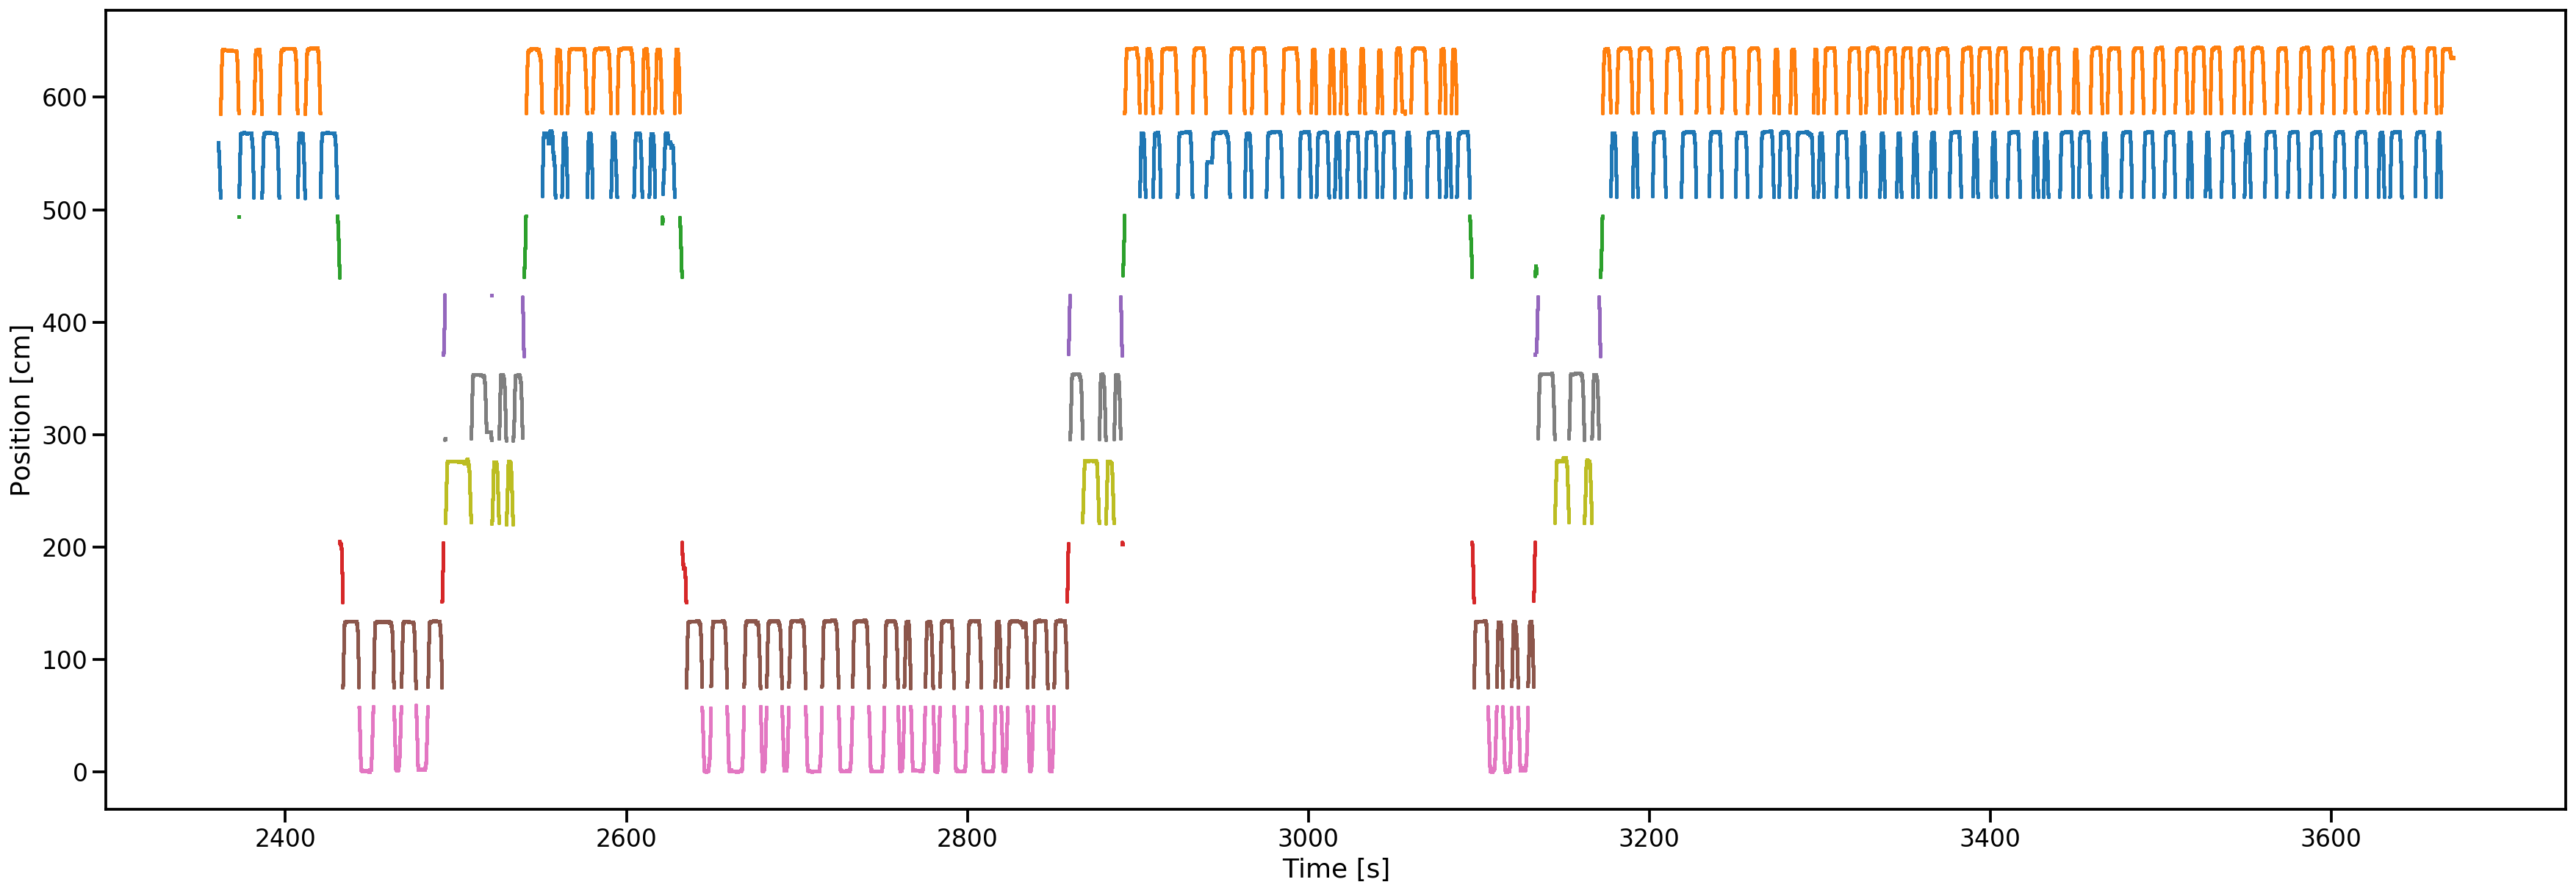

In [4]:
fig, ax = plt.subplots(figsize=(30, 10))

for edge_label, df in data['position_info'].groupby('track_segment_id'):
    ax.scatter(df.index / np.timedelta64(1, 's'), df.linear_position, s=1)
    
ax.set_ylabel('Position [cm]')
ax.set_xlabel('Time [s]');

In [5]:
data["position_info"].to_xarray().to_netcdf(
    f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_position_info.nc"
)

In [6]:
from src.parameters import EDGE_ORDER, EDGE_SPACING
from src.load_data import make_track_graph

track_graph, center_well_id = make_track_graph()
is_running = data["position_info"].speed > 4

## Continuous vs. Jump

In [ ]:
from replay_trajectory_classification import ClusterlessClassifier
from src.parameters import classifier_parameters, discrete_state_transition

from sklearn.model_selection import KFold
from tqdm.auto import tqdm

cv = KFold()
cv_classifier_clusterless_results = []

for fold_ind, (train, test) in tqdm(enumerate(cv.split(data["position_info"].index))):

    cv_classifier = ClusterlessClassifier(**classifier_parameters)

    cv_classifier.fit(
        position=data["position_info"].iloc[train].linear_position,
        multiunits=data["multiunits"].isel(time=train),
        is_training=is_running.iloc[train],
        track_graph=track_graph,
        center_well_id=center_well_id,
        edge_order=EDGE_ORDER,
        edge_spacing=EDGE_SPACING,
    )
    cv_classifier.discrete_state_transition_ = discrete_state_transition
    logging.info('Predicting posterior...')
    cv_classifier_clusterless_results.append(
        cv_classifier.predict(
            data["multiunits"].isel(time=test),
            time=data["position_info"].iloc[test].index / np.timedelta64(1, "s"),
        )
    )
logging.info('Done...')

10-Jun-20 10:58:22 Fitting initial conditions...
10-Jun-20 10:58:23 Fitting state transition...
10-Jun-20 10:58:23 Fitting multiunits...
10-Jun-20 10:58:26 Predicting posterior...


In [ ]:
cv_classifier_clusterless_results = xr.concat(
    cv_classifier_clusterless_results, dim="time"
)
cv_classifier_clusterless_results

In [22]:
cv_classifier_clusterless_results

<xarray.Dataset>
Dimensions:            (position: 221, state: 2, time: 655622)
Coordinates:
  * position           (position) float64 1.236 3.707 6.178 ... 640.9 643.4
  * state              (state) <U11 'random_walk' 'uniform'
  * time               (time) float64 2.36e+03 2.36e+03 ... 3.672e+03 3.672e+03
Data variables:
    likelihood         (time, state, position) float64 0.8672 0.845 ... 0.89
    causal_posterior   (time, state, position) float64 0.004876 ... 0.0003706
    acausal_posterior  (time, state, position) float64 2.467e-05 ... 0.0003706

In [11]:
cv_classifier_clusterless_results.to_netcdf(
    f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_cv_classifier_clusterless_results.nc"
)

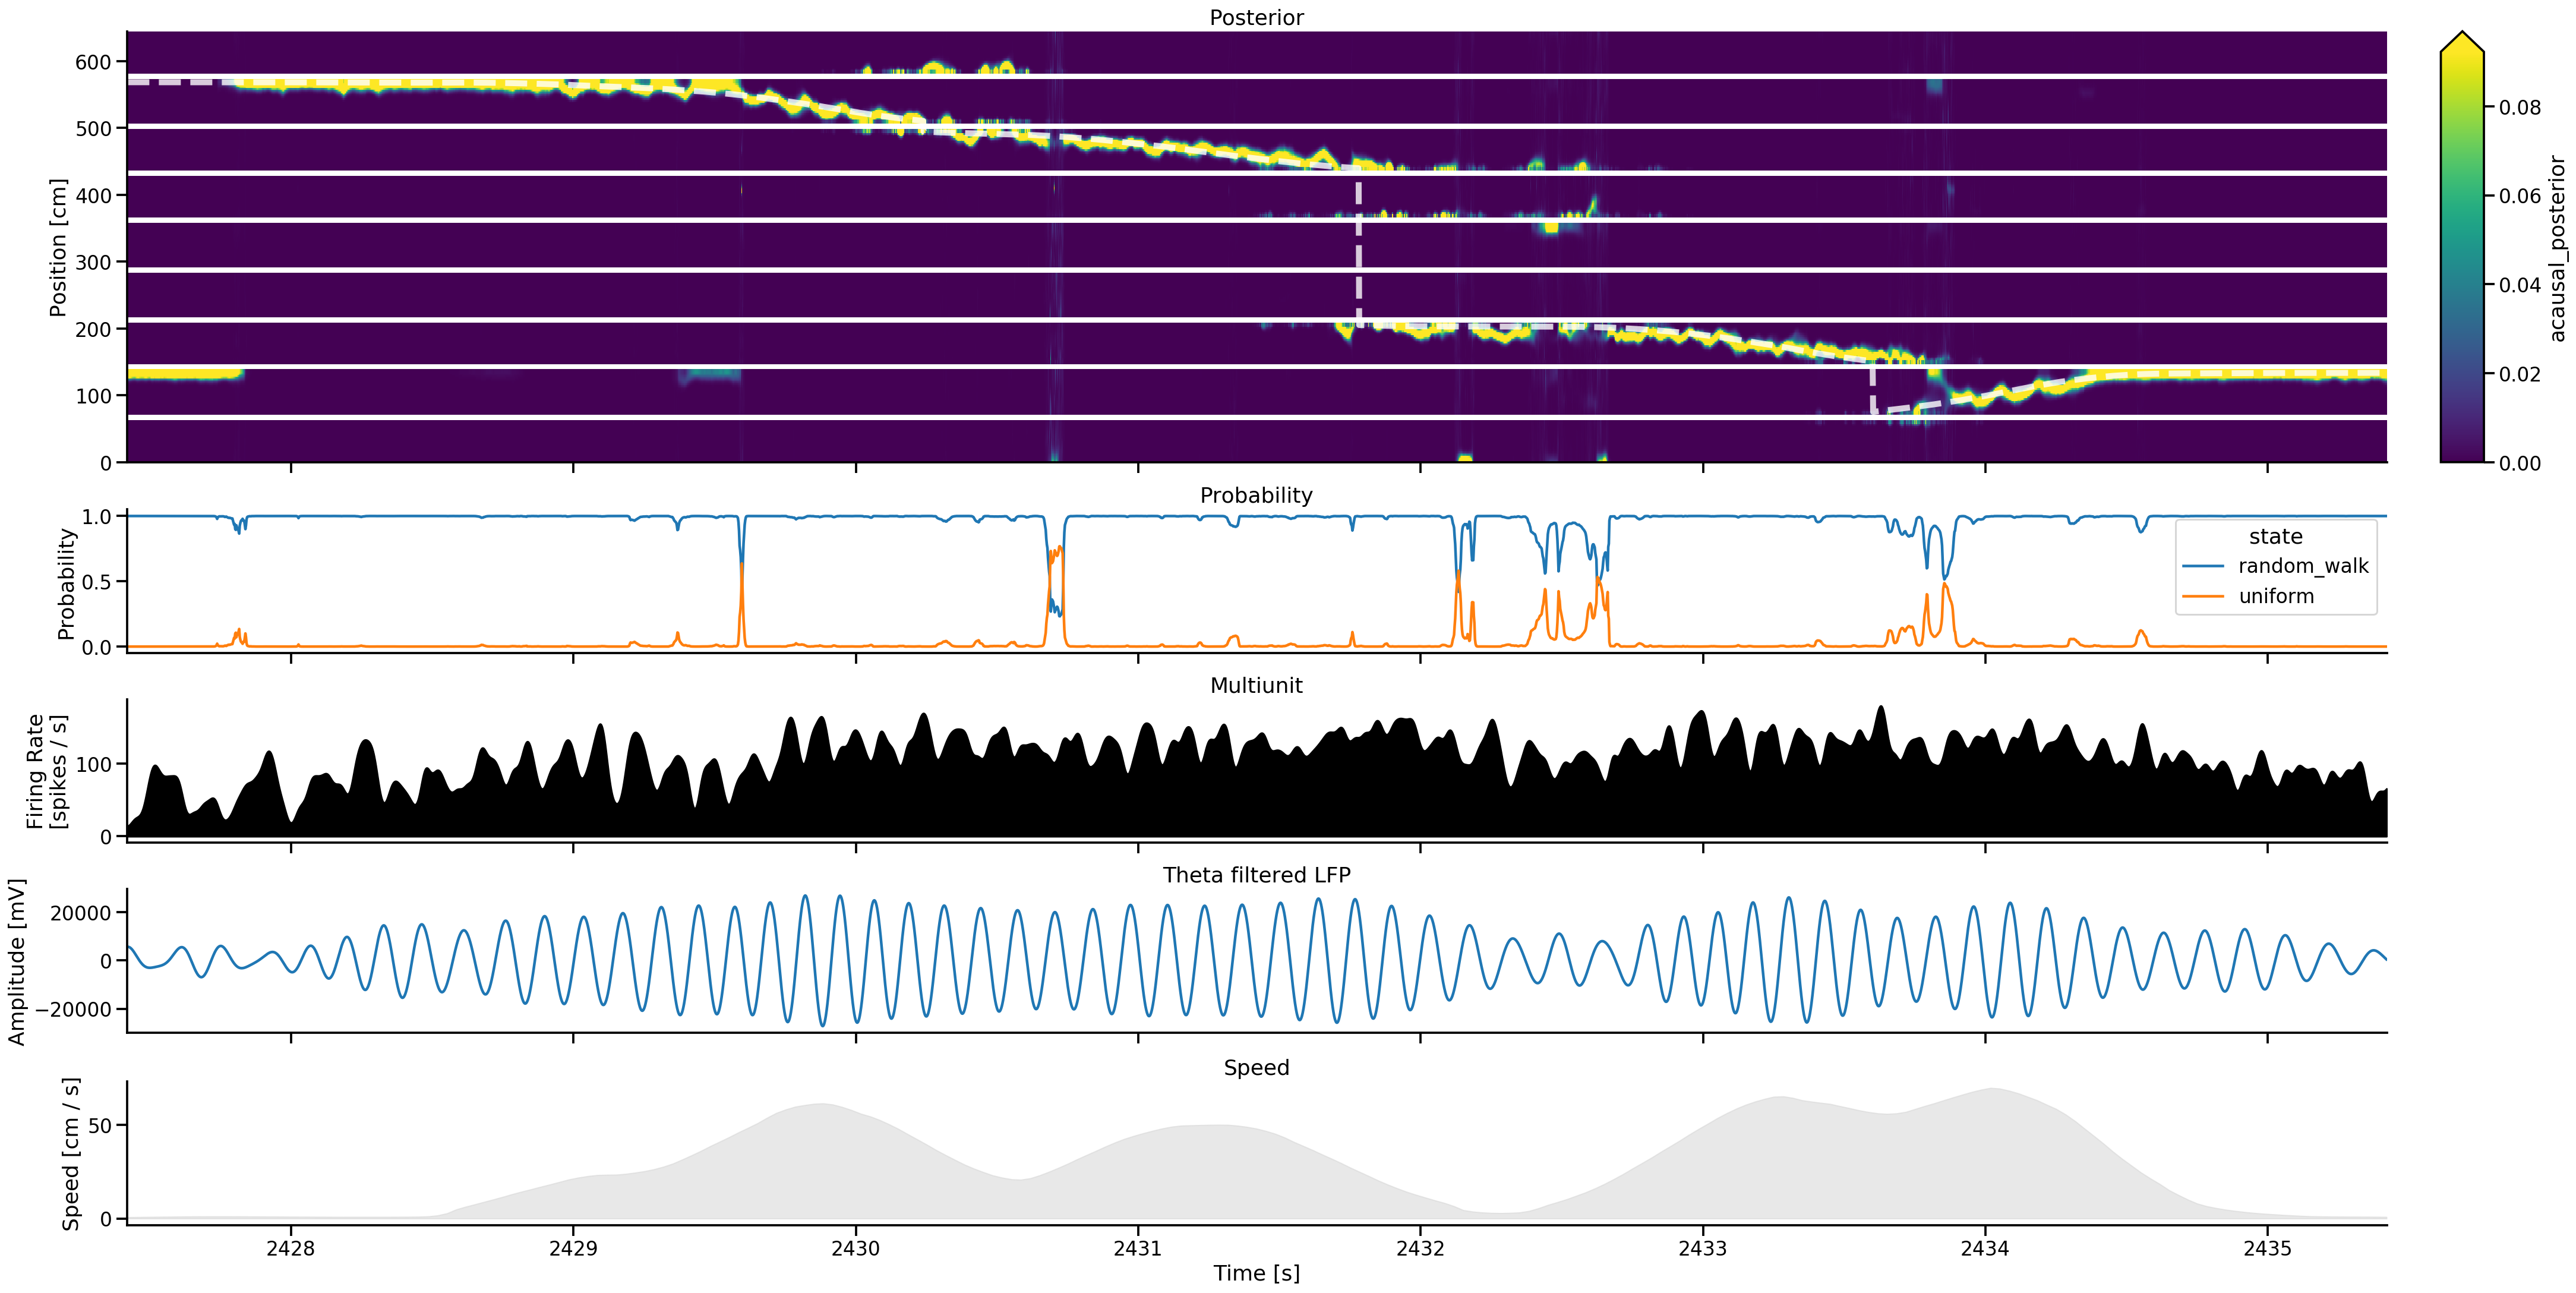

In [23]:
from src.visualization import plot_classifier_time_slice

time = cv_classifier_clusterless_results.time.values
time_slice = slice(time[33500], time[37500])

plot_classifier_time_slice(
    time_slice,
    cv_classifier,
    cv_classifier_clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

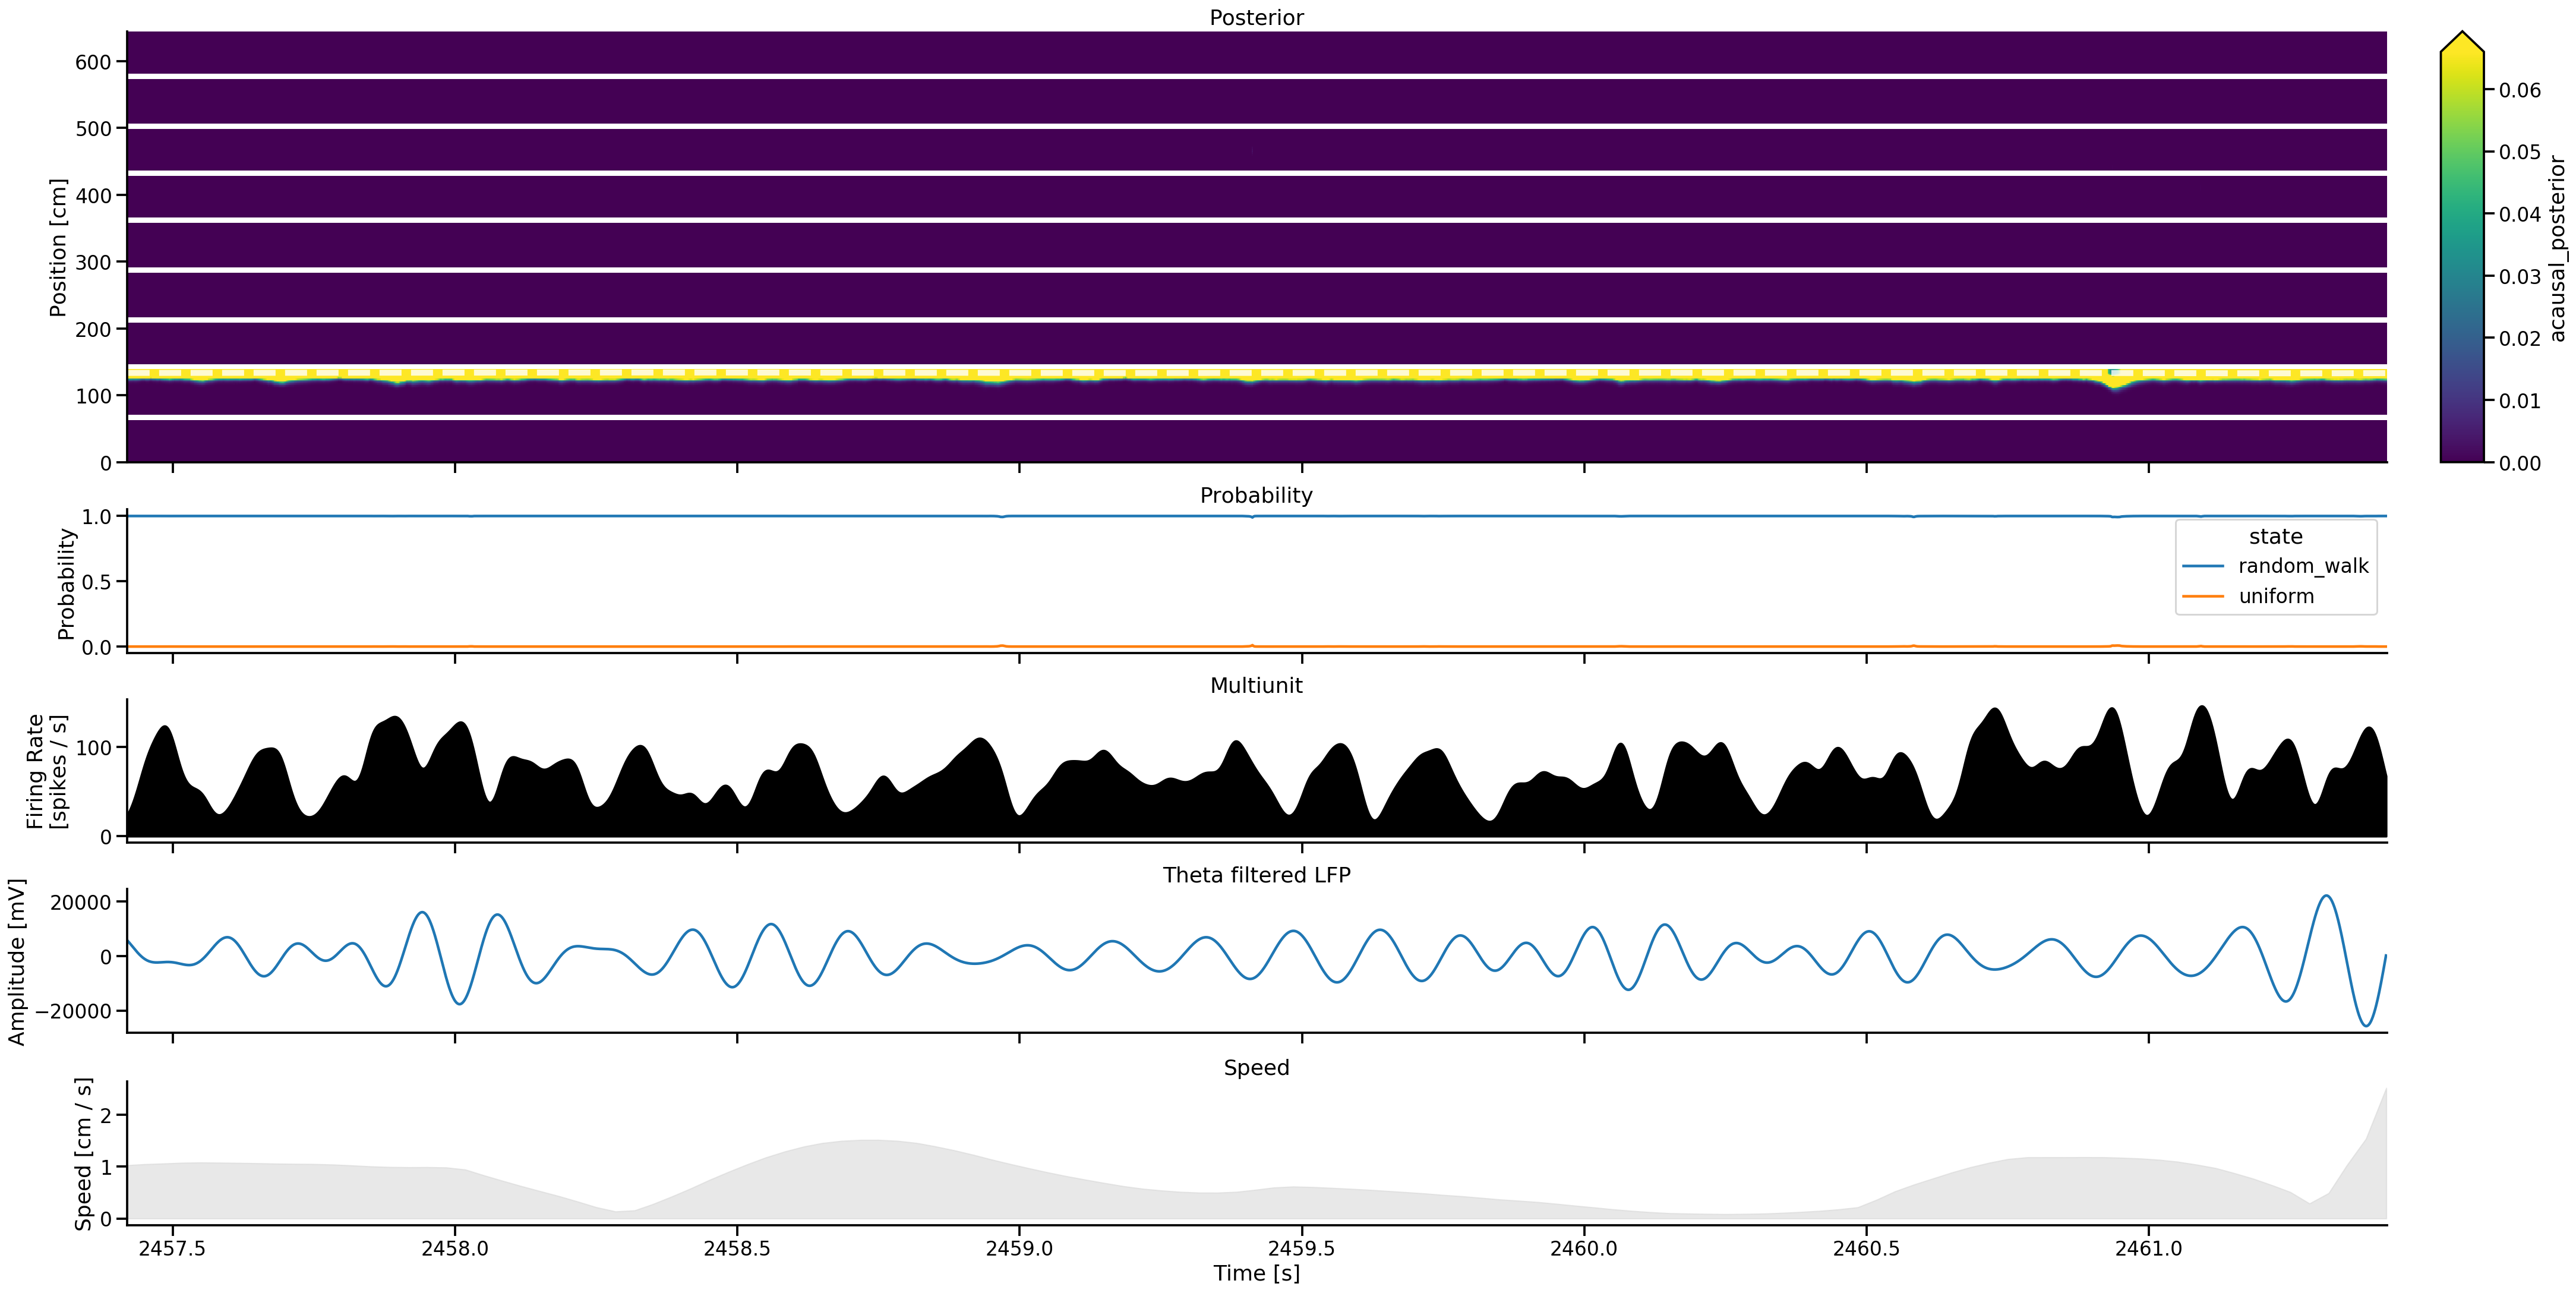

In [15]:
from src.visualization import plot_classifier_time_slice

time = cv_classifier_clusterless_results.time.values
time_slice = slice(time[48500], time[50500])

plot_classifier_time_slice(
    time_slice,
    cv_classifier,
    cv_classifier_clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

In [18]:
from src.visualization import plot_classifier_time_slice

time = cv_classifier_clusterless_results.time.values
time_slice = slice(time[830700], time[832700])

plot_classifier_time_slice(
    time_slice,
    cv_classifier,
    cv_classifier_clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

IndexError: index 830700 is out of bounds for axis 0 with size 655622

In [17]:
from src.visualization import plot_classifier_time_slice

time = cv_classifier_clusterless_results.time.values
time_slice = slice(time[999500], time[1003500])

plot_classifier_time_slice(
    time_slice,
    cv_classifier,
    cv_classifier_clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

IndexError: index 999500 is out of bounds for axis 0 with size 655622

## Local vs. Non-Local

In [33]:
from replay_identification import ReplayDetector
from src.parameters import detector_parameters
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

cv = KFold()
cv_clusterless_results = []

# We don't have the ripples calculated and this isn't being used in the model, so we just have to set it to something dumb.
is_ripple = np.ones_like(data["position_info"].speed.values, dtype=np.bool)
is_ripple[::2] = False

for train, test in tqdm(cv.split(data["position_info"].index)):

    cv_detector = ReplayDetector(**detector_parameters)
    cv_detector.fit(
        is_ripple=is_ripple[train],
        speed=data["position_info"].iloc[train].speed,
        position=data["position_info"].iloc[train].linear_position,
        multiunit=data["multiunits"].isel(time=train),
        track_graph=track_graph,
        center_well_id=center_well_id,
        edge_order=EDGE_ORDER,
        edge_spacing=EDGE_SPACING,
    )
    
    logging.info('Predicting posterior...')
    cv_clusterless_results.append(
        cv_detector.predict(
            speed=data["position_info"].iloc[test].speed,
            position=data["position_info"].iloc[test].linear_position,
            multiunit=data["multiunits"].isel(time=test),
            use_likelihoods=["multiunit"],
            time=data["position_info"].iloc[test].index / np.timedelta64(1, "s"),
        )
    )
logging.info('Done...')

13-Feb-20 10:40:27 Fitting speed model...
13-Feb-20 10:40:28 Fitting multiunit model...


13-Feb-20 10:40:31 Fitting replay movement state transition...
13-Feb-20 10:40:31 Fitting replay state transition...
13-Feb-20 10:40:31 Predicting posterior...


13-Feb-20 10:40:31 Predicting multiunit likelihood...


13-Feb-20 15:19:21 Finding causal replay probability and position...
13-Feb-20 15:19:24 Finding acausal replay probability and position...
13-Feb-20 15:19:33 Fitting speed model...
13-Feb-20 15:19:34 Fitting multiunit model...


13-Feb-20 15:19:37 Fitting replay movement state transition...
13-Feb-20 15:19:37 Fitting replay state transition...
13-Feb-20 15:19:37 Predicting posterior...


13-Feb-20 15:19:37 Predicting multiunit likelihood...


13-Feb-20 19:54:47 Finding causal replay probability and position...
13-Feb-20 19:54:48 Finding acausal replay probability and position...
13-Feb-20 19:54:53 Fitting speed model...
13-Feb-20 19:54:54 Fitting multiunit model...


13-Feb-20 19:54:57 Fitting replay movement state transition...
13-Feb-20 19:54:57 Fitting replay state transition...
13-Feb-20 19:54:57 Predicting posterior...


13-Feb-20 19:54:57 Predicting multiunit likelihood...


14-Feb-20 00:26:22 Finding causal replay probability and position...
14-Feb-20 00:26:23 Finding acausal replay probability and position...
14-Feb-20 00:26:27 Fitting speed model...
14-Feb-20 00:26:28 Fitting multiunit model...


14-Feb-20 00:26:31 Fitting replay movement state transition...
14-Feb-20 00:26:31 Fitting replay state transition...
14-Feb-20 00:26:31 Predicting posterior...


14-Feb-20 00:26:31 Predicting multiunit likelihood...


14-Feb-20 04:41:57 Finding causal replay probability and position...
14-Feb-20 04:41:58 Finding acausal replay probability and position...
14-Feb-20 04:42:03 Fitting speed model...
14-Feb-20 04:42:04 Fitting multiunit model...


14-Feb-20 04:42:06 Fitting replay movement state transition...
14-Feb-20 04:42:06 Fitting replay state transition...
14-Feb-20 04:42:06 Predicting posterior...


14-Feb-20 04:42:07 Predicting multiunit likelihood...


14-Feb-20 08:55:57 Finding causal replay probability and position...
14-Feb-20 08:55:58 Finding acausal replay probability and position...
14-Feb-20 08:56:02 Done...


In [34]:
cv_clusterless_results = xr.concat(cv_clusterless_results, dim="time")
cv_clusterless_results

<xarray.Dataset>
Dimensions:             (position: 72, state: 2, time: 1022605)
Coordinates:
  * position            (position) float64 1.191 3.573 5.955 ... 267.6 269.9
  * state               (state) <U9 'Local' 'Non-Local'
  * time                (time) float64 2.611e+03 2.611e+03 ... 4.656e+03
Data variables:
    causal_posterior    (time, state, position) float64 0.0 0.0 ... 9.396e-07
    likelihood          (time, state, position) float64 0.47 0.47 ... 0.7459
    acausal_posterior   (time, state, position) float64 0.0 0.0 ... 9.396e-07
    replay_probability  (time) float64 0.0 1.504e-06 ... 2.733e-05 4.176e-05

In [35]:
cv_clusterless_results.to_netcdf(
    f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_cv_clusterless_local_non_local_results.nc"
)

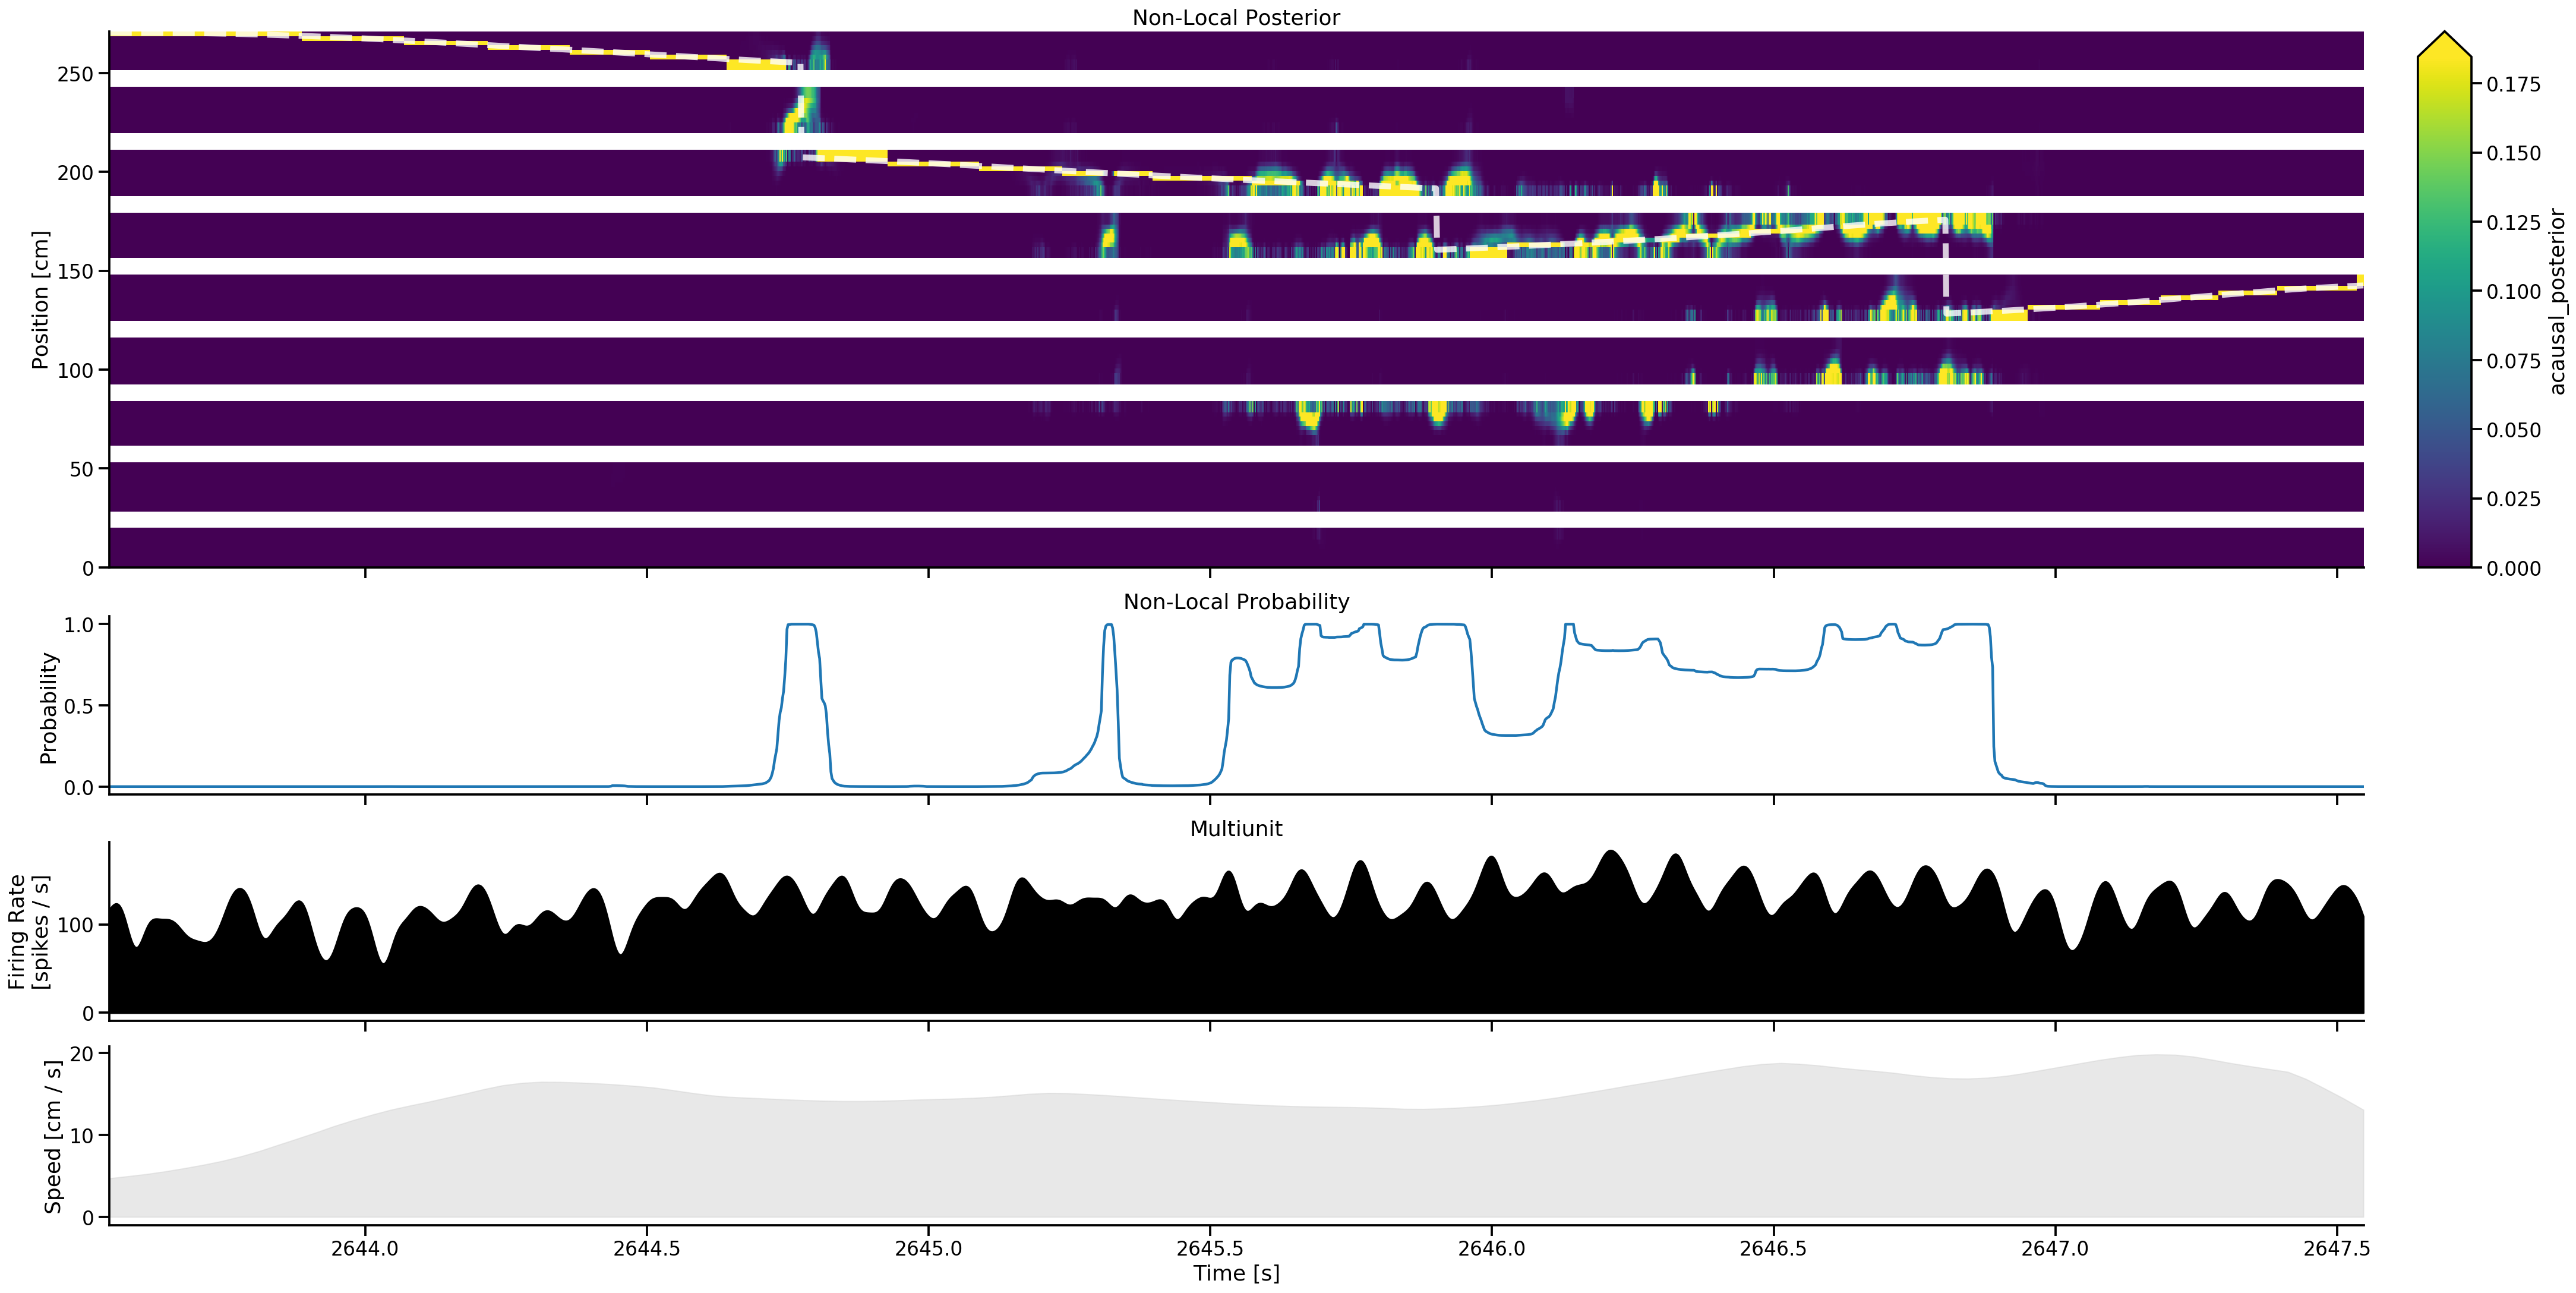

In [22]:
from src.visualization import plot_local_non_local_time_slice

time = cv_classifier_clusterless_results.time.values
time_slice = slice(time[16500], time[18500])

plot_local_non_local_time_slice(
    time_slice,
    cv_detector,
    cv_clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

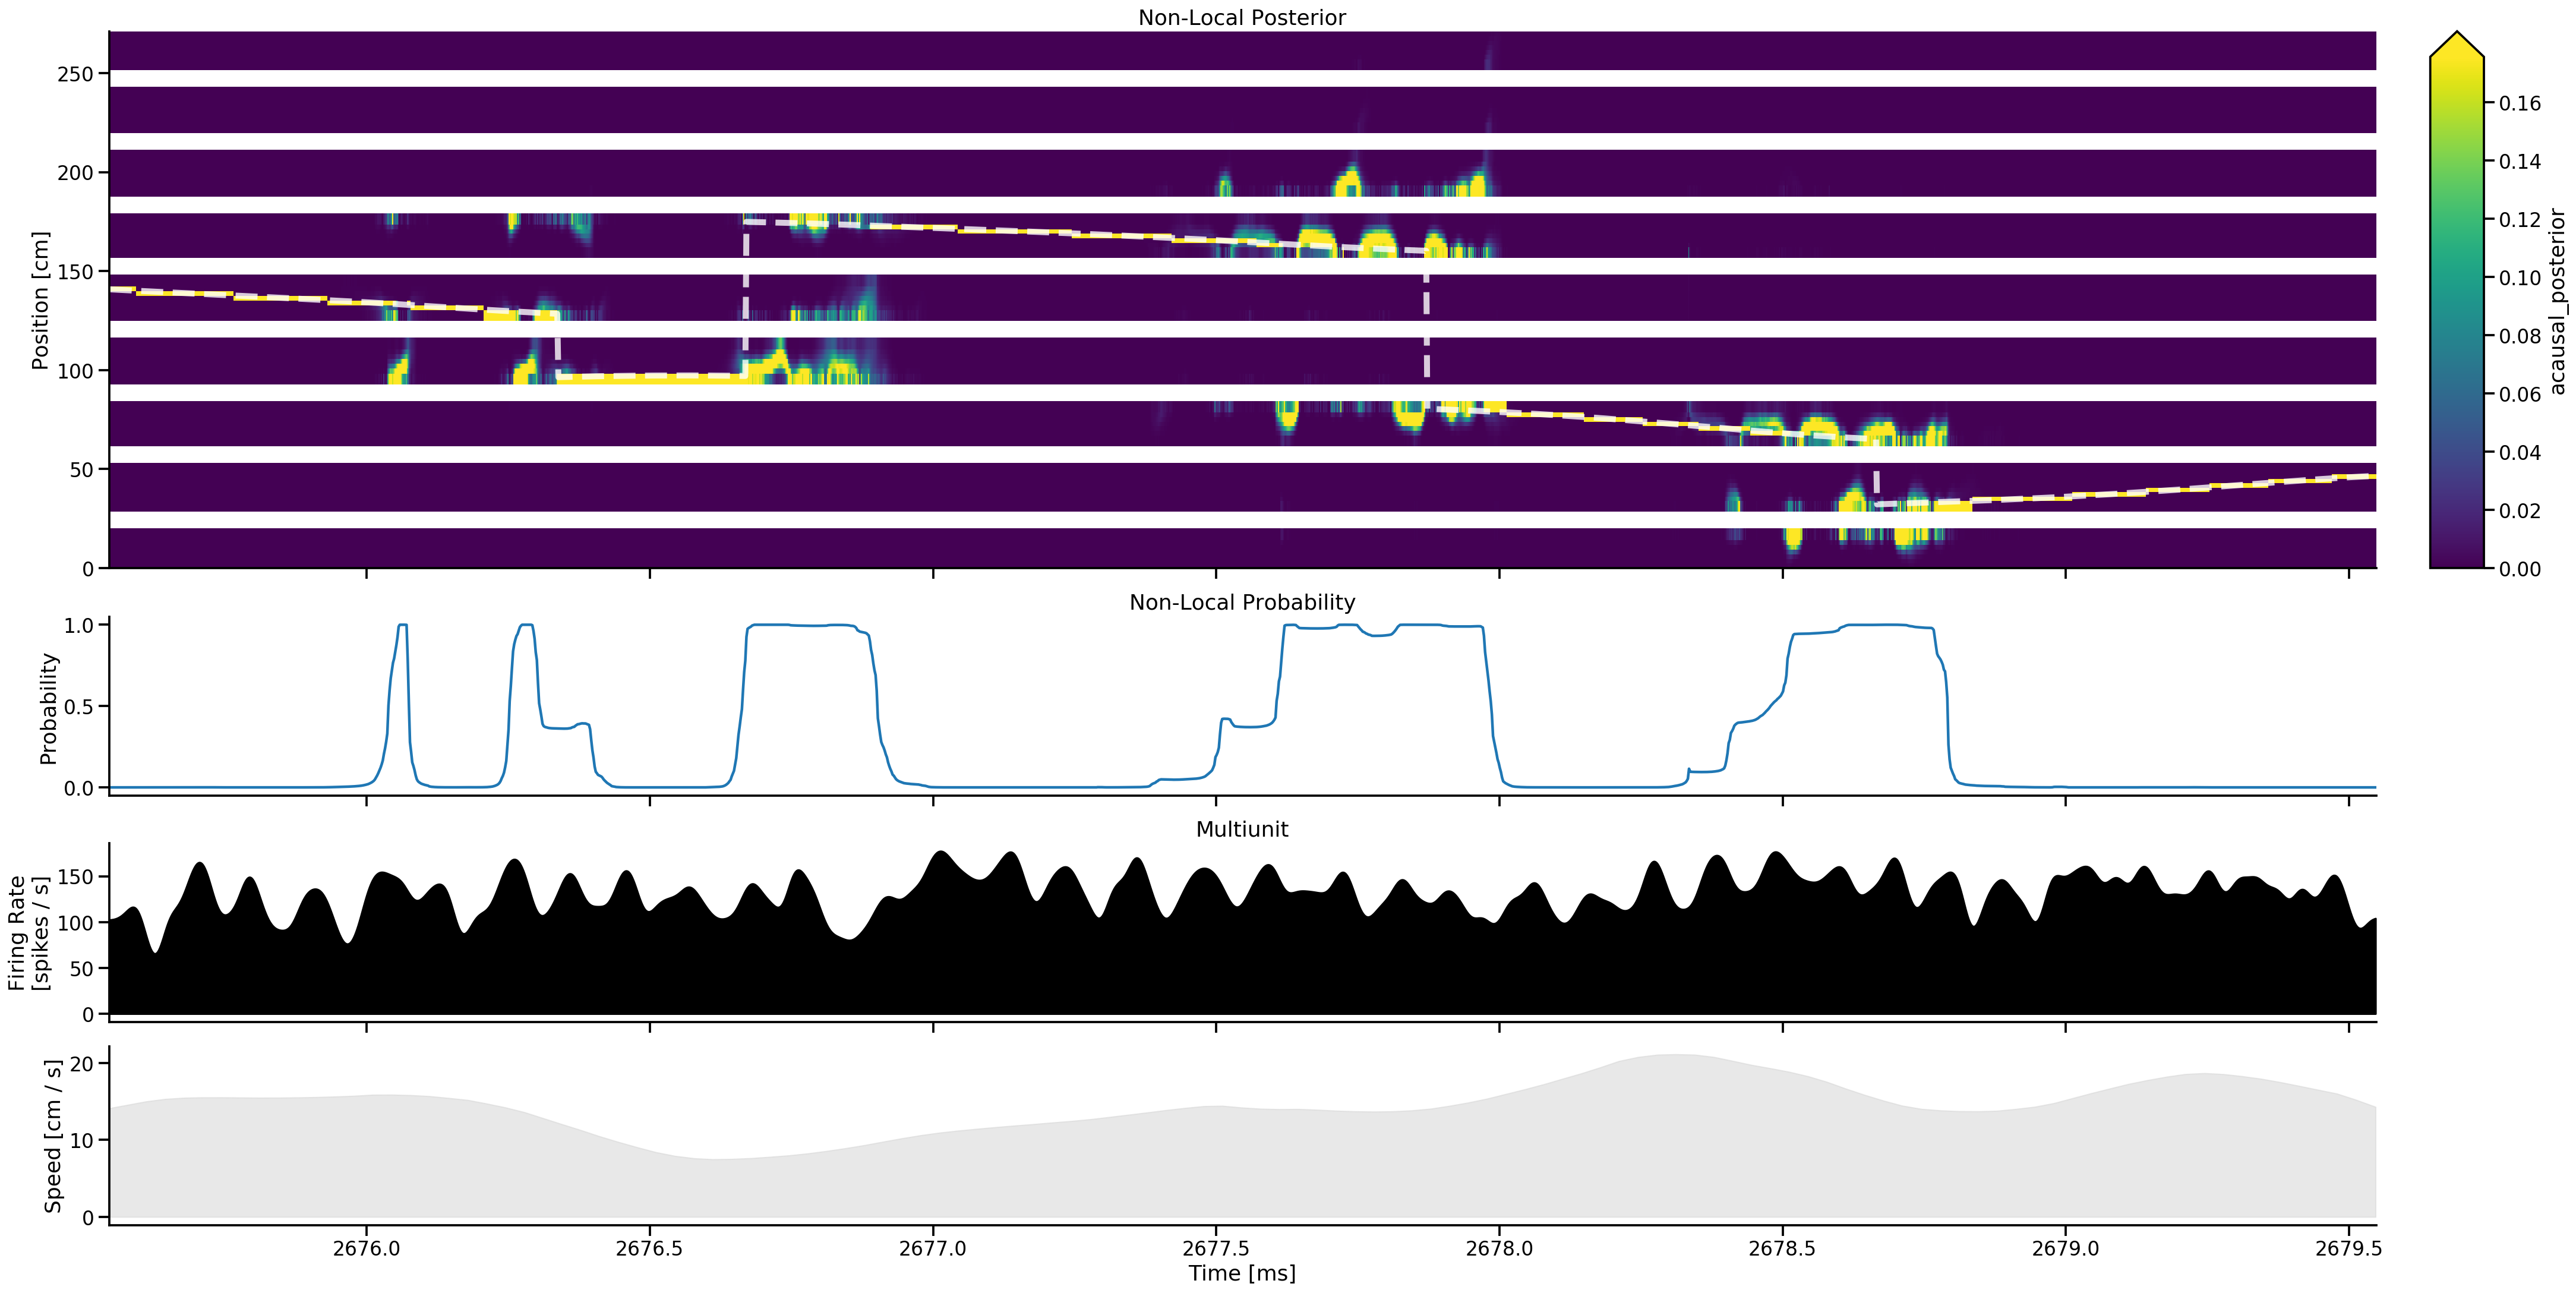

In [37]:
time = cv_classifier_clusterless_results.time.values
time_slice = slice(time[32500], time[34500])

plot_local_non_local_time_slice(
    time_slice,
    cv_detector,
    cv_clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

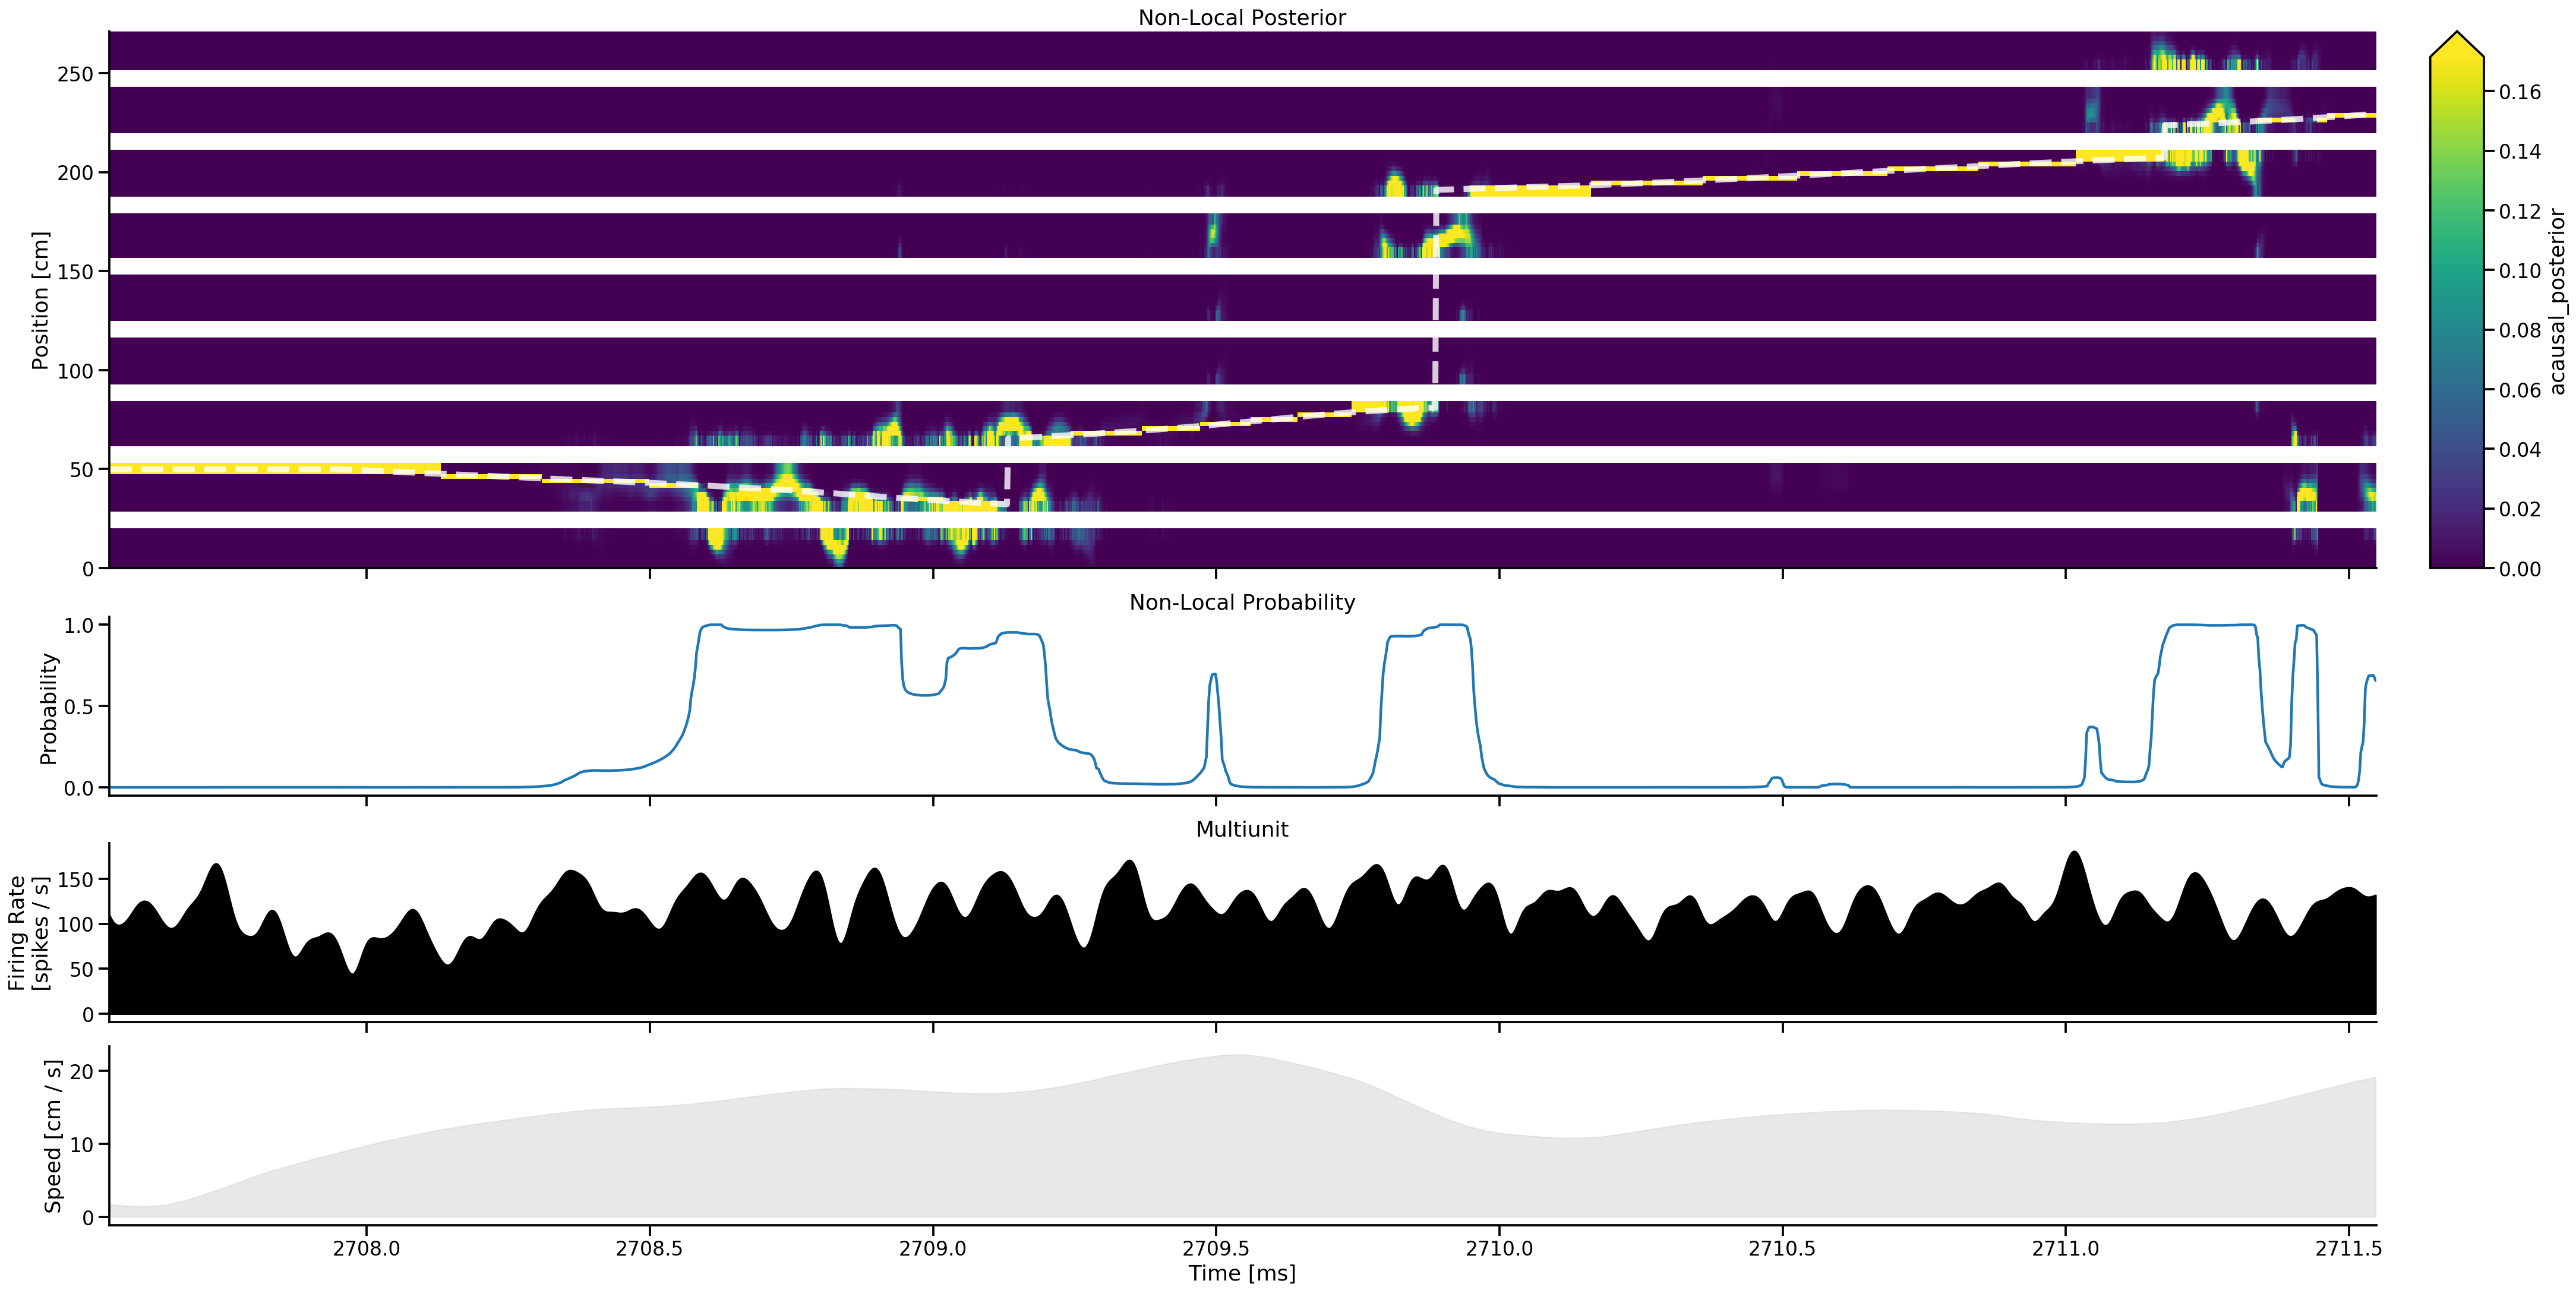

In [38]:
time = cv_classifier_clusterless_results.time.values
time_slice = slice(time[48500], time[50500])

plot_local_non_local_time_slice(
    time_slice,
    cv_detector,
    cv_clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

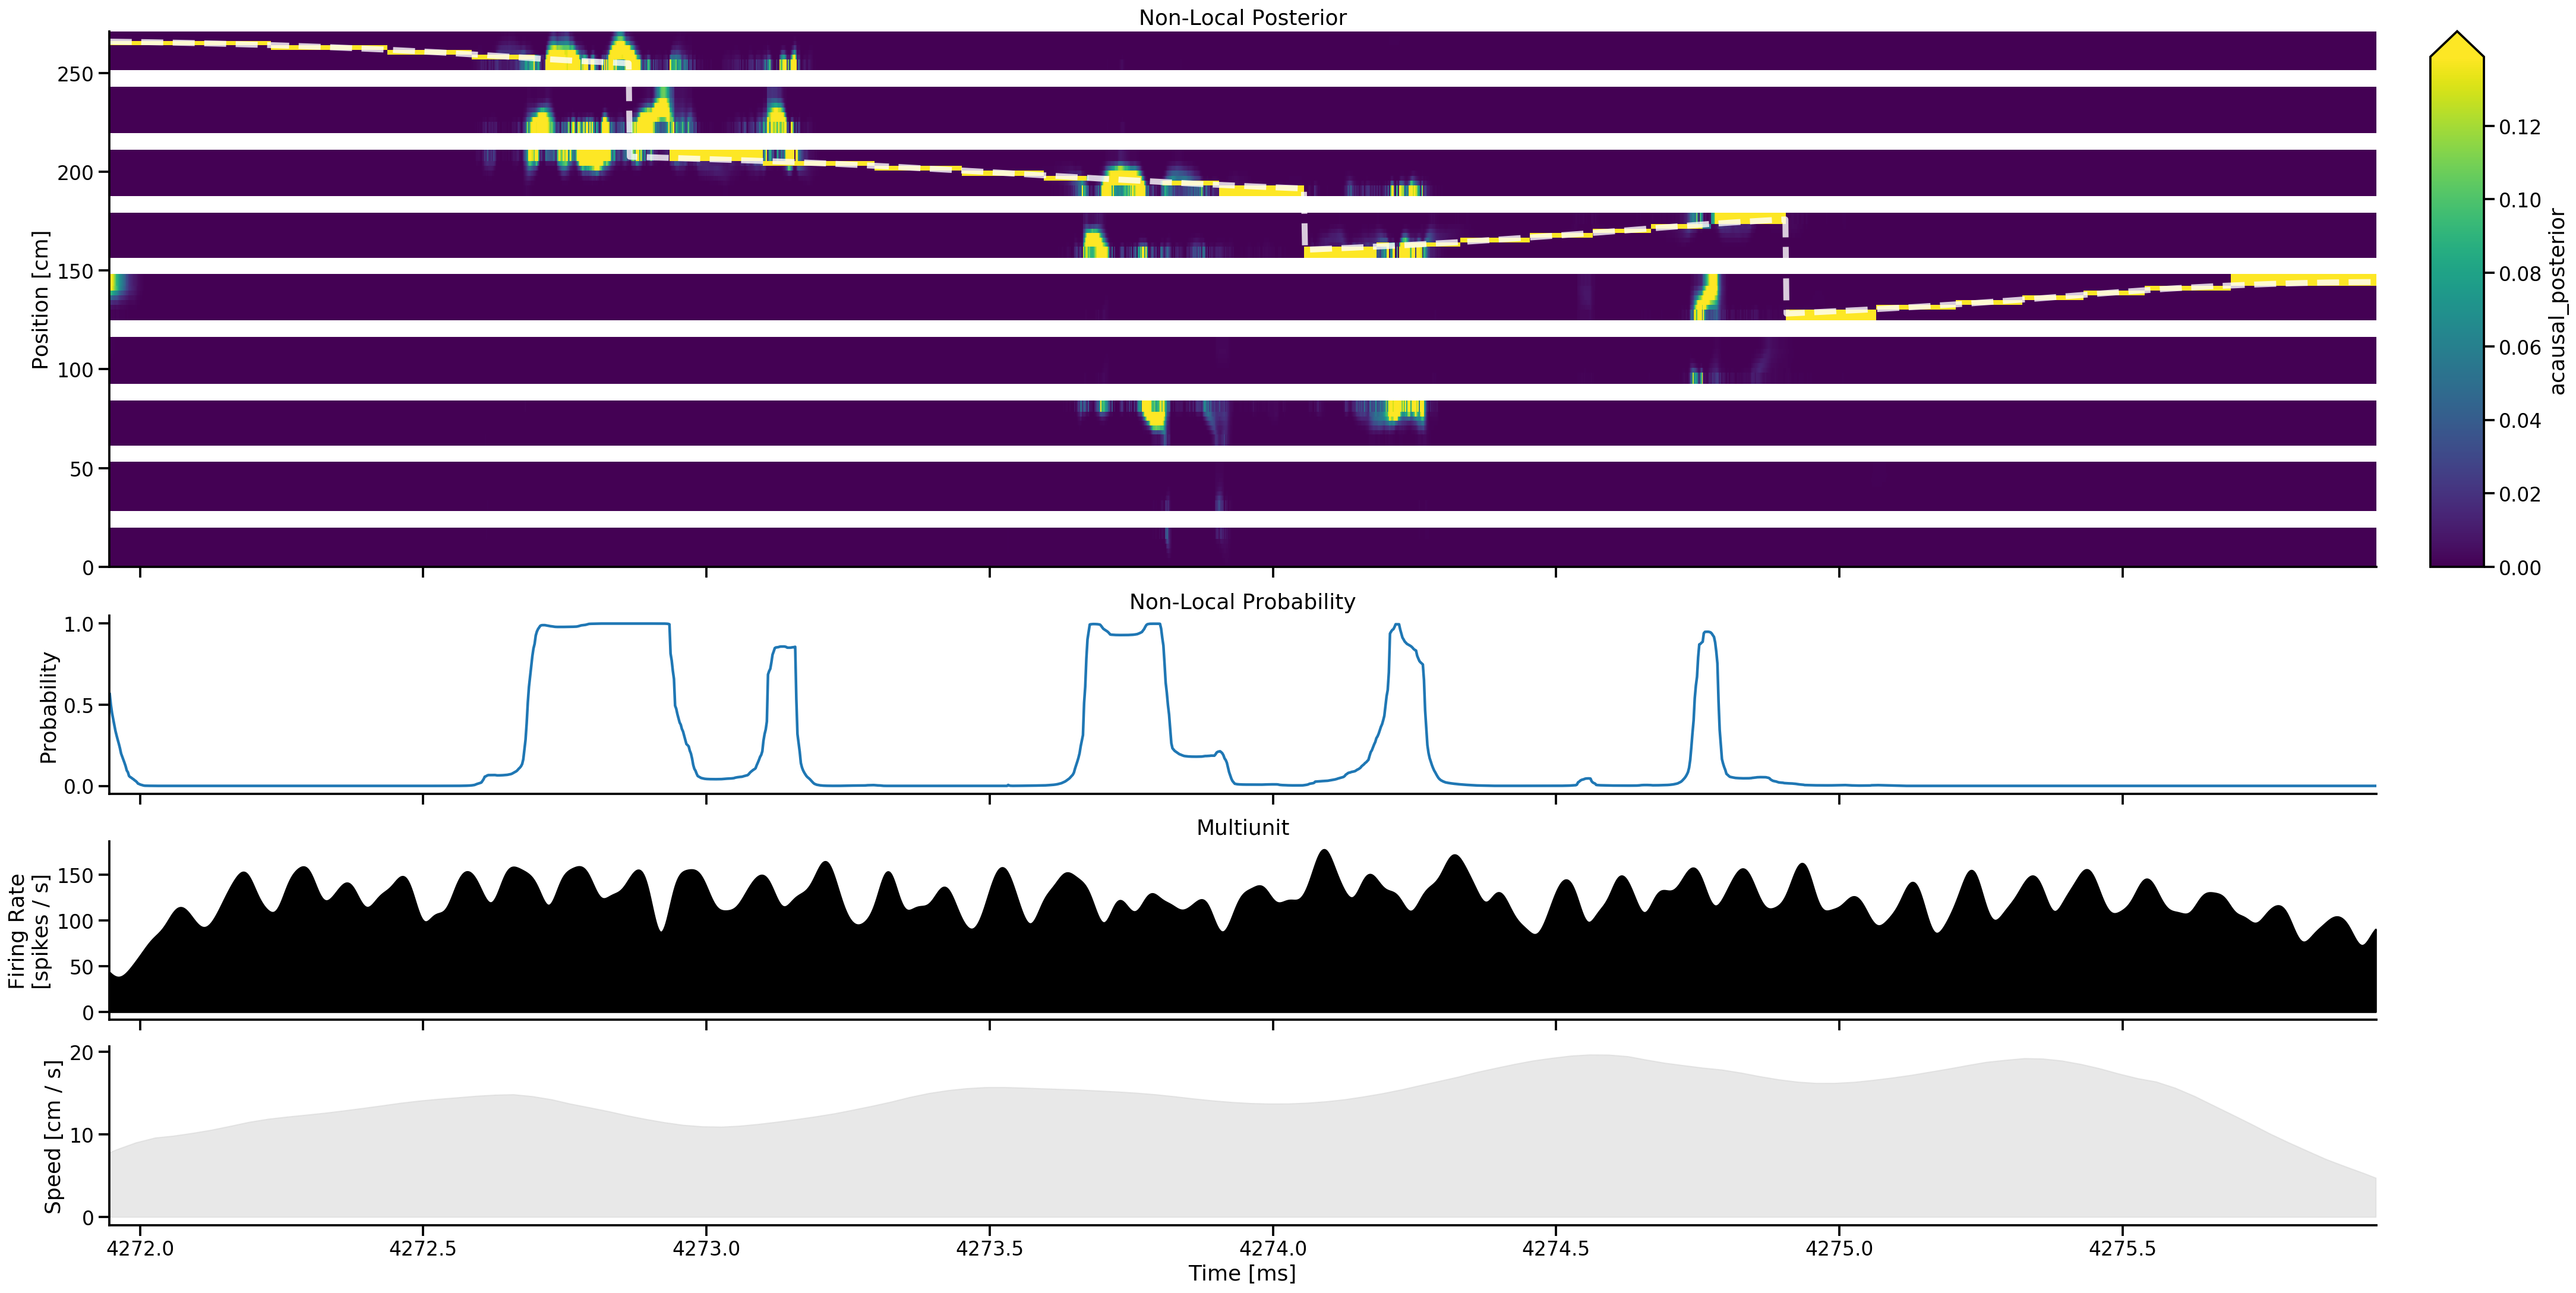

In [39]:
time = cv_classifier_clusterless_results.time.values
time_slice = slice(time[830700], time[832700])

plot_local_non_local_time_slice(
    time_slice,
    cv_detector,
    cv_clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

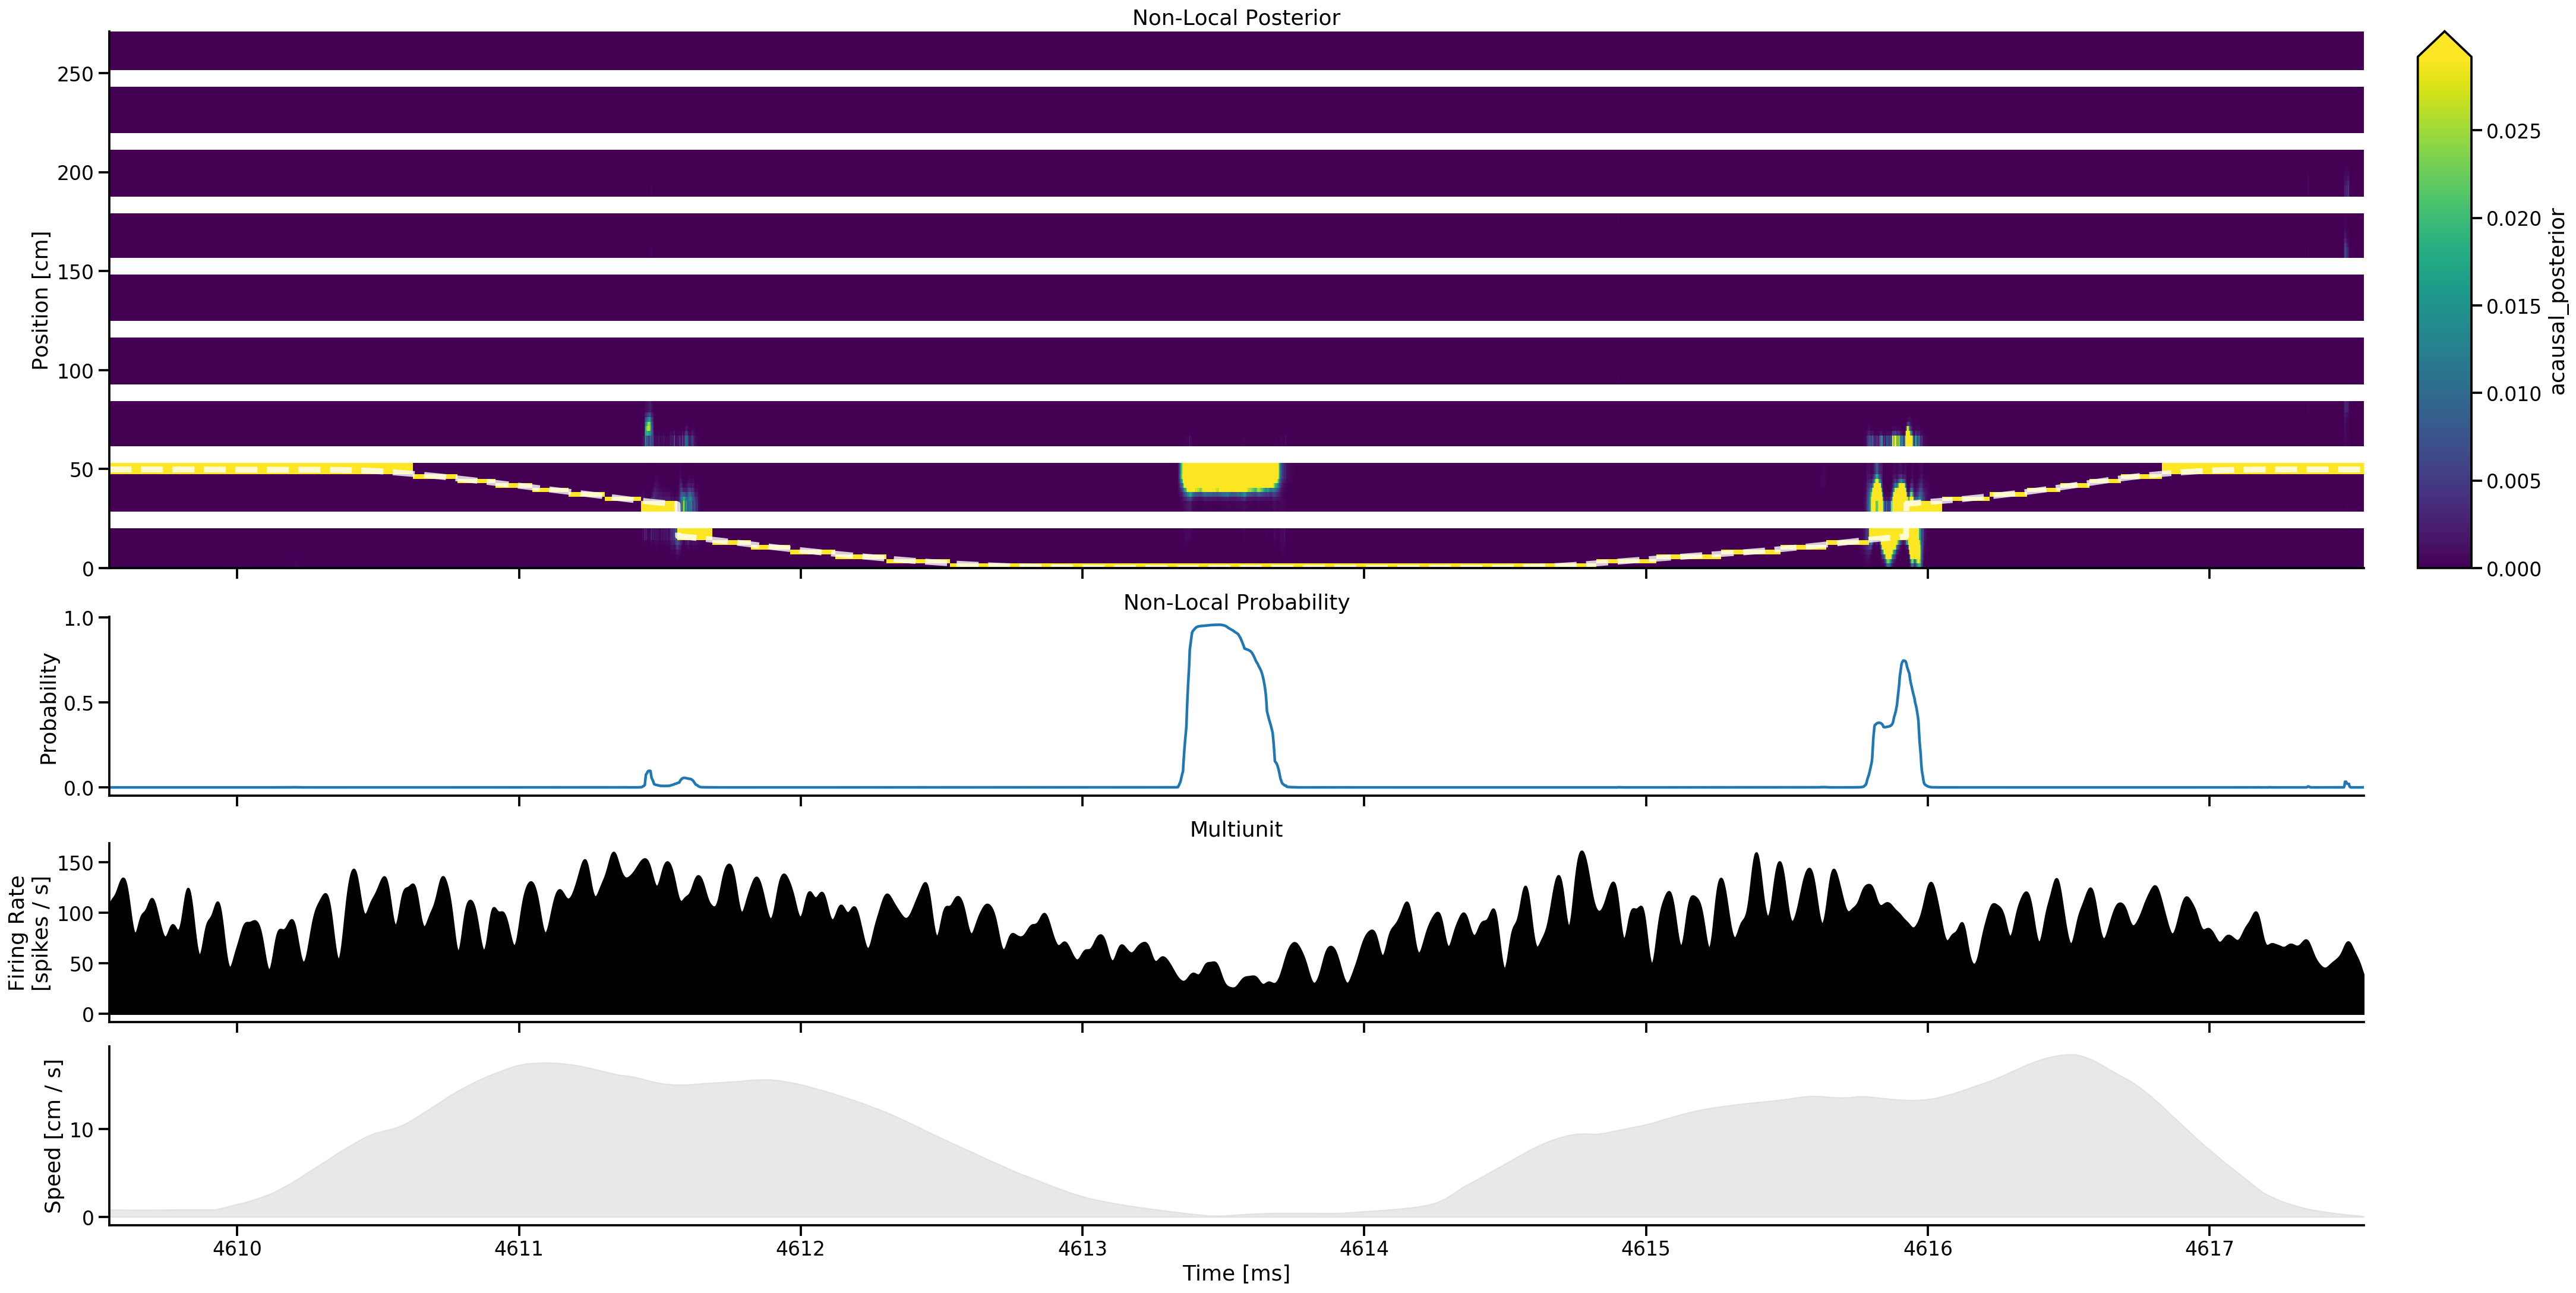

In [40]:
time = cv_classifier_clusterless_results.time.values
time_slice = slice(time[999500], time[1003500])

plot_local_non_local_time_slice(
    time_slice,
    cv_detector,
    cv_clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

## Other Times

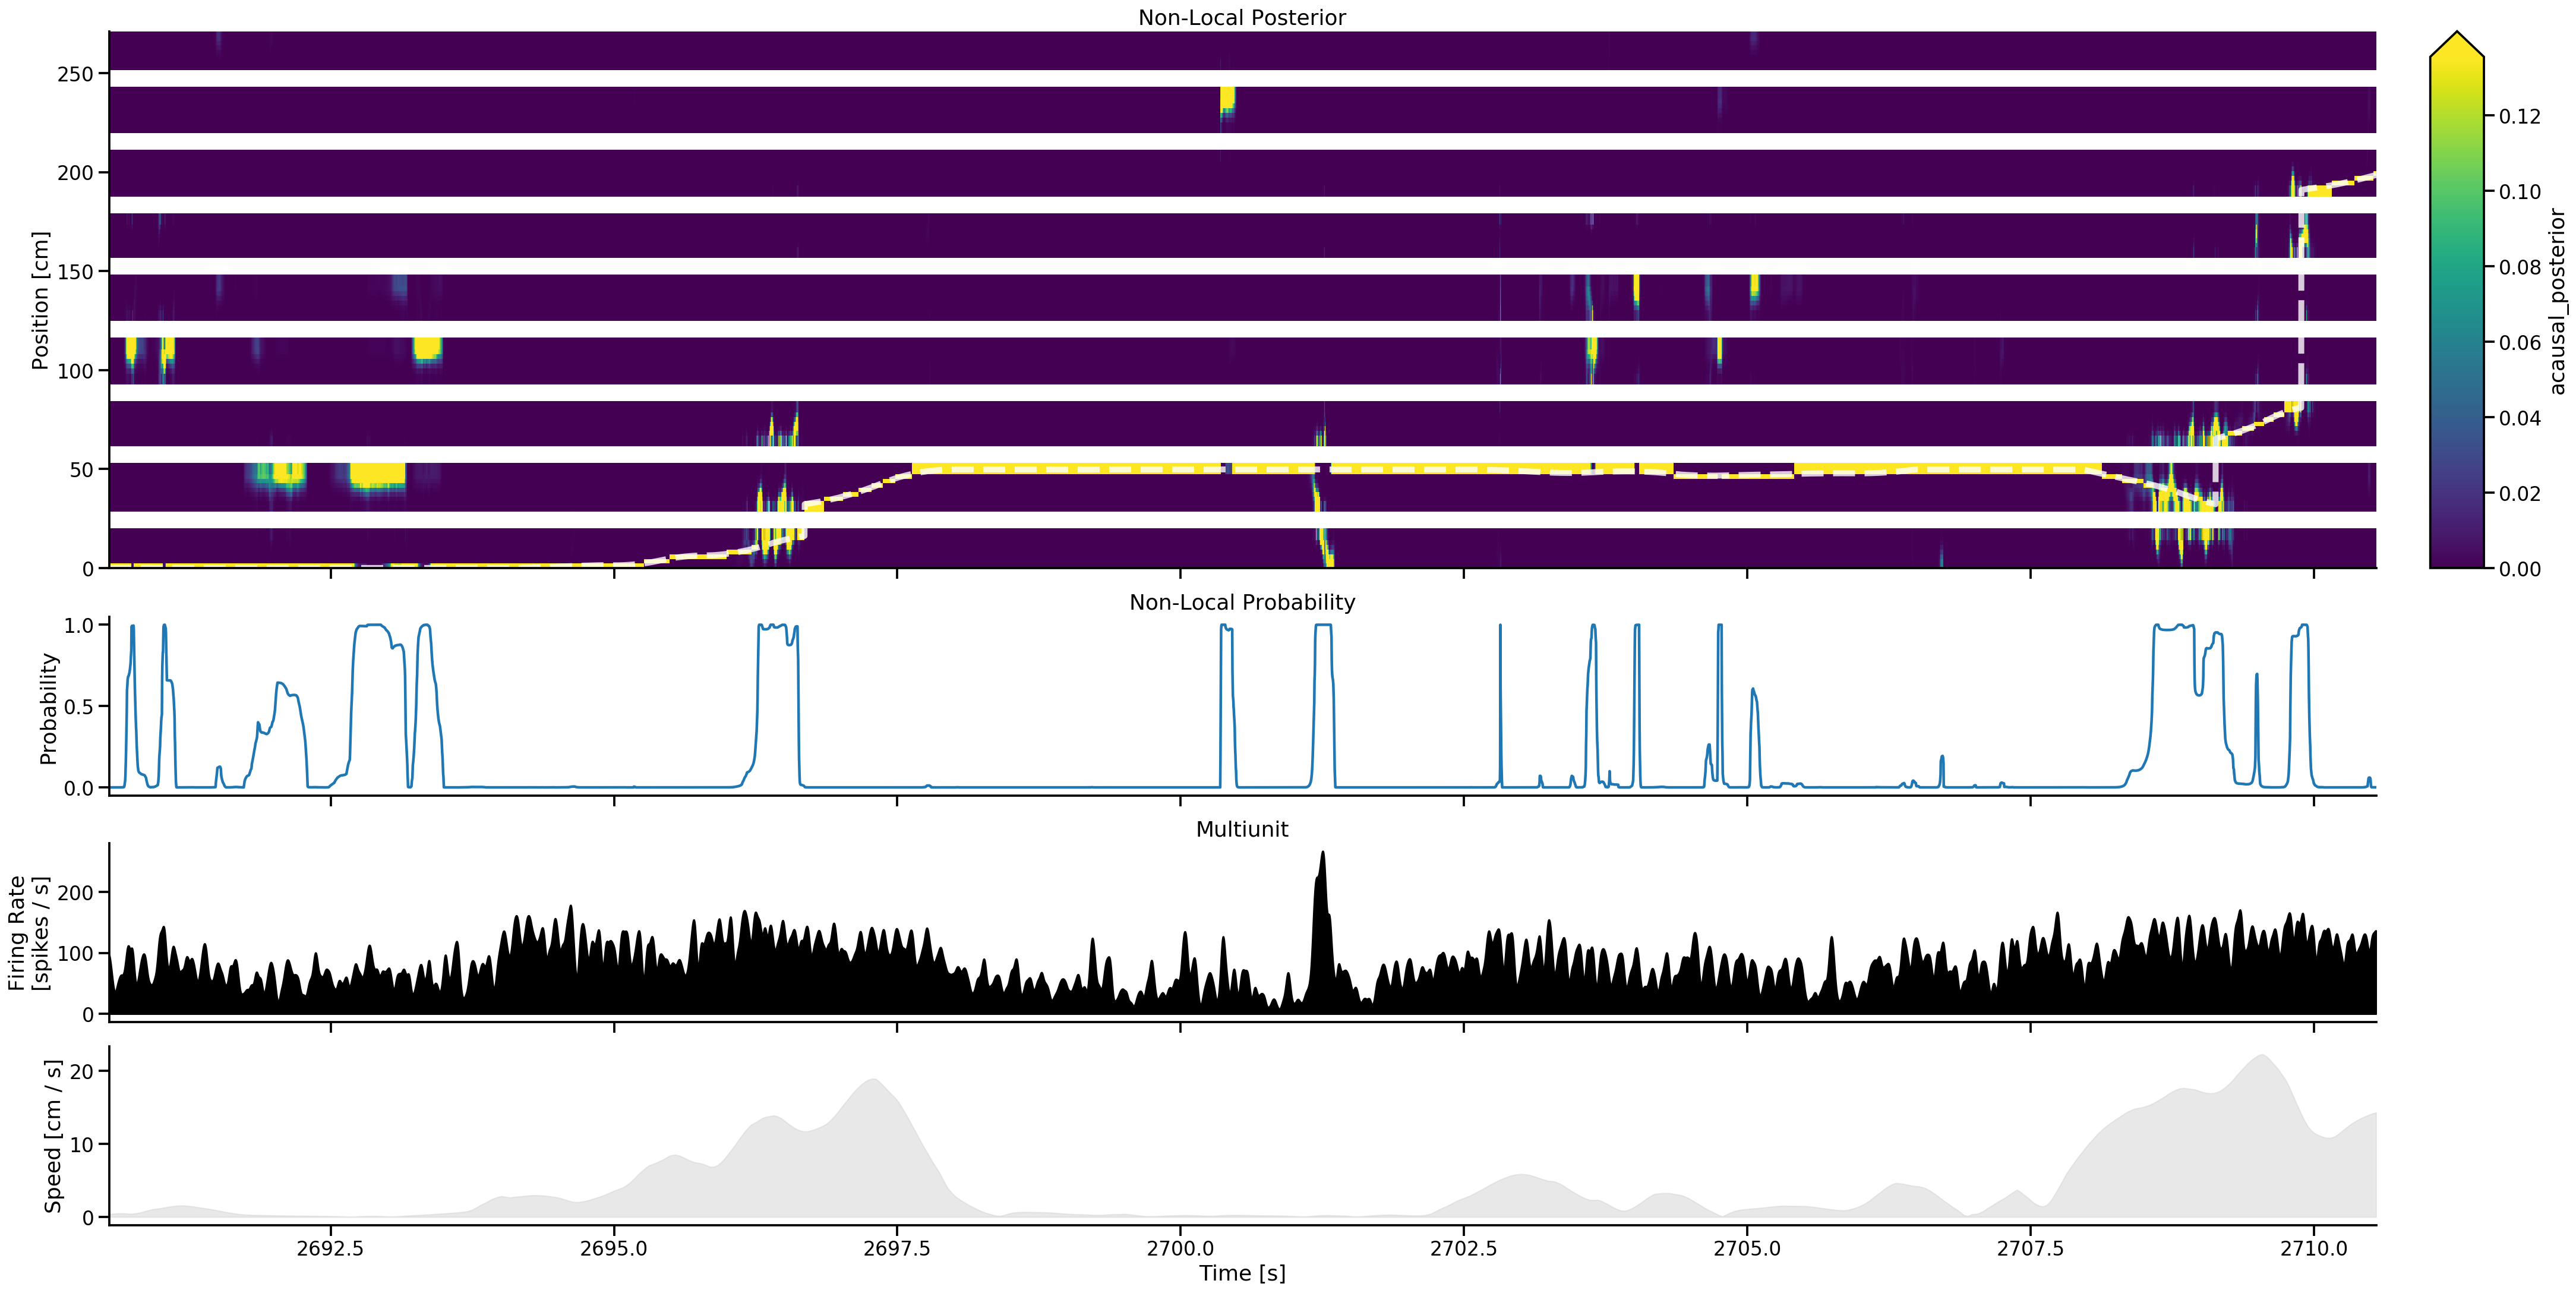

In [47]:
time = cv_classifier_clusterless_results.time.values
time_slice = slice(time[40_000], time[50_000])

plot_local_non_local_time_slice(
    time_slice,
    cv_detector,
    cv_clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

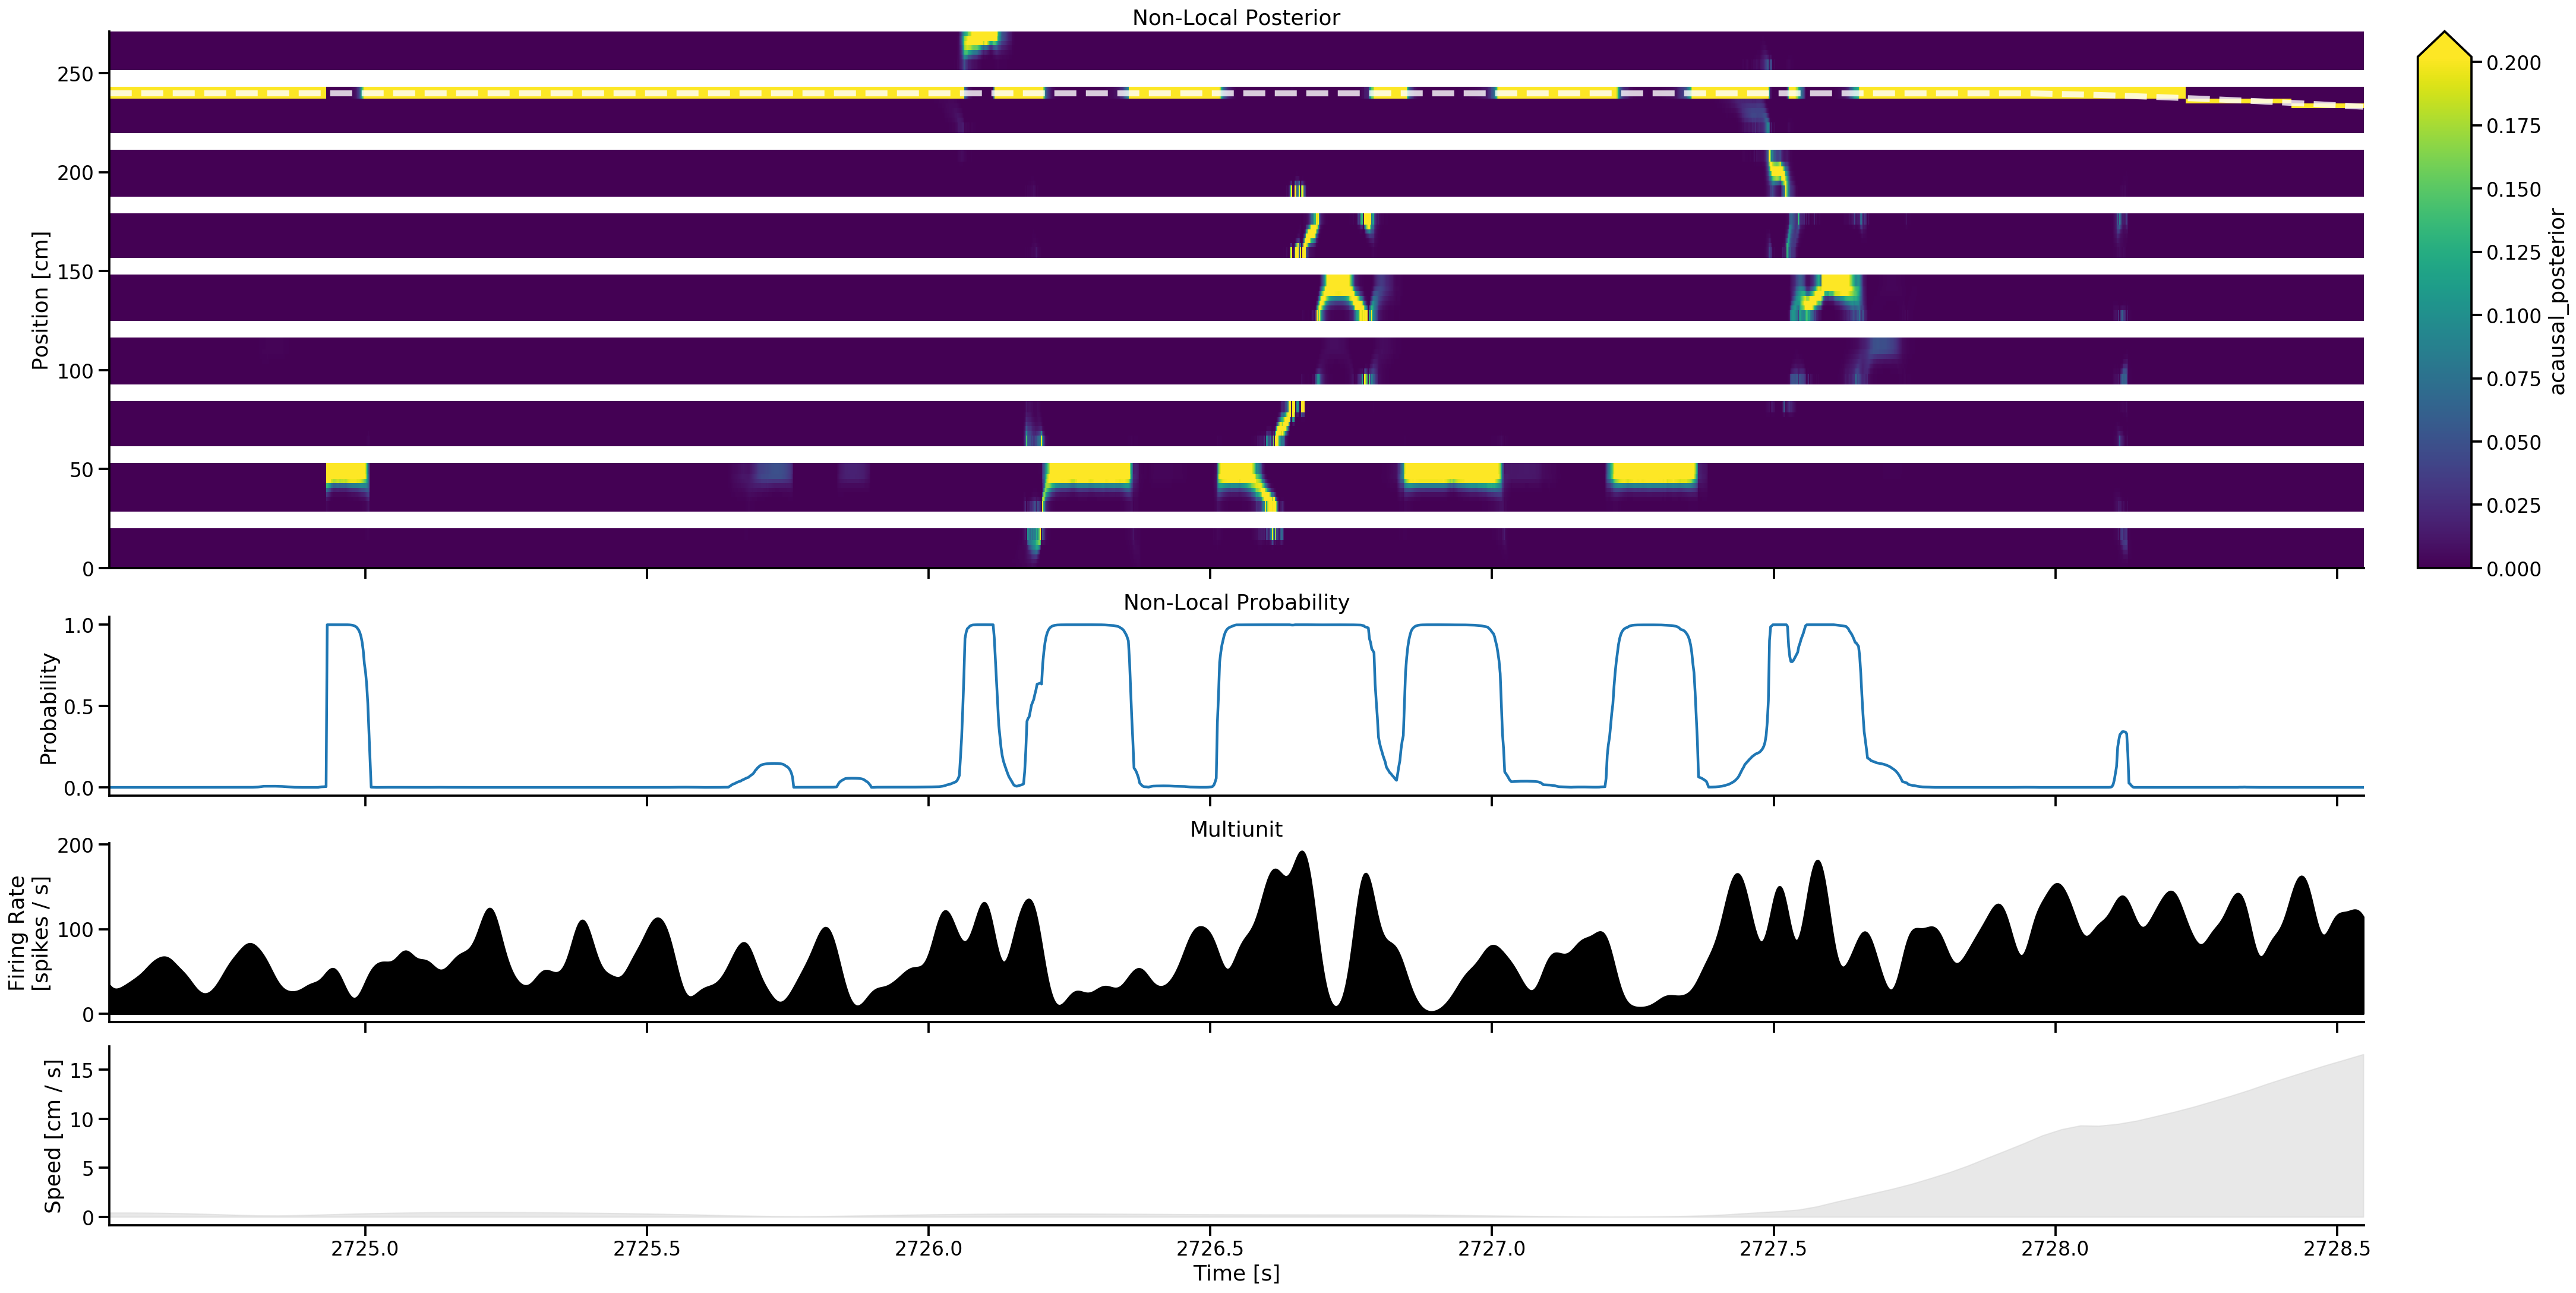

In [51]:
time = cv_classifier_clusterless_results.time.values
time_slice = slice(time[57_000], time[59_000])

plot_local_non_local_time_slice(
    time_slice,
    cv_detector,
    cv_clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

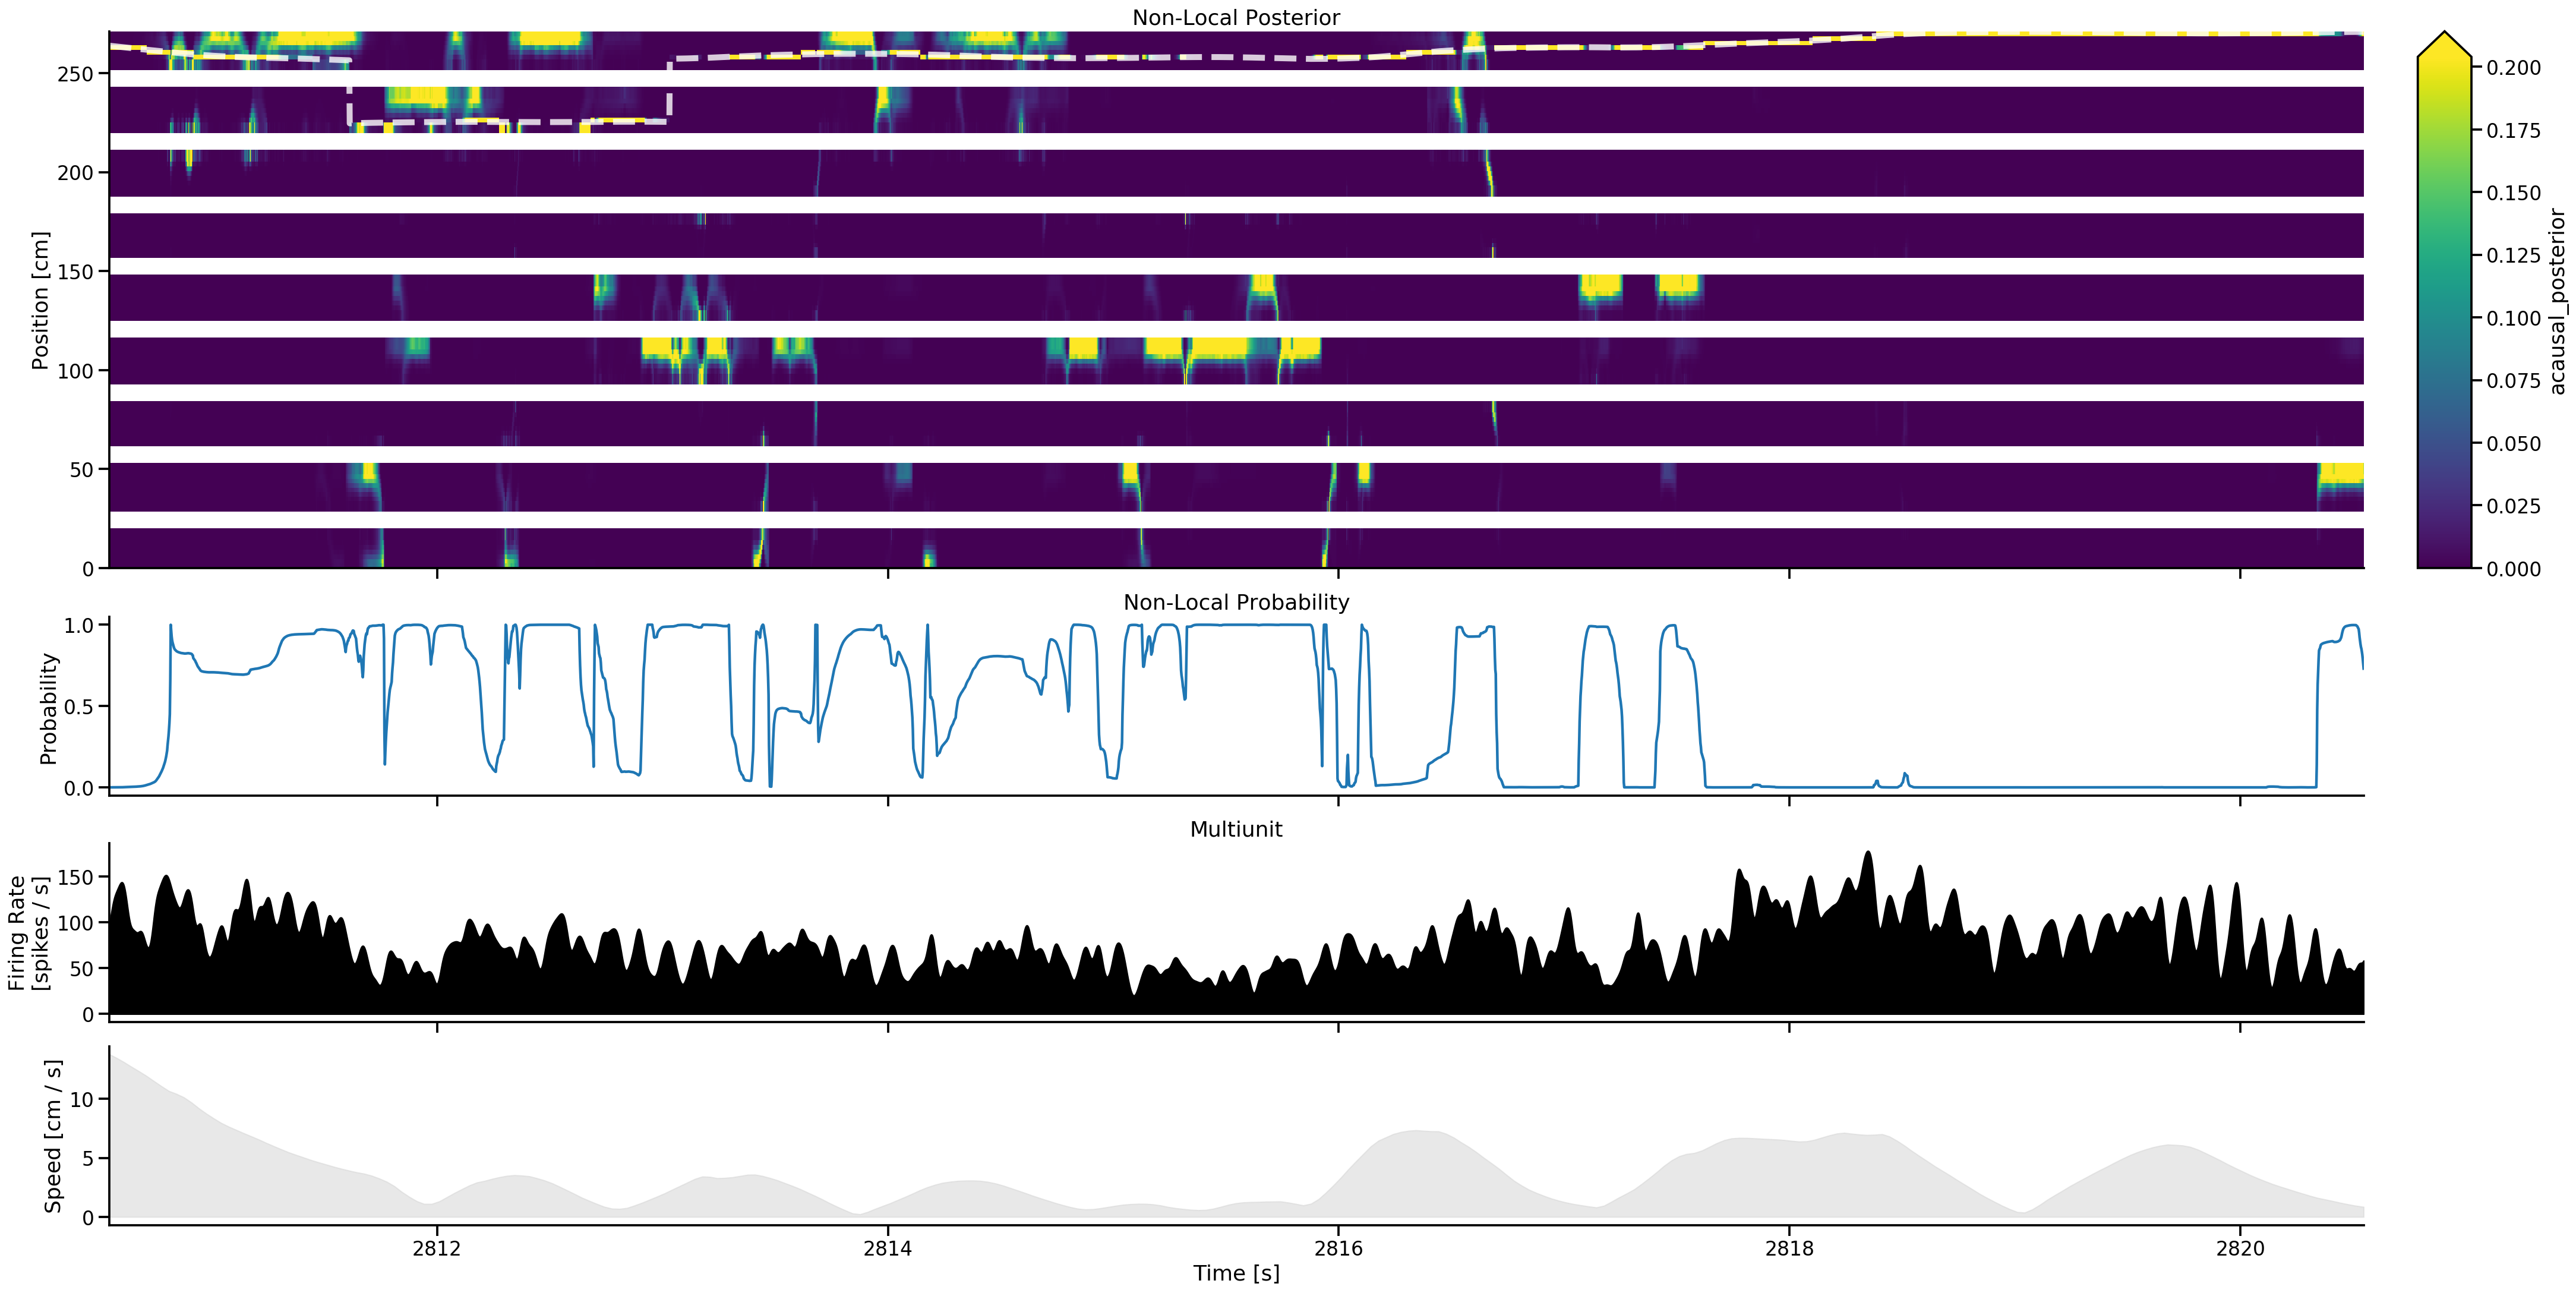

In [56]:
time = cv_classifier_clusterless_results.time.values
time_slice = slice(time[100_000], time[105_000])

plot_local_non_local_time_slice(
    time_slice,
    cv_detector,
    cv_clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

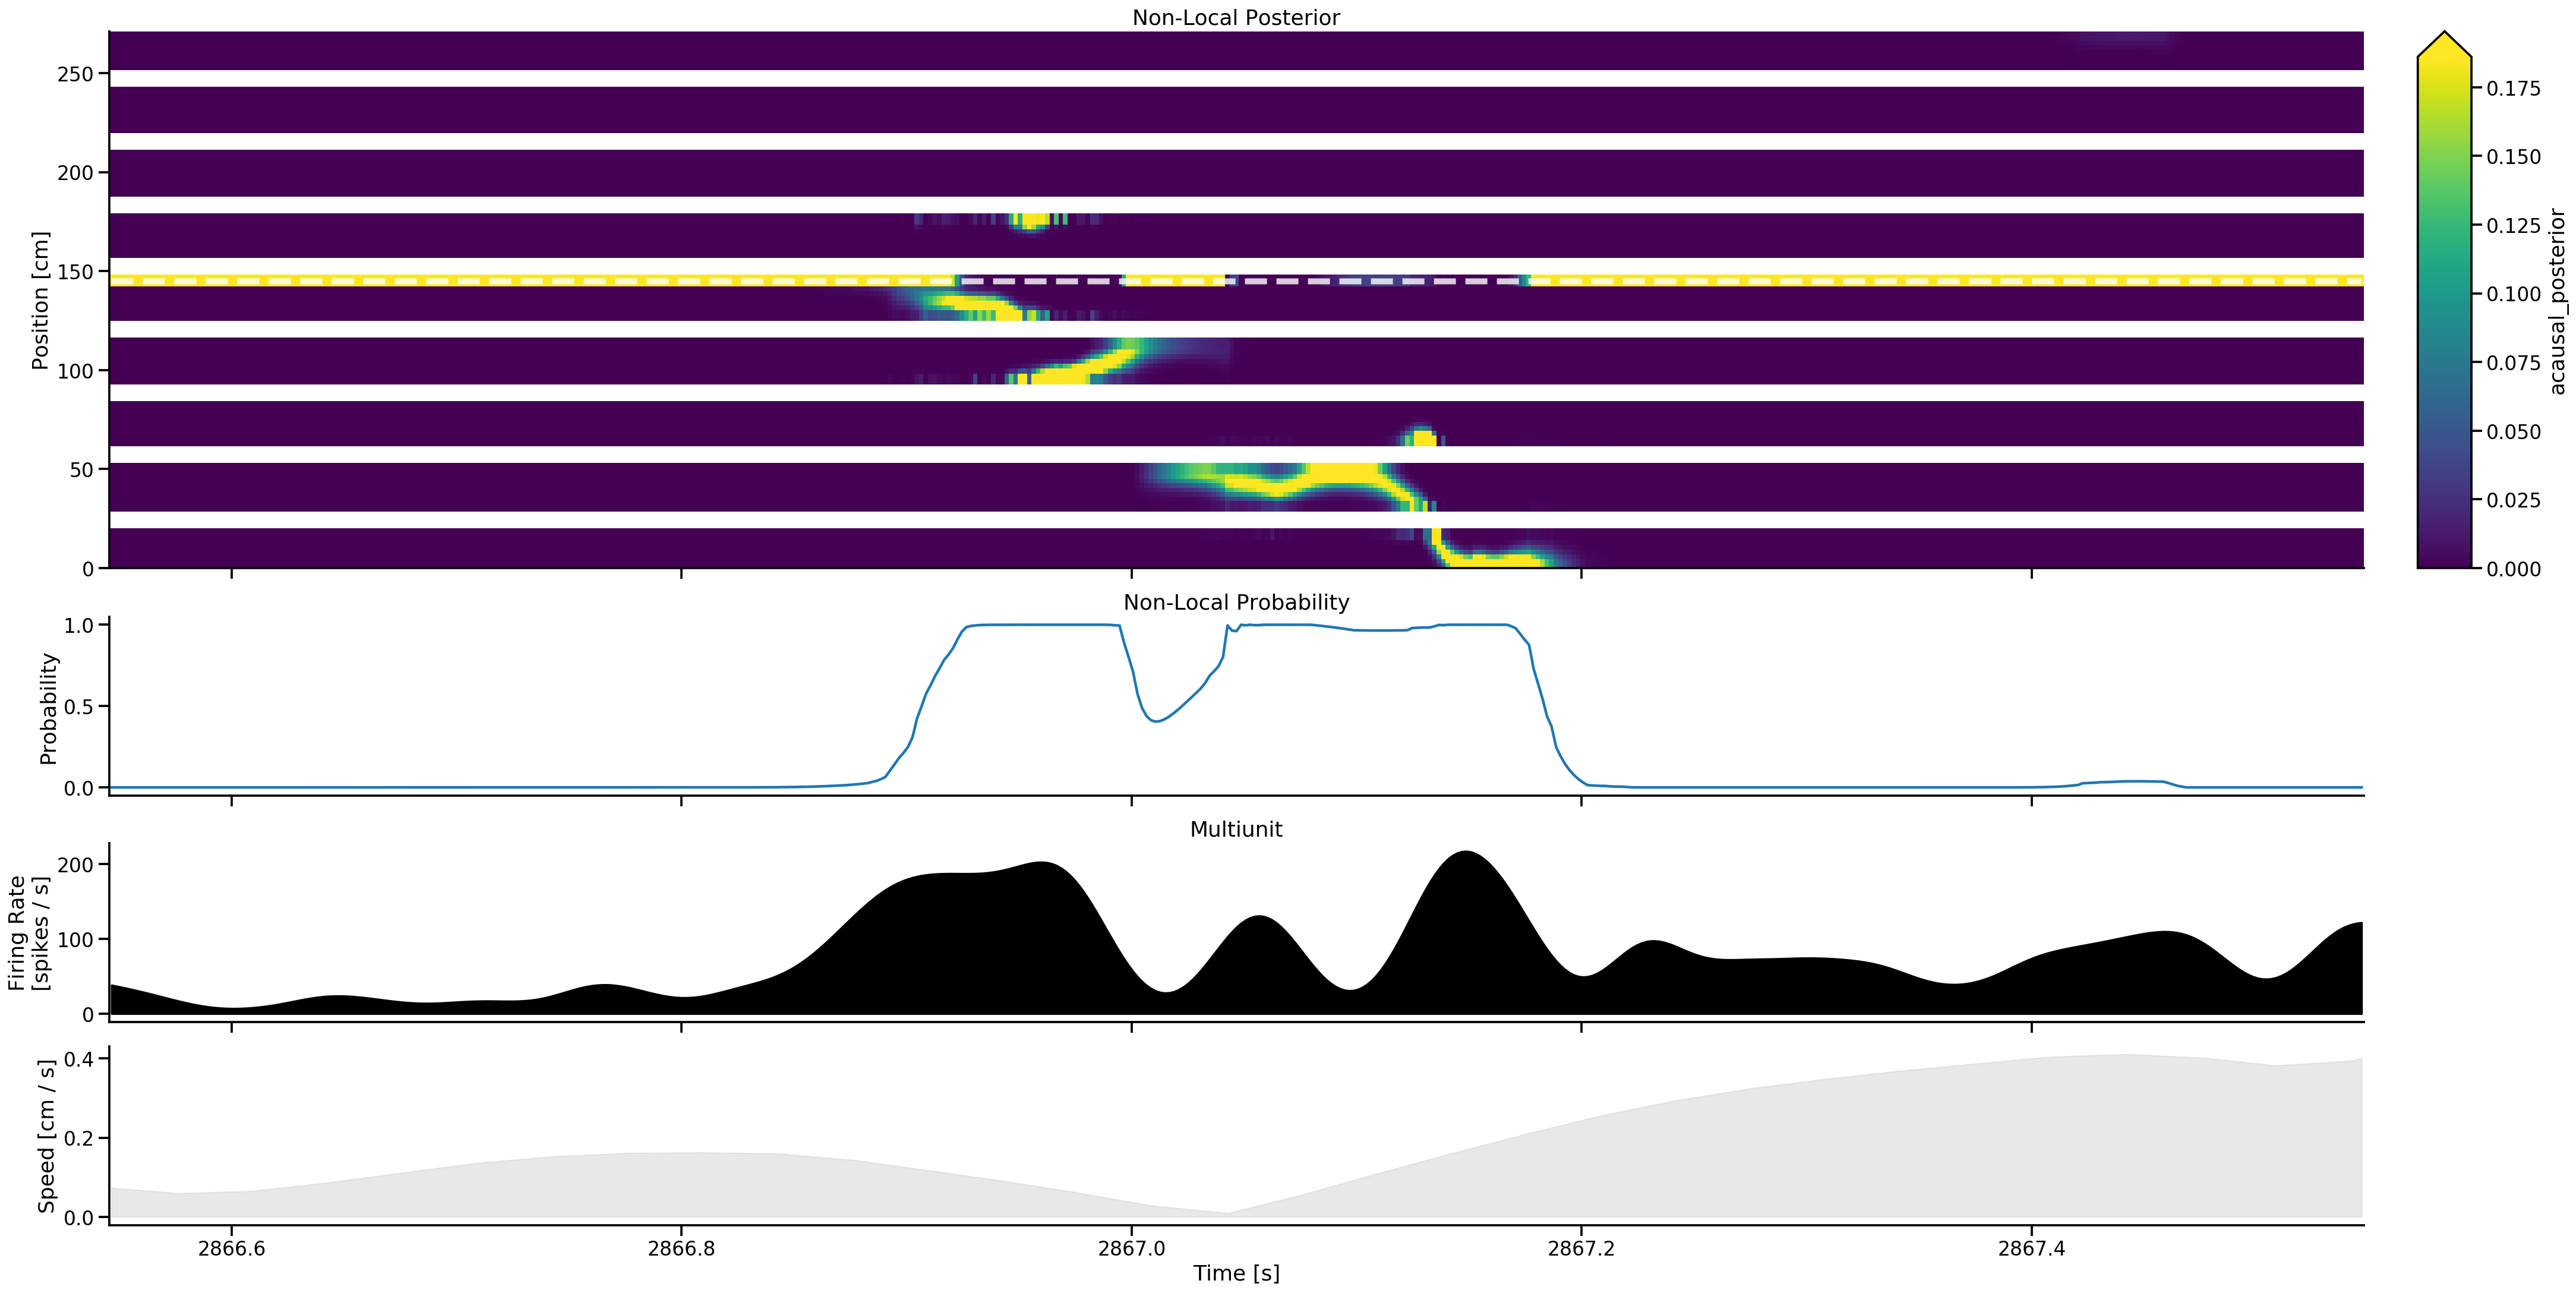

In [62]:
time = cv_classifier_clusterless_results.time.values
time_slice = slice(time[128_000], time[128_500])

plot_local_non_local_time_slice(
    time_slice,
    cv_detector,
    cv_clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

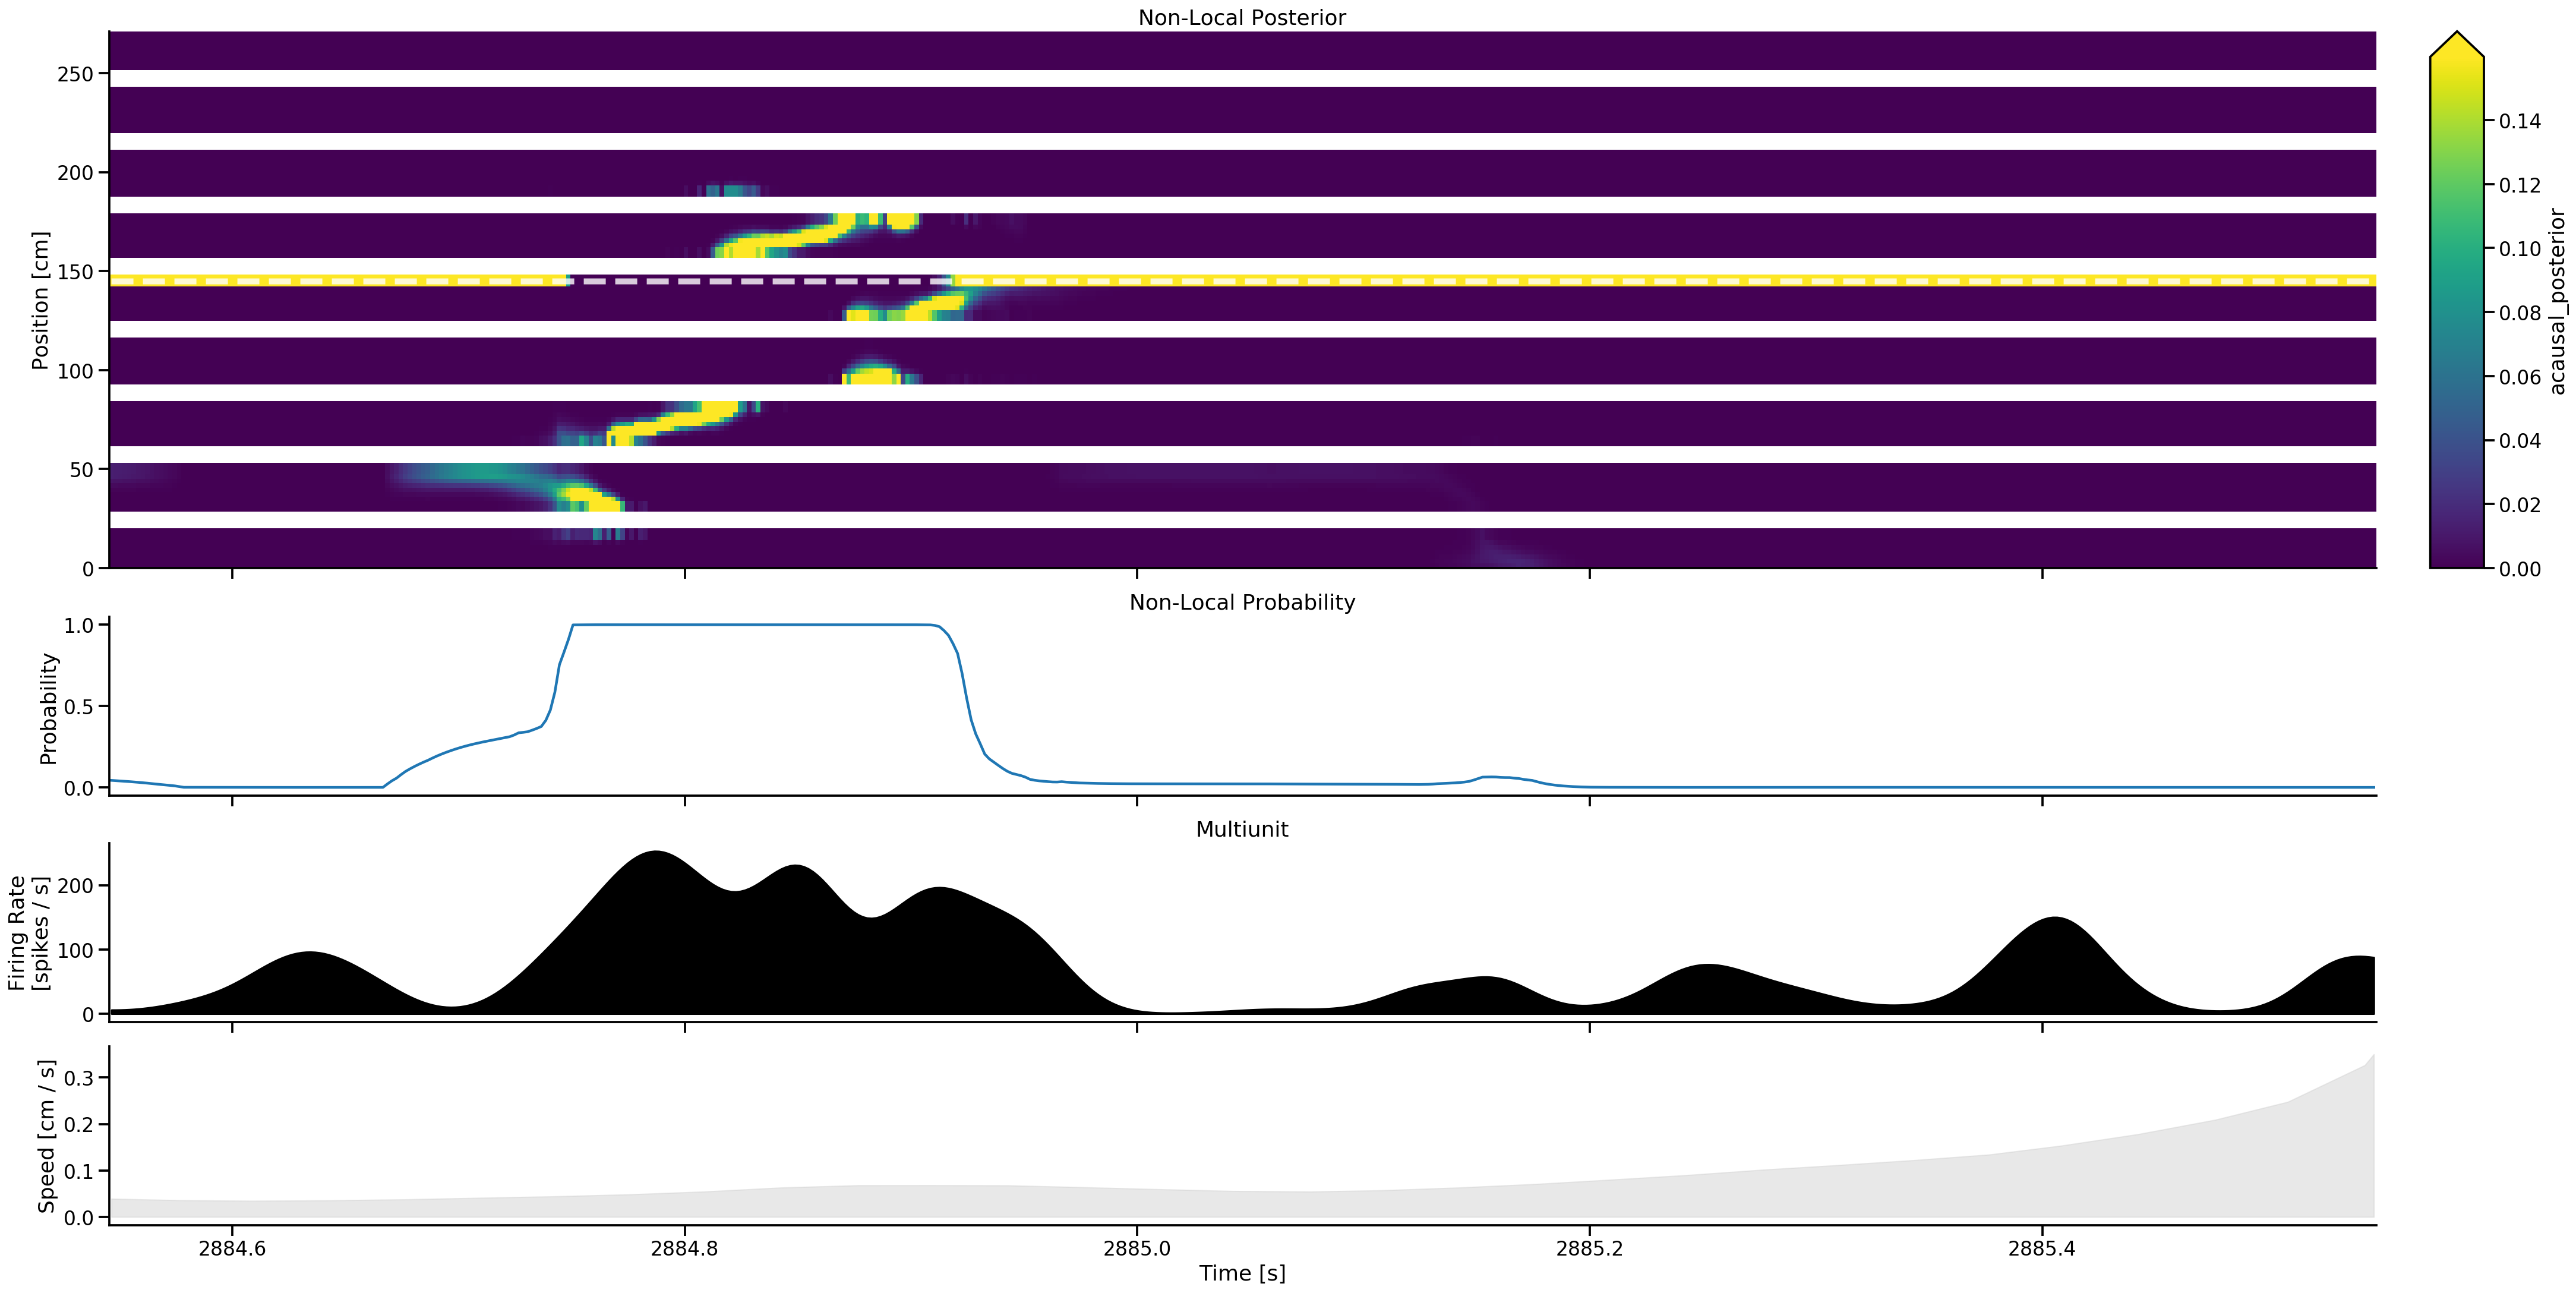

In [67]:
time = cv_classifier_clusterless_results.time.values
time_slice = slice(time[137_000], time[137_500])

plot_local_non_local_time_slice(
    time_slice,
    cv_detector,
    cv_clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

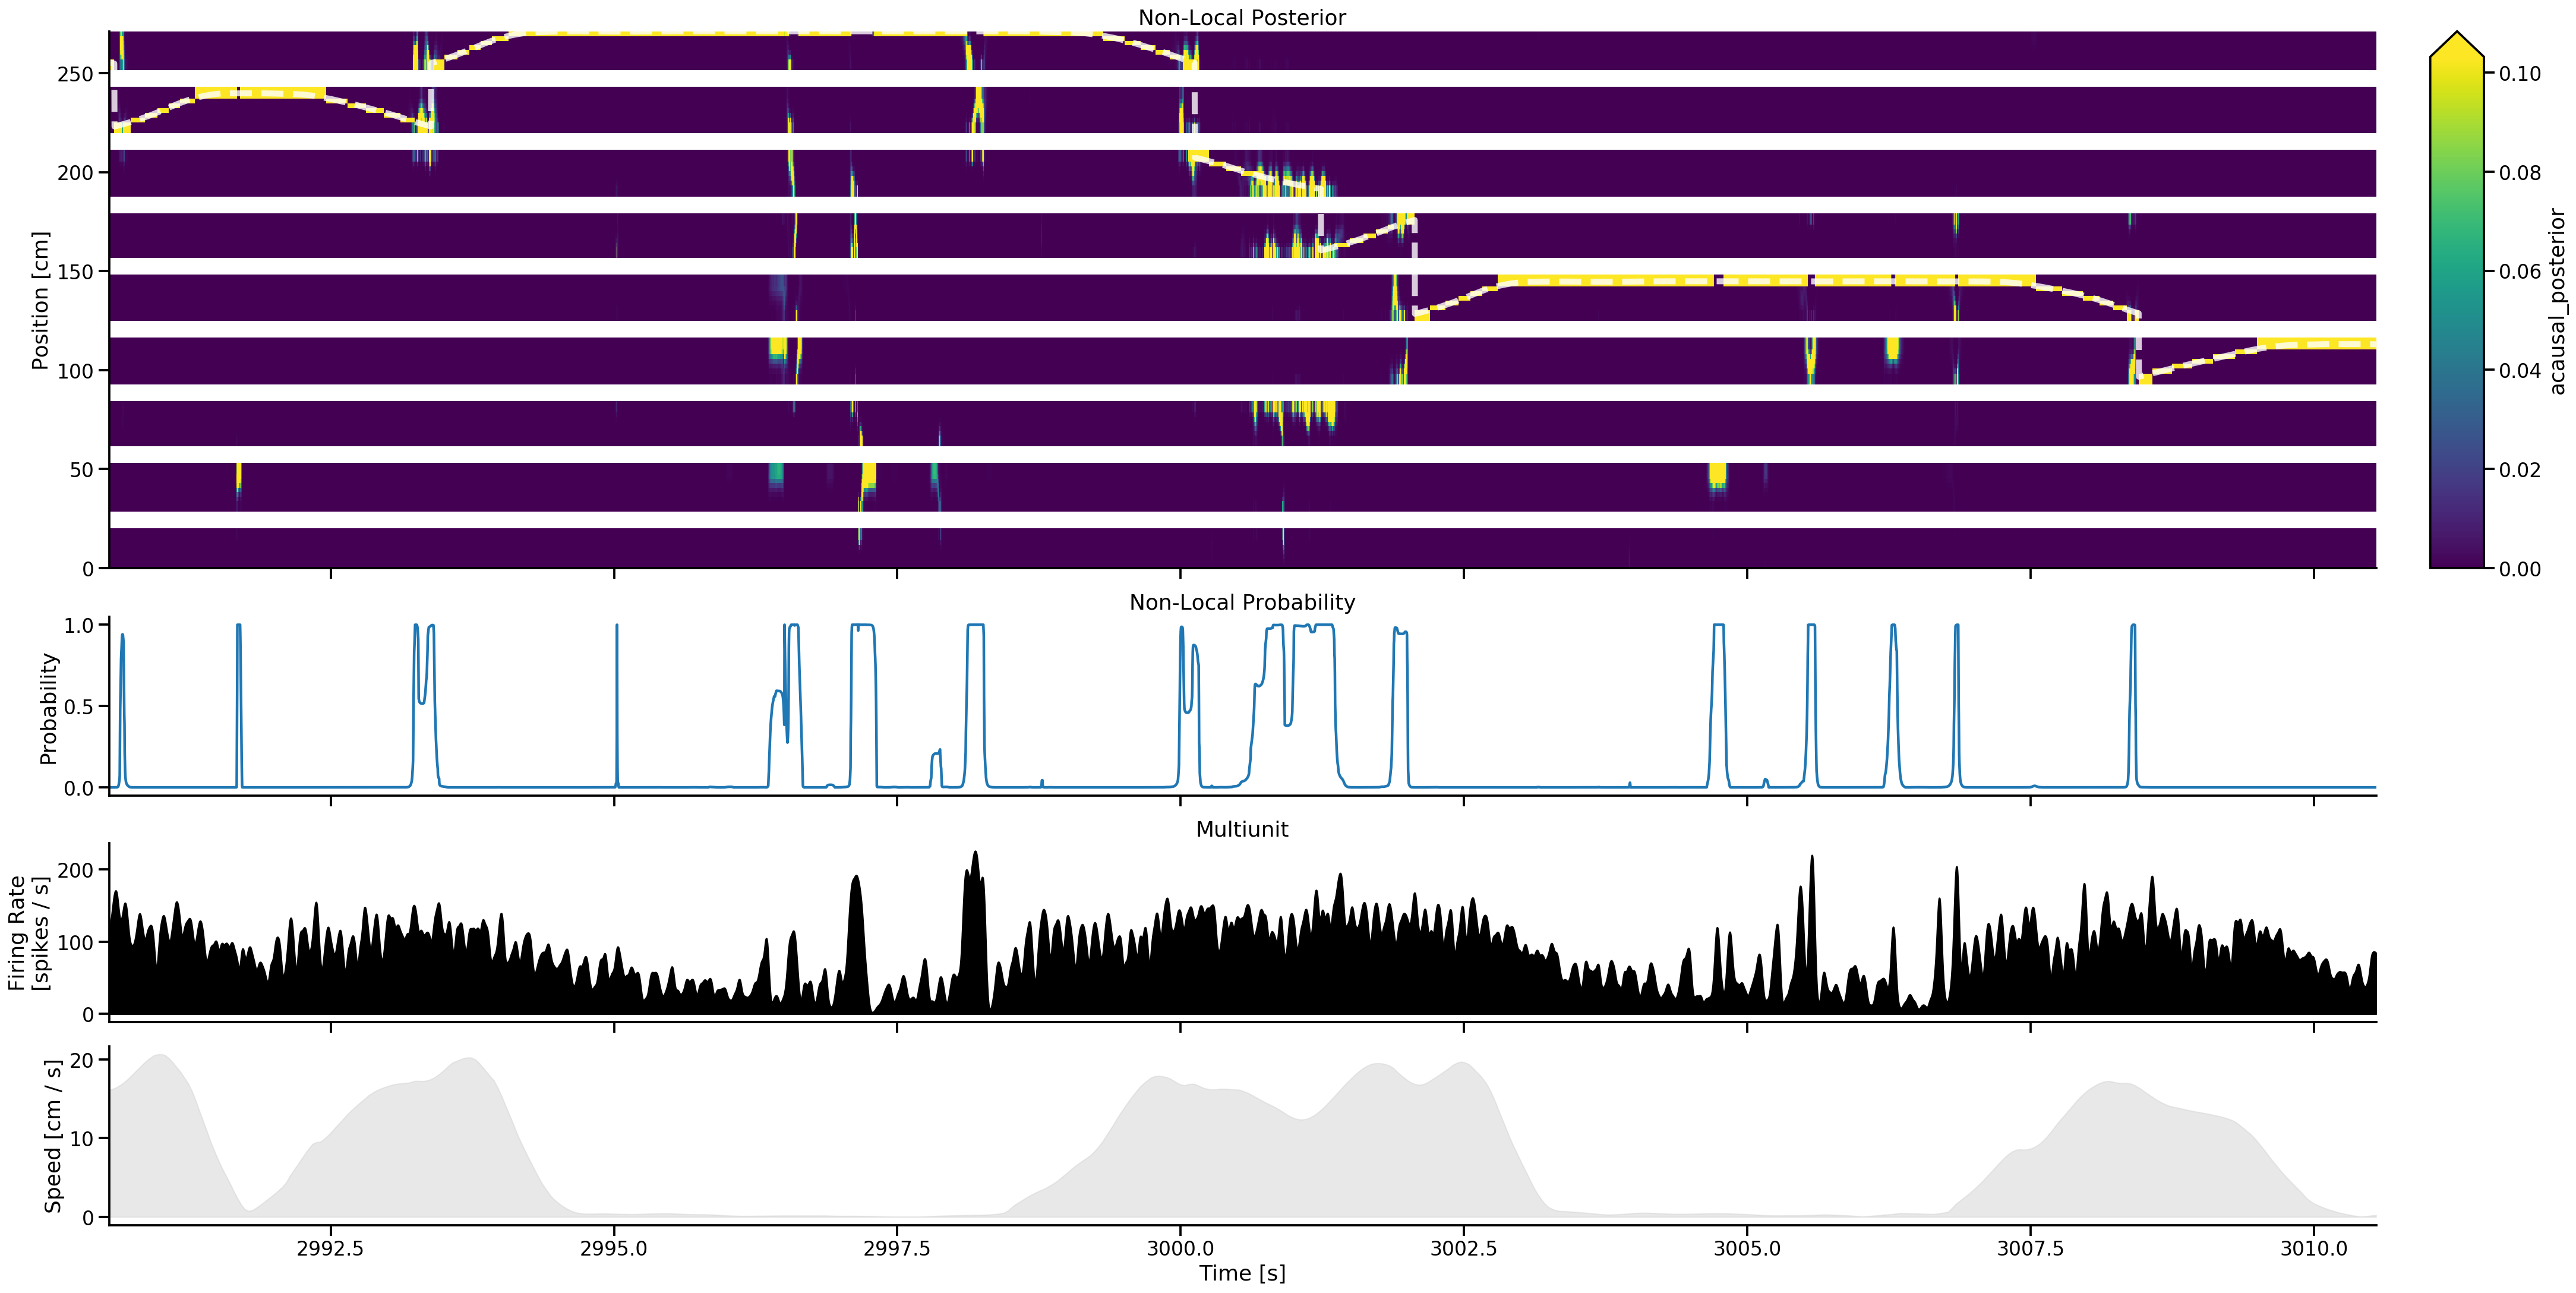

In [77]:
time = cv_classifier_clusterless_results.time.values
time_slice = slice(time[190_000], time[200_000])

plot_local_non_local_time_slice(
    time_slice,
    cv_detector,
    cv_clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

## 2D

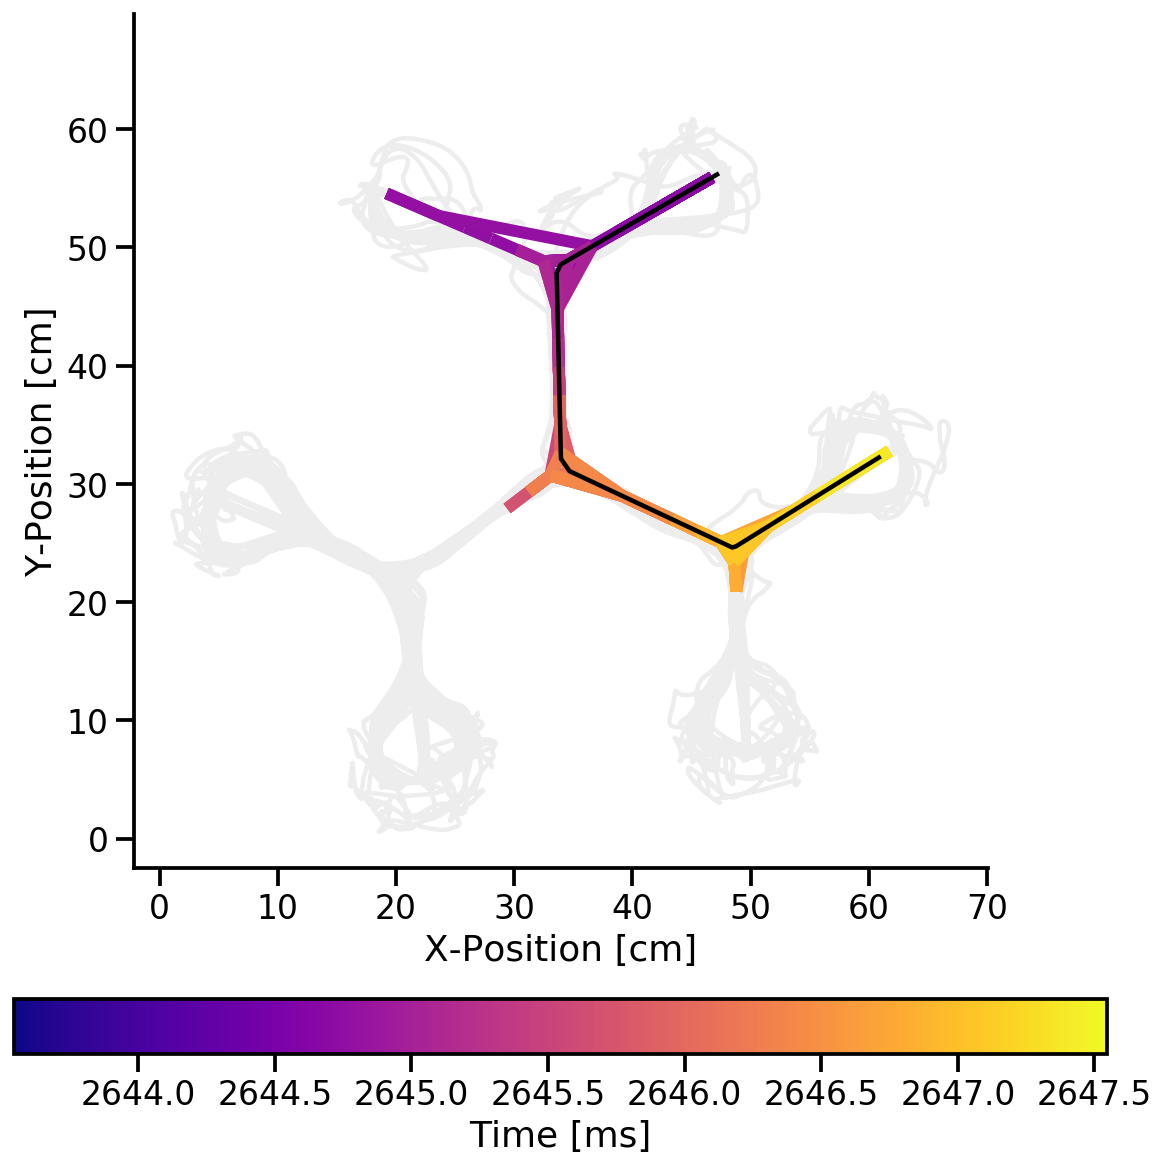

In [26]:
from src.visualization import plot_2D_position_with_color_time
from replay_trajectory_classification.core import get_graph_1D_2D_relationships, linear_position_to_2D_projection
from loren_frank_data_processing.track_segment_classification import get_track_segments_from_graph, project_points_to_segment

time = cv_classifier_clusterless_results.time.values
time_slice = slice(time[16500], time[18500])

(node_linear_position, edges,
 node_2D_position, edge_dist) = get_graph_1D_2D_relationships(
    track_graph, EDGE_ORDER, EDGE_SPACING, center_well_id)

place_bin_centers = cv_classifier.place_bin_centers_.copy()

for edge_ind, sort_ind in enumerate(np.argsort(node_linear_position, axis=1)):
    node_linear_position[edge_ind] = node_linear_position[edge_ind, sort_ind]
    node_2D_position[edge_ind] = node_2D_position[edge_ind, sort_ind]

place_bin_center_2D_position = np.stack([
        linear_position_to_2D_projection(
            center, node_linear_position, edge_dist, node_2D_position)[0]
        for center in place_bin_centers])


# Plot 2
t = data["position_info"].index / np.timedelta64(1, "s")

map_position_ind = (
    cv_classifier_clusterless_results.sel(time=time_slice).sum("state").acausal_posterior.argmax("position").values
)
map_position_2d = place_bin_center_2D_position[map_position_ind]
position_2d = data["position_info"].loc[:, ["x_position", "y_position"]]

fig, ax = plt.subplots(
    1, 1, figsize=(8, 8), constrained_layout=True
)
ax.plot(
    position_2d.values[:, 0],
    position_2d.values[:, 1],
    color="lightgrey",
    alpha=0.4,
    zorder=1,
)
cur_position_1D = data['position_info'].set_index(t).loc[time_slice, ['linear_position']].values.squeeze()
cur_position_2D = data['position_info'].set_index(t).loc[time_slice, ['x_position', 'y_position']].values.squeeze()
track_segment_id = data['position_info'].set_index(t).loc[time_slice, ['track_segment_id']].values.squeeze().astype(int)

track_segments = get_track_segments_from_graph(track_graph)
projected_track_positions = project_points_to_segment(
    track_segments, cur_position_2D)
n_time = projected_track_positions.shape[0]
projected_track_positions = projected_track_positions[(
    np.arange(n_time), track_segment_id)]

plt.plot(projected_track_positions[:, 0], projected_track_positions[:, 1], color='black', zorder=1002)

_, _, cbar = plot_2D_position_with_color_time(
    cv_classifier_clusterless_results.sel(time=time_slice).time,
    map_position_2d,
    ax=ax,
)
cbar.set_label("Time [ms]")

ax.set_xlabel("X-Position [cm]")

ax.set_ylabel("Y-Position [cm]")
ax.axis("square")

sns.despine()

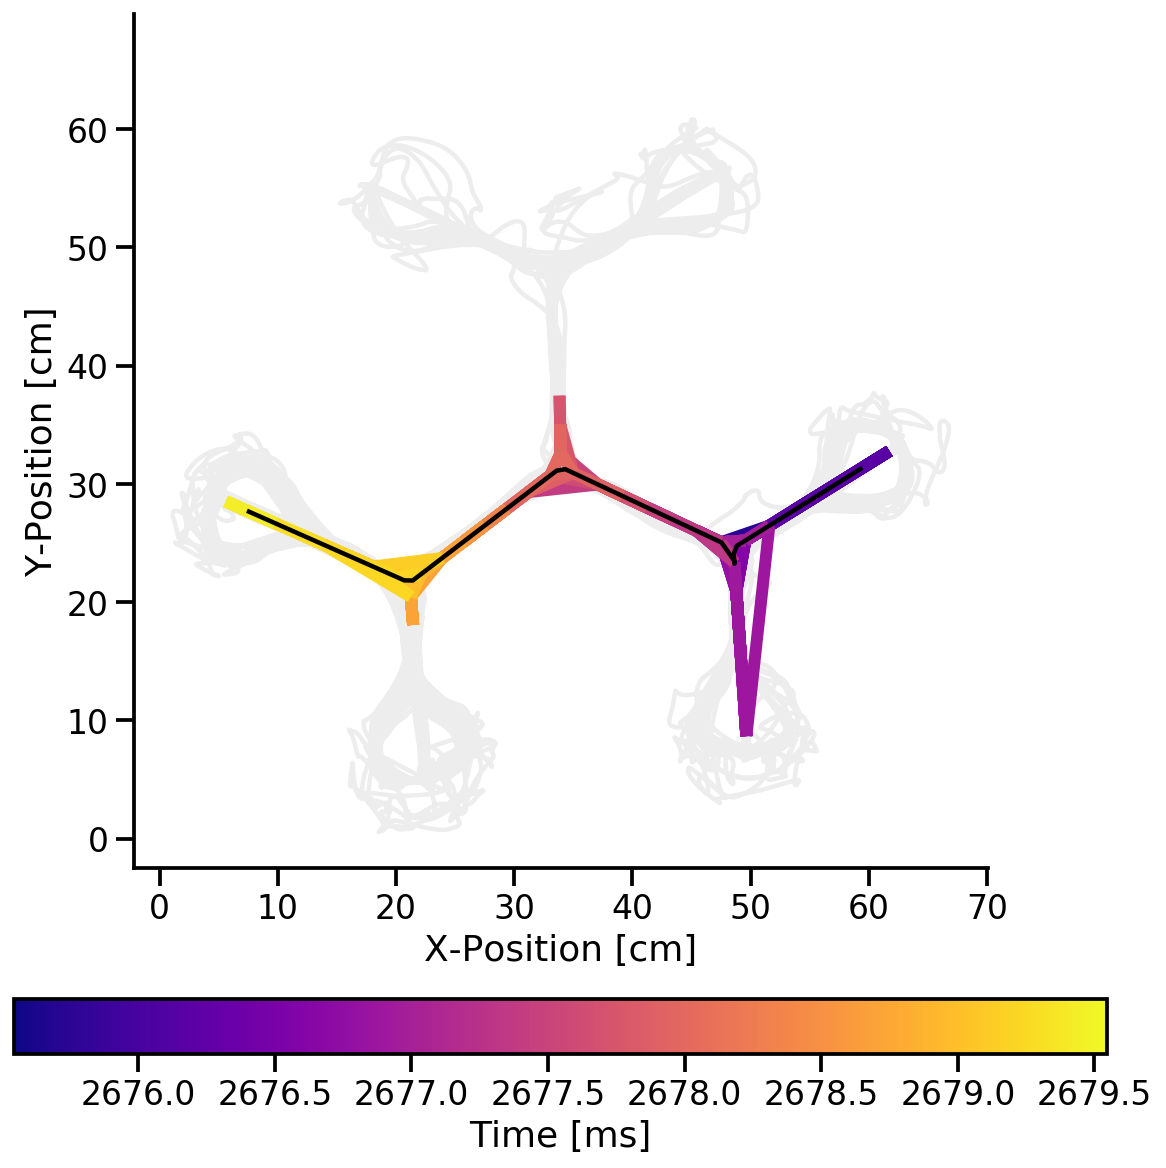

In [27]:
from src.visualization import plot_2D_position_with_color_time
from replay_trajectory_classification.core import get_graph_1D_2D_relationships, linear_position_to_2D_projection

time = cv_classifier_clusterless_results.time.values

time_slice = slice(time[32500], time[34500])
# time_slice = slice(time[48500], time[50500])
# time_slice = slice(time[830700], time[832700])

(node_linear_position, edges,
 node_2D_position, edge_dist) = get_graph_1D_2D_relationships(
    track_graph, EDGE_ORDER, EDGE_SPACING, center_well_id)

place_bin_centers = cv_classifier.place_bin_centers_.copy()

for edge_ind, sort_ind in enumerate(np.argsort(node_linear_position, axis=1)):
    node_linear_position[edge_ind] = node_linear_position[edge_ind, sort_ind]
    node_2D_position[edge_ind] = node_2D_position[edge_ind, sort_ind]

place_bin_center_2D_position = np.stack([
        linear_position_to_2D_projection(
            center, node_linear_position, edge_dist, node_2D_position)[0]
        for center in place_bin_centers])


# Plot 2
t = data["position_info"].index / np.timedelta64(1, "s")

map_position_ind = (
    cv_classifier_clusterless_results.sel(time=time_slice).sum("state").acausal_posterior.argmax("position").values
)
map_position_2d = place_bin_center_2D_position[map_position_ind]
position_2d = data["position_info"].loc[:, ["x_position", "y_position"]]

fig, ax = plt.subplots(
    1, 1, figsize=(8, 8), constrained_layout=True
)
ax.plot(
    position_2d.values[:, 0],
    position_2d.values[:, 1],
    color="lightgrey",
    alpha=0.4,
    zorder=1,
)
cur_position_1D = data['position_info'].set_index(t).loc[time_slice, ['linear_position']].values.squeeze()
cur_position_2D = data['position_info'].set_index(t).loc[time_slice, ['x_position', 'y_position']].values.squeeze()
track_segment_id = data['position_info'].set_index(t).loc[time_slice, ['track_segment_id']].values.squeeze().astype(int)

track_segments = get_track_segments_from_graph(track_graph)
projected_track_positions = project_points_to_segment(
    track_segments, cur_position_2D)
n_time = projected_track_positions.shape[0]
projected_track_positions = projected_track_positions[(
    np.arange(n_time), track_segment_id)]

plt.plot(projected_track_positions[:, 0], projected_track_positions[:, 1], color='black', zorder=1002)

_, _, cbar = plot_2D_position_with_color_time(
    cv_classifier_clusterless_results.sel(time=time_slice).time,
    map_position_2d,
    ax=ax,
)
cbar.set_label("Time [ms]")

ax.set_xlabel("X-Position [cm]")

ax.set_ylabel("Y-Position [cm]")
ax.axis("square")

sns.despine()

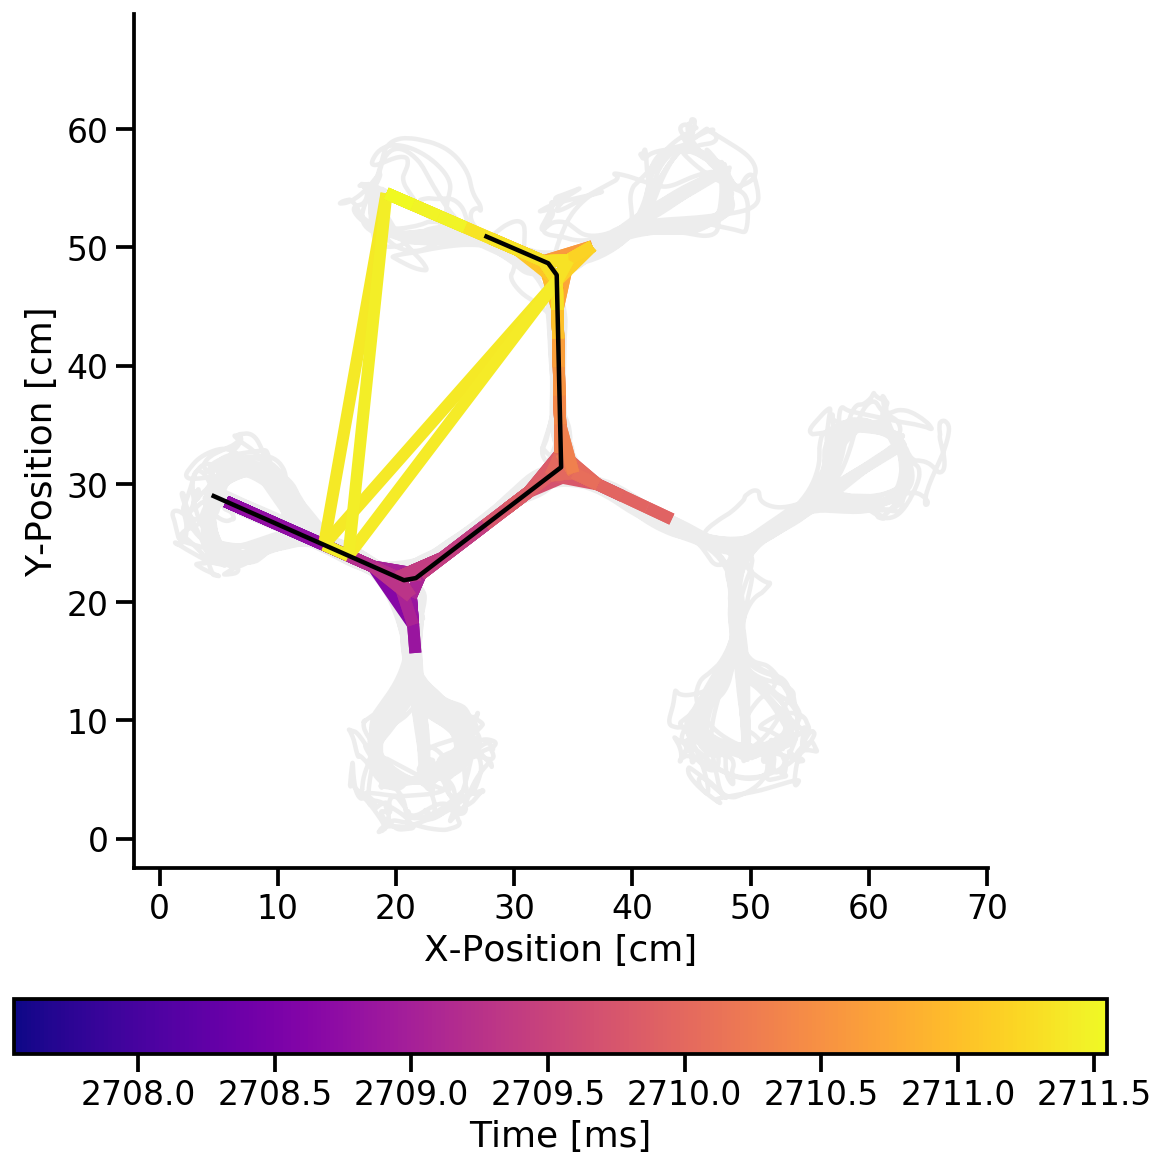

In [28]:
from src.visualization import plot_2D_position_with_color_time
from replay_trajectory_classification.core import get_graph_1D_2D_relationships, linear_position_to_2D_projection

time = cv_classifier_clusterless_results.time.values

time_slice = slice(time[48500], time[50500])
# time_slice = slice(time[830700], time[832700])

(node_linear_position, edges,
 node_2D_position, edge_dist) = get_graph_1D_2D_relationships(
    track_graph, EDGE_ORDER, EDGE_SPACING, center_well_id)

place_bin_centers = cv_classifier.place_bin_centers_.copy()

for edge_ind, sort_ind in enumerate(np.argsort(node_linear_position, axis=1)):
    node_linear_position[edge_ind] = node_linear_position[edge_ind, sort_ind]
    node_2D_position[edge_ind] = node_2D_position[edge_ind, sort_ind]

place_bin_center_2D_position = np.stack([
        linear_position_to_2D_projection(
            center, node_linear_position, edge_dist, node_2D_position)[0]
        for center in place_bin_centers])


# Plot 2
t = data["position_info"].index / np.timedelta64(1, "s")

map_position_ind = (
    cv_classifier_clusterless_results.sel(time=time_slice).sum("state").acausal_posterior.argmax("position").values
)
map_position_2d = place_bin_center_2D_position[map_position_ind]
position_2d = data["position_info"].loc[:, ["x_position", "y_position"]]

fig, ax = plt.subplots(
    1, 1, figsize=(8, 8), constrained_layout=True
)
ax.plot(
    position_2d.values[:, 0],
    position_2d.values[:, 1],
    color="lightgrey",
    alpha=0.4,
    zorder=1,
)
cur_position_1D = data['position_info'].set_index(t).loc[time_slice, ['linear_position']].values.squeeze()
cur_position_2D = data['position_info'].set_index(t).loc[time_slice, ['x_position', 'y_position']].values.squeeze()
track_segment_id = data['position_info'].set_index(t).loc[time_slice, ['track_segment_id']].values.squeeze().astype(int)

track_segments = get_track_segments_from_graph(track_graph)
projected_track_positions = project_points_to_segment(
    track_segments, cur_position_2D)
n_time = projected_track_positions.shape[0]
projected_track_positions = projected_track_positions[(
    np.arange(n_time), track_segment_id)]

plt.plot(projected_track_positions[:, 0], projected_track_positions[:, 1], color='black', zorder=1002)

_, _, cbar = plot_2D_position_with_color_time(
    cv_classifier_clusterless_results.sel(time=time_slice).time,
    map_position_2d,
    ax=ax,
)
cbar.set_label("Time [ms]")

ax.set_xlabel("X-Position [cm]")

ax.set_ylabel("Y-Position [cm]")
ax.axis("square")

sns.despine()

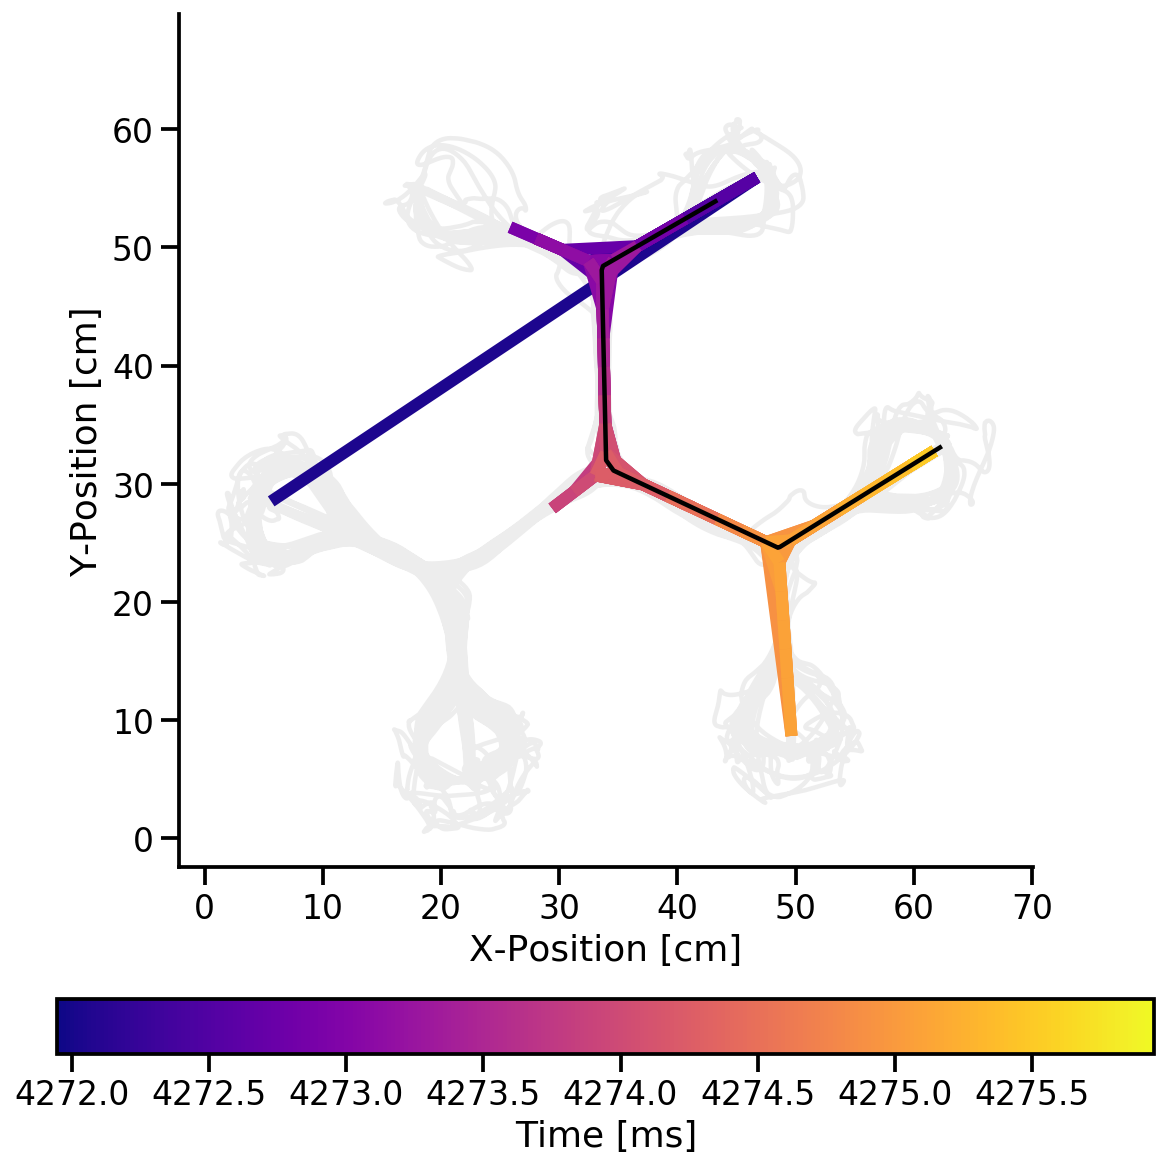

In [29]:
from src.visualization import plot_2D_position_with_color_time
from replay_trajectory_classification.core import get_graph_1D_2D_relationships, linear_position_to_2D_projection

time = cv_classifier_clusterless_results.time.values
time_slice = slice(time[830700], time[832700])

(node_linear_position, edges,
 node_2D_position, edge_dist) = get_graph_1D_2D_relationships(
    track_graph, EDGE_ORDER, EDGE_SPACING, center_well_id)

place_bin_centers = cv_classifier.place_bin_centers_.copy()

for edge_ind, sort_ind in enumerate(np.argsort(node_linear_position, axis=1)):
    node_linear_position[edge_ind] = node_linear_position[edge_ind, sort_ind]
    node_2D_position[edge_ind] = node_2D_position[edge_ind, sort_ind]

place_bin_center_2D_position = np.stack([
        linear_position_to_2D_projection(
            center, node_linear_position, edge_dist, node_2D_position)[0]
        for center in place_bin_centers])


# Plot 2
t = data["position_info"].index / np.timedelta64(1, "s")

map_position_ind = (
    cv_classifier_clusterless_results.sel(time=time_slice).sum("state").acausal_posterior.argmax("position").values
)
map_position_2d = place_bin_center_2D_position[map_position_ind]
position_2d = data["position_info"].loc[:, ["x_position", "y_position"]]

fig, ax = plt.subplots(
    1, 1, figsize=(8, 8), constrained_layout=True
)
ax.plot(
    position_2d.values[:, 0],
    position_2d.values[:, 1],
    color="lightgrey",
    alpha=0.4,
    zorder=1,
)
cur_position_1D = data['position_info'].set_index(t).loc[time_slice, ['linear_position']].values.squeeze()
cur_position_2D = data['position_info'].set_index(t).loc[time_slice, ['x_position', 'y_position']].values.squeeze()
track_segment_id = data['position_info'].set_index(t).loc[time_slice, ['track_segment_id']].values.squeeze().astype(int)

track_segments = get_track_segments_from_graph(track_graph)
projected_track_positions = project_points_to_segment(
    track_segments, cur_position_2D)
n_time = projected_track_positions.shape[0]
projected_track_positions = projected_track_positions[(
    np.arange(n_time), track_segment_id)]

plt.plot(projected_track_positions[:, 0], projected_track_positions[:, 1], color='black', zorder=1002)

_, _, cbar = plot_2D_position_with_color_time(
    cv_classifier_clusterless_results.sel(time=time_slice).time,
    map_position_2d,
    ax=ax,
)
cbar.set_label("Time [ms]")

ax.set_xlabel("X-Position [cm]")

ax.set_ylabel("Y-Position [cm]")
ax.axis("square")

sns.despine()

## Movie

In [ ]:
from src.visualization import plot_2D_position_with_color_time, make_movie
from replay_trajectory_classification.core import get_graph_1D_2D_relationships, linear_position_to_2D_projection
from loren_frank_data_processing.track_segment_classification import get_track_segments_from_graph, project_points_to_segment
from src.parameters import SAMPLING_FREQUENCY


frame_rate = SAMPLING_FREQUENCY / 4
time = cv_classifier_clusterless_results.time.values
time_slice = slice(time[16500], time[18500])

(node_linear_position, edges,
 node_2D_position, edge_dist) = get_graph_1D_2D_relationships(
    track_graph, EDGE_ORDER, EDGE_SPACING, center_well_id)

place_bin_centers = cv_classifier.place_bin_centers_.copy()

for edge_ind, sort_ind in enumerate(np.argsort(node_linear_position, axis=1)):
    node_linear_position[edge_ind] = node_linear_position[edge_ind, sort_ind]
    node_2D_position[edge_ind] = node_2D_position[edge_ind, sort_ind]

place_bin_center_2D_position = np.stack([
        linear_position_to_2D_projection(
            center, node_linear_position, edge_dist, node_2D_position)[0]
        for center in place_bin_centers])

t = data["position_info"].index / np.timedelta64(1, "s")

map_position_ind = (
    cv_classifier_clusterless_results.sel(time=time_slice).sum("state").acausal_posterior.argmax("position").values
)
map_position_2d = place_bin_center_2D_position[map_position_ind]
cur_position_1D = data['position_info'].set_index(t).loc[time_slice, ['linear_position']].values.squeeze()
cur_position_2D = data['position_info'].set_index(t).loc[time_slice, ['x_position', 'y_position']].values.squeeze()
track_segment_id = data['position_info'].set_index(t).loc[time_slice, ['track_segment_id']].values.squeeze().astype(int)

track_segments = get_track_segments_from_graph(track_graph)
projected_track_positions = project_points_to_segment(
    track_segments, cur_position_2D)
n_time = projected_track_positions.shape[0]
projected_track_positions = projected_track_positions[(
    np.arange(n_time), track_segment_id)]

# 16 seconds
make_movie(projected_track_positions, map_position_2d, data['position_info'], frame_rate=frame_rate, movie_name="theta_sweep1.mp4")
logging.info('Done')

26-Feb-20 12:29:18 Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
26-Feb-20 12:29:18 MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '504x504', '-pix_fmt', 'rgba', '-r', '125.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-b', '1800k', '-metadata', 'artist=Me', '-y', 'theta_sweep2.mp4']
26-Feb-20 12:33:31 Done


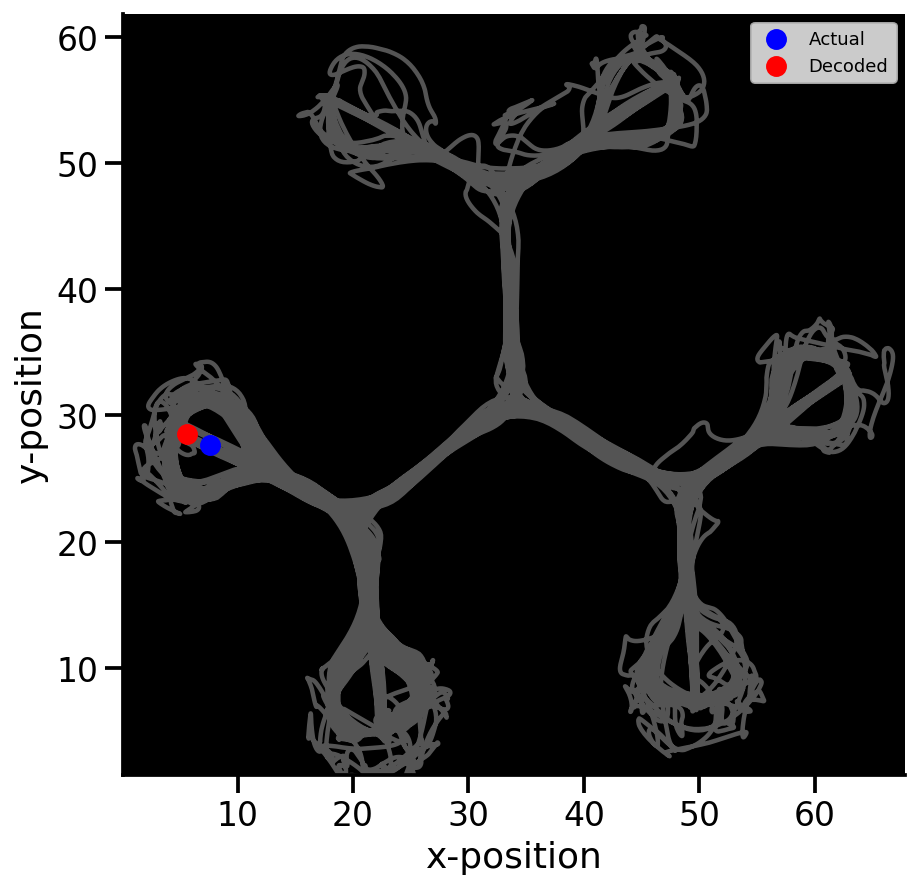

In [91]:
from src.visualization import plot_2D_position_with_color_time
from replay_trajectory_classification.core import get_graph_1D_2D_relationships, linear_position_to_2D_projection

time = cv_classifier_clusterless_results.time.values
time_slice = slice(time[32500], time[34500])

(node_linear_position, edges,
 node_2D_position, edge_dist) = get_graph_1D_2D_relationships(
    track_graph, EDGE_ORDER, EDGE_SPACING, center_well_id)

place_bin_centers = cv_classifier.place_bin_centers_.copy()

for edge_ind, sort_ind in enumerate(np.argsort(node_linear_position, axis=1)):
    node_linear_position[edge_ind] = node_linear_position[edge_ind, sort_ind]
    node_2D_position[edge_ind] = node_2D_position[edge_ind, sort_ind]

place_bin_center_2D_position = np.stack([
        linear_position_to_2D_projection(
            center, node_linear_position, edge_dist, node_2D_position)[0]
        for center in place_bin_centers])

t = data["position_info"].index / np.timedelta64(1, "s")

map_position_ind = (
    cv_classifier_clusterless_results.sel(time=time_slice).sum("state").acausal_posterior.argmax("position").values
)
map_position_2d = place_bin_center_2D_position[map_position_ind]
cur_position_1D = data['position_info'].set_index(t).loc[time_slice, ['linear_position']].values.squeeze()
cur_position_2D = data['position_info'].set_index(t).loc[time_slice, ['x_position', 'y_position']].values.squeeze()
track_segment_id = data['position_info'].set_index(t).loc[time_slice, ['track_segment_id']].values.squeeze().astype(int)

track_segments = get_track_segments_from_graph(track_graph)
projected_track_positions = project_points_to_segment(
    track_segments, cur_position_2D)
n_time = projected_track_positions.shape[0]
projected_track_positions = projected_track_positions[(
    np.arange(n_time), track_segment_id)]


make_movie(projected_track_positions, map_position_2d, data['position_info'], frame_rate=frame_rate, movie_name="theta_sweep2.mp4")
logging.info('Done')

26-Feb-20 12:33:32 Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
26-Feb-20 12:33:32 MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '504x504', '-pix_fmt', 'rgba', '-r', '125.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-b', '1800k', '-metadata', 'artist=Me', '-y', 'theta_sweep3.mp4']
26-Feb-20 12:37:45 Done


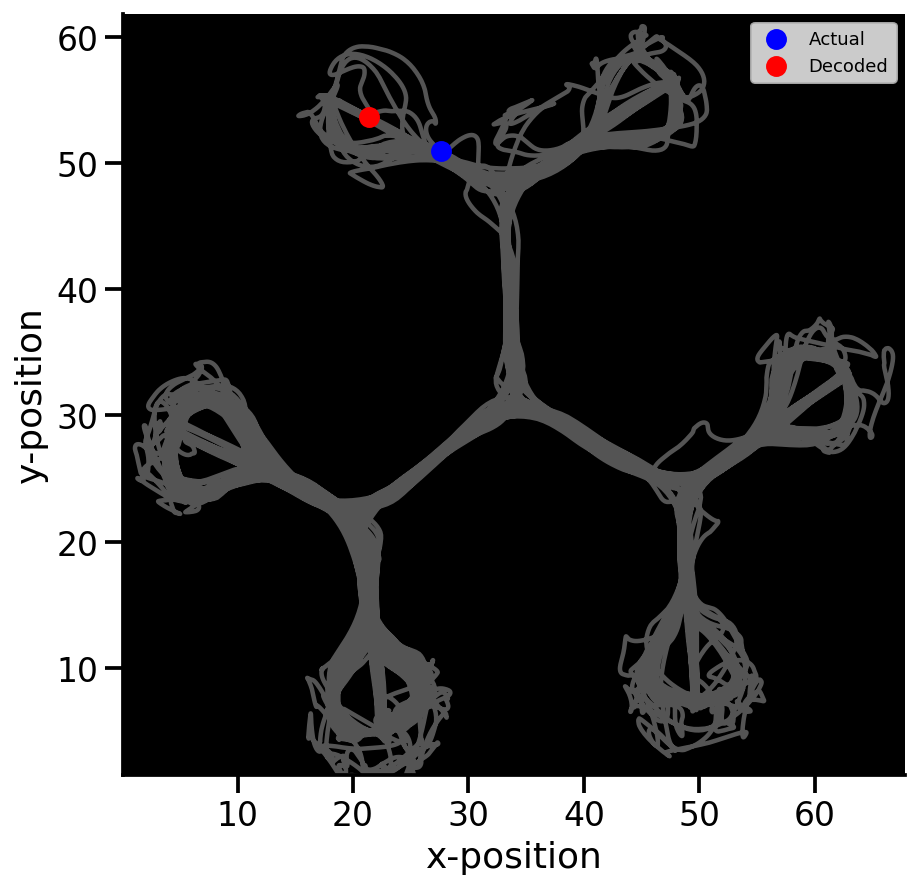

In [92]:
from src.visualization import plot_2D_position_with_color_time
from replay_trajectory_classification.core import get_graph_1D_2D_relationships, linear_position_to_2D_projection

time = cv_classifier_clusterless_results.time.values
time_slice = slice(time[48500], time[50500])

(node_linear_position, edges,
 node_2D_position, edge_dist) = get_graph_1D_2D_relationships(
    track_graph, EDGE_ORDER, EDGE_SPACING, center_well_id)

place_bin_centers = cv_classifier.place_bin_centers_.copy()

for edge_ind, sort_ind in enumerate(np.argsort(node_linear_position, axis=1)):
    node_linear_position[edge_ind] = node_linear_position[edge_ind, sort_ind]
    node_2D_position[edge_ind] = node_2D_position[edge_ind, sort_ind]

place_bin_center_2D_position = np.stack([
        linear_position_to_2D_projection(
            center, node_linear_position, edge_dist, node_2D_position)[0]
        for center in place_bin_centers])

t = data["position_info"].index / np.timedelta64(1, "s")

map_position_ind = (
    cv_classifier_clusterless_results.sel(time=time_slice).sum("state").acausal_posterior.argmax("position").values
)
map_position_2d = place_bin_center_2D_position[map_position_ind]
cur_position_1D = data['position_info'].set_index(t).loc[time_slice, ['linear_position']].values.squeeze()
cur_position_2D = data['position_info'].set_index(t).loc[time_slice, ['x_position', 'y_position']].values.squeeze()
track_segment_id = data['position_info'].set_index(t).loc[time_slice, ['track_segment_id']].values.squeeze().astype(int)

track_segments = get_track_segments_from_graph(track_graph)
projected_track_positions = project_points_to_segment(
    track_segments, cur_position_2D)
n_time = projected_track_positions.shape[0]
projected_track_positions = projected_track_positions[(
    np.arange(n_time), track_segment_id)]

make_movie(projected_track_positions, map_position_2d, data['position_info'], frame_rate=frame_rate, movie_name="theta_sweep3.mp4")
logging.info('Done')

26-Feb-20 12:37:46 Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
26-Feb-20 12:37:46 MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '504x504', '-pix_fmt', 'rgba', '-r', '125.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-b', '1800k', '-metadata', 'artist=Me', '-y', 'theta_sweep4.mp4']
26-Feb-20 12:42:04 Done


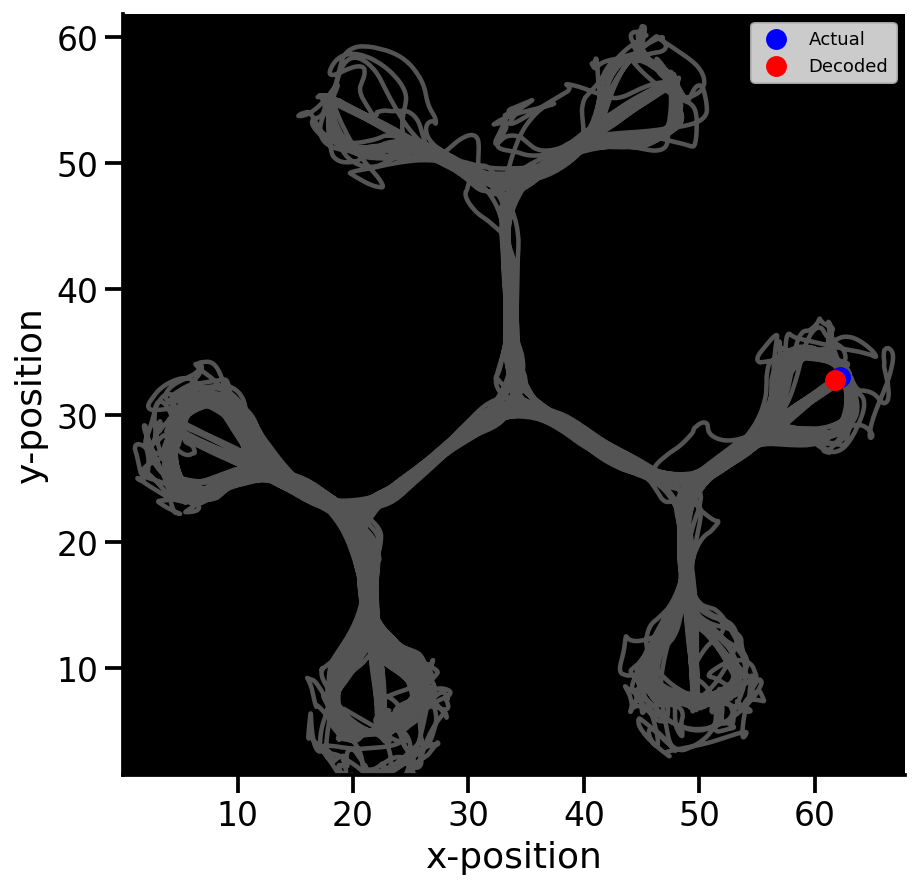

In [93]:
from src.visualization import plot_2D_position_with_color_time
from replay_trajectory_classification.core import get_graph_1D_2D_relationships, linear_position_to_2D_projection

time = cv_classifier_clusterless_results.time.values
time_slice = slice(time[830700], time[832700])


(node_linear_position, edges,
 node_2D_position, edge_dist) = get_graph_1D_2D_relationships(
    track_graph, EDGE_ORDER, EDGE_SPACING, center_well_id)

place_bin_centers = cv_classifier.place_bin_centers_.copy()

for edge_ind, sort_ind in enumerate(np.argsort(node_linear_position, axis=1)):
    node_linear_position[edge_ind] = node_linear_position[edge_ind, sort_ind]
    node_2D_position[edge_ind] = node_2D_position[edge_ind, sort_ind]

place_bin_center_2D_position = np.stack([
        linear_position_to_2D_projection(
            center, node_linear_position, edge_dist, node_2D_position)[0]
        for center in place_bin_centers])

t = data["position_info"].index / np.timedelta64(1, "s")

map_position_ind = (
    cv_classifier_clusterless_results.sel(time=time_slice).sum("state").acausal_posterior.argmax("position").values
)
map_position_2d = place_bin_center_2D_position[map_position_ind]
cur_position_1D = data['position_info'].set_index(t).loc[time_slice, ['linear_position']].values.squeeze()
cur_position_2D = data['position_info'].set_index(t).loc[time_slice, ['x_position', 'y_position']].values.squeeze()
track_segment_id = data['position_info'].set_index(t).loc[time_slice, ['track_segment_id']].values.squeeze().astype(int)

track_segments = get_track_segments_from_graph(track_graph)
projected_track_positions = project_points_to_segment(
    track_segments, cur_position_2D)
n_time = projected_track_positions.shape[0]
projected_track_positions = projected_track_positions[(
    np.arange(n_time), track_segment_id)]

make_movie(projected_track_positions, map_position_2d, data['position_info'], frame_rate=frame_rate, movie_name="theta_sweep4.mp4")
logging.info('Done')

26-Feb-20 12:42:05 Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
26-Feb-20 12:42:05 MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '504x504', '-pix_fmt', 'rgba', '-r', '125.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-b', '1800k', '-metadata', 'artist=Me', '-y', 'theta_sweep5.mp4']
26-Feb-20 12:50:28 Done


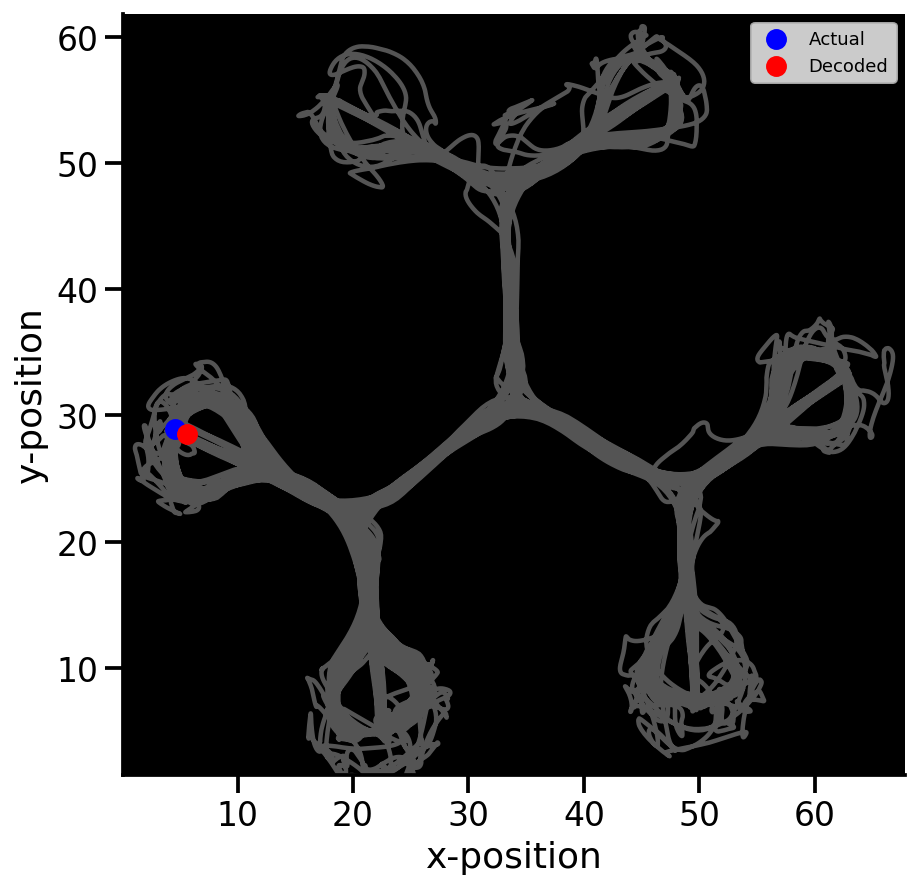

In [94]:
from src.visualization import plot_2D_position_with_color_time
from replay_trajectory_classification.core import get_graph_1D_2D_relationships, linear_position_to_2D_projection

time = cv_classifier_clusterless_results.time.values
time_slice = slice(time[999500], time[1003500])


(node_linear_position, edges,
 node_2D_position, edge_dist) = get_graph_1D_2D_relationships(
    track_graph, EDGE_ORDER, EDGE_SPACING, center_well_id)

place_bin_centers = cv_classifier.place_bin_centers_.copy()

for edge_ind, sort_ind in enumerate(np.argsort(node_linear_position, axis=1)):
    node_linear_position[edge_ind] = node_linear_position[edge_ind, sort_ind]
    node_2D_position[edge_ind] = node_2D_position[edge_ind, sort_ind]

place_bin_center_2D_position = np.stack([
        linear_position_to_2D_projection(
            center, node_linear_position, edge_dist, node_2D_position)[0]
        for center in place_bin_centers])

t = data["position_info"].index / np.timedelta64(1, "s")

map_position_ind = (
    cv_classifier_clusterless_results.sel(time=time_slice).sum("state").acausal_posterior.argmax("position").values
)
map_position_2d = place_bin_center_2D_position[map_position_ind]
cur_position_1D = data['position_info'].set_index(t).loc[time_slice, ['linear_position']].values.squeeze()
cur_position_2D = data['position_info'].set_index(t).loc[time_slice, ['x_position', 'y_position']].values.squeeze()
track_segment_id = data['position_info'].set_index(t).loc[time_slice, ['track_segment_id']].values.squeeze().astype(int)

track_segments = get_track_segments_from_graph(track_graph)
projected_track_positions = project_points_to_segment(
    track_segments, cur_position_2D)
n_time = projected_track_positions.shape[0]
projected_track_positions = projected_track_positions[(
    np.arange(n_time), track_segment_id)]

make_movie(projected_track_positions, map_position_2d, data['position_info'], frame_rate=frame_rate, movie_name="theta_sweep5.mp4")
logging.info('Done')

## Distance from animal's position

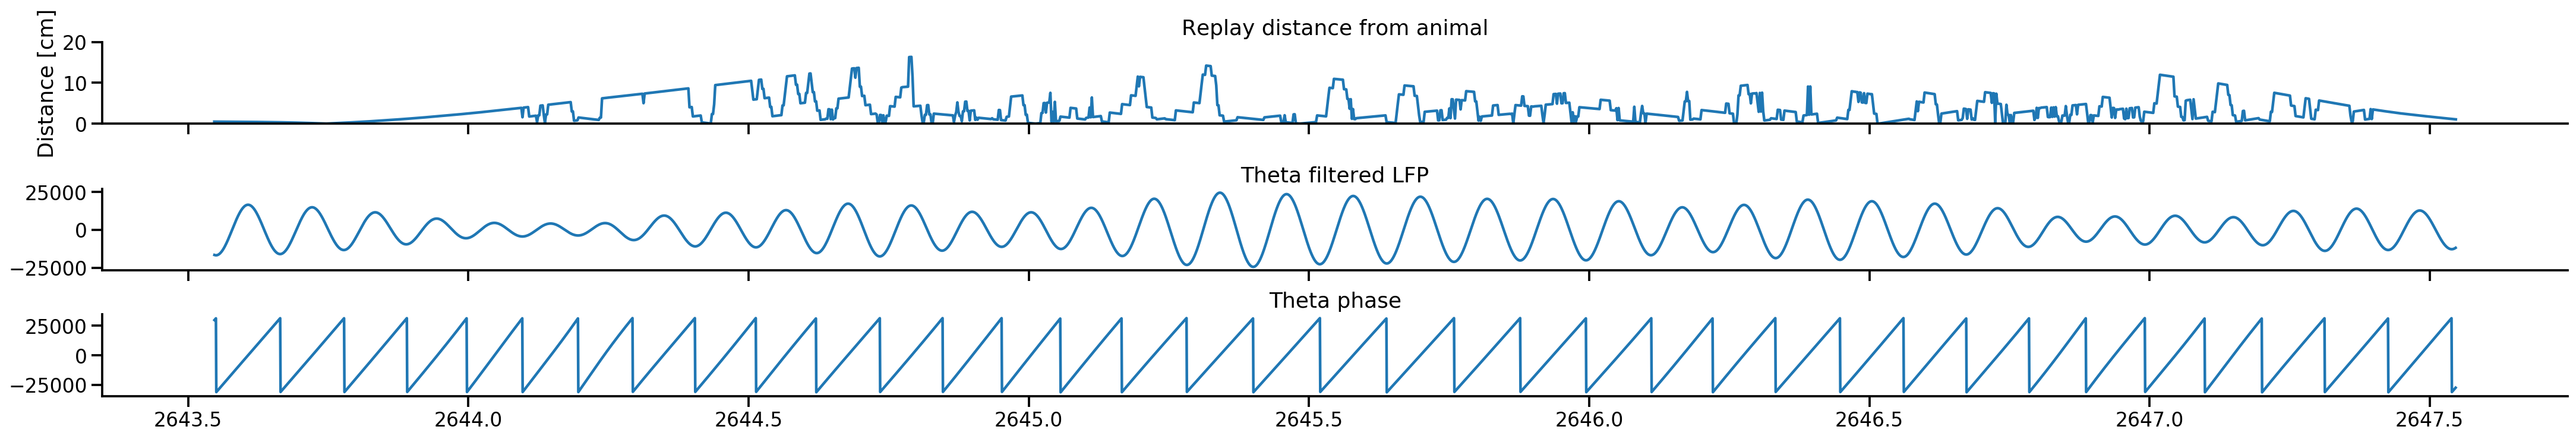

In [126]:
from src.analysis import calculate_replay_distance

time_slice = slice(time[16500], time[18500])

posterior = cv_classifier_clusterless_results.sel(time=time_slice).sum("state").acausal_posterior
track_segment_id = data['position_info'].set_index(t).loc[time_slice, ['track_segment_id']].values.squeeze().astype(int)
cur_position_2D = data['position_info'].set_index(t).loc[time_slice, ['x_position', 'y_position']].values.squeeze()

replay_distance_from_animal_position = calculate_replay_distance(
        posterior, track_graph, cv_classifier, cur_position_2D, track_segment_id)

theta = data['theta'].set_index(data['theta'].index / np.timedelta64(1, 's')).loc[time_slice]

fig, axes = plt.subplots(3, 1, figsize=(30, 5), sharex=True, constrained_layout=True)
axes[0].plot(posterior.time, replay_distance_from_animal_position)
axes[0].set_title("Replay distance from animal")
axes[0].set_ylabel("Distance [cm]")
axes[0].set_ylim((0, 20))

axes[1].plot(theta.index, theta.bandpassed_lfp)
axes[1].set_title("Theta filtered LFP")

axes[2].plot(theta.index, theta.instantaneous_phase)
axes[2].set_title("Theta phase")

sns.despine()

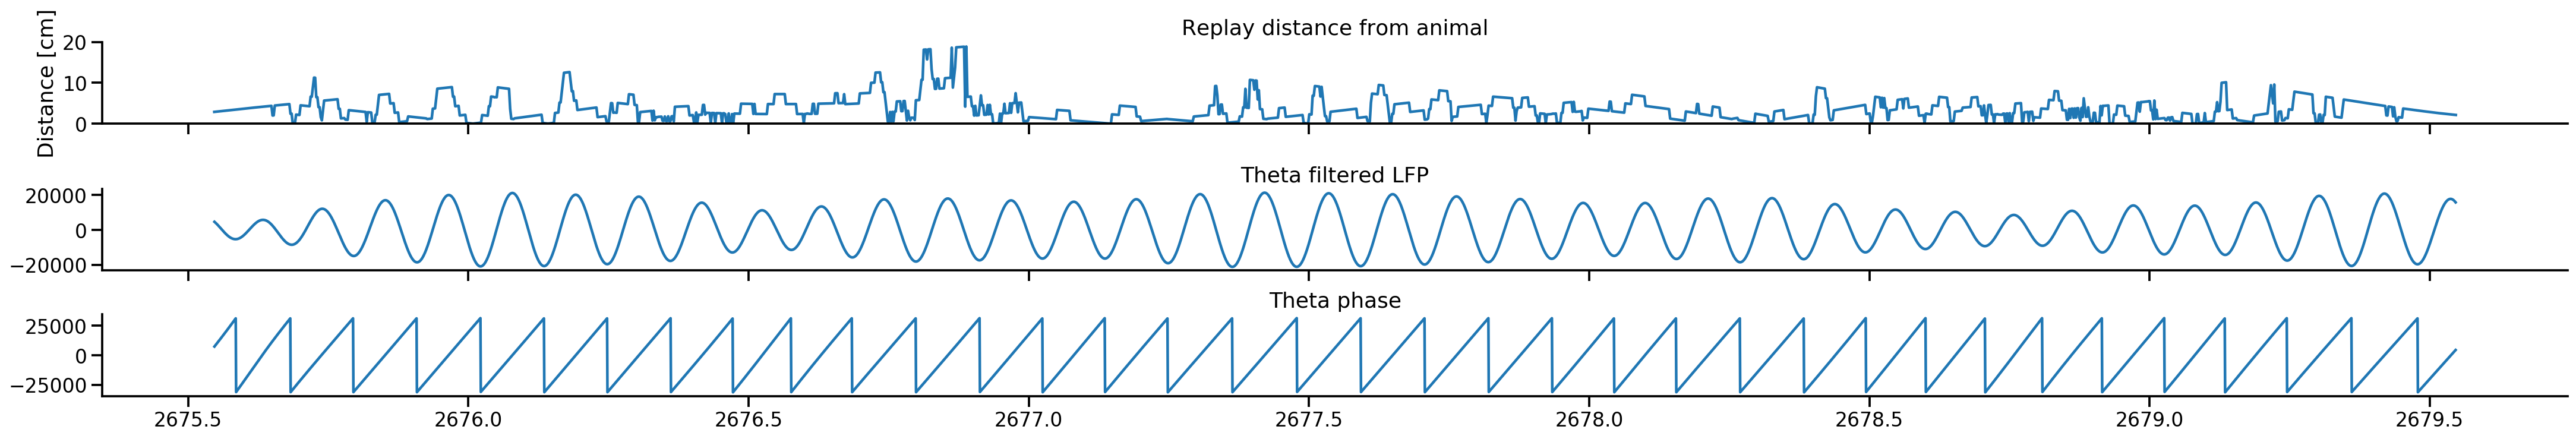

In [127]:
time_slice = slice(time[32500], time[34500])

posterior = cv_classifier_clusterless_results.sel(time=time_slice).sum("state").acausal_posterior
track_segment_id = data['position_info'].set_index(t).loc[time_slice, ['track_segment_id']].values.squeeze().astype(int)
cur_position_2D = data['position_info'].set_index(t).loc[time_slice, ['x_position', 'y_position']].values.squeeze()

replay_distance_from_animal_position = calculate_replay_distance(
        posterior, track_graph, cv_classifier, cur_position_2D, track_segment_id)

theta = data['theta'].set_index(data['theta'].index / np.timedelta64(1, 's')).loc[time_slice]

fig, axes = plt.subplots(3, 1, figsize=(30, 5), sharex=True, constrained_layout=True)
axes[0].plot(posterior.time, replay_distance_from_animal_position)
axes[0].set_title("Replay distance from animal")
axes[0].set_ylabel("Distance [cm]")
axes[0].set_ylim((0, 20))

axes[1].plot(theta.index, theta.bandpassed_lfp)
axes[1].set_title("Theta filtered LFP")

axes[2].plot(theta.index, theta.instantaneous_phase)
axes[2].set_title("Theta phase")

sns.despine()

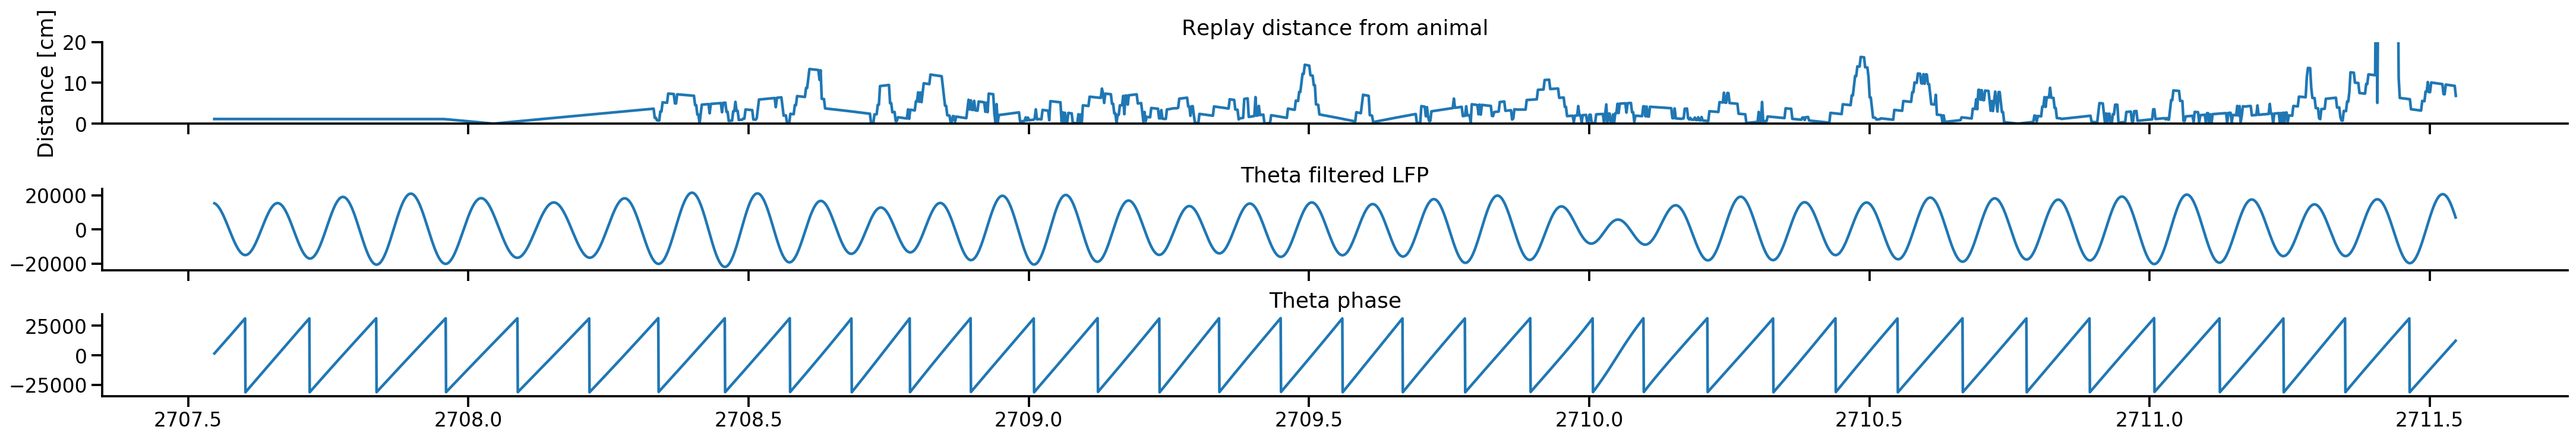

In [128]:
time_slice = slice(time[48500], time[50500])

posterior = cv_classifier_clusterless_results.sel(time=time_slice).sum("state").acausal_posterior
track_segment_id = data['position_info'].set_index(t).loc[time_slice, ['track_segment_id']].values.squeeze().astype(int)
cur_position_2D = data['position_info'].set_index(t).loc[time_slice, ['x_position', 'y_position']].values.squeeze()

replay_distance_from_animal_position = calculate_replay_distance(
        posterior, track_graph, cv_classifier, cur_position_2D, track_segment_id)

theta = data['theta'].set_index(data['theta'].index / np.timedelta64(1, 's')).loc[time_slice]

fig, axes = plt.subplots(3, 1, figsize=(30, 5), sharex=True, constrained_layout=True)
axes[0].plot(posterior.time, replay_distance_from_animal_position)
axes[0].set_title("Replay distance from animal")
axes[0].set_ylabel("Distance [cm]")
axes[0].set_ylim((0, 20))

axes[1].plot(theta.index, theta.bandpassed_lfp)
axes[1].set_title("Theta filtered LFP")

axes[2].plot(theta.index, theta.instantaneous_phase)
axes[2].set_title("Theta phase")

sns.despine()

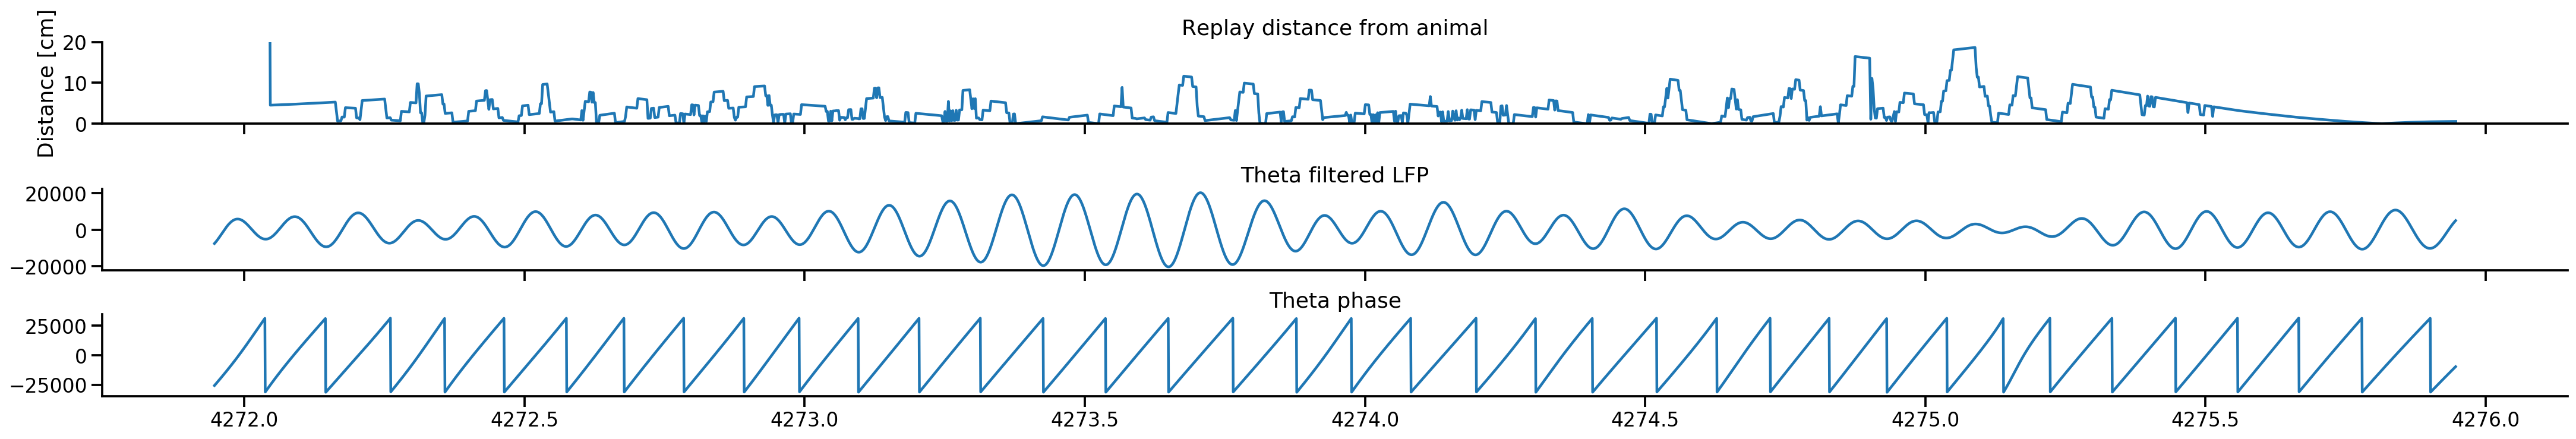

In [129]:
time_slice = slice(time[830700], time[832700])

posterior = cv_classifier_clusterless_results.sel(time=time_slice).sum("state").acausal_posterior
track_segment_id = data['position_info'].set_index(t).loc[time_slice, ['track_segment_id']].values.squeeze().astype(int)
cur_position_2D = data['position_info'].set_index(t).loc[time_slice, ['x_position', 'y_position']].values.squeeze()

replay_distance_from_animal_position = calculate_replay_distance(
        posterior, track_graph, cv_classifier, cur_position_2D, track_segment_id)

theta = data['theta'].set_index(data['theta'].index / np.timedelta64(1, 's')).loc[time_slice]

fig, axes = plt.subplots(3, 1, figsize=(30, 5), sharex=True, constrained_layout=True)
axes[0].plot(posterior.time, replay_distance_from_animal_position)
axes[0].set_title("Replay distance from animal")
axes[0].set_ylabel("Distance [cm]")
axes[0].set_ylim((0, 20))

axes[1].plot(theta.index, theta.bandpassed_lfp)
axes[1].set_title("Theta filtered LFP")

axes[2].plot(theta.index, theta.instantaneous_phase)
axes[2].set_title("Theta phase")

sns.despine()

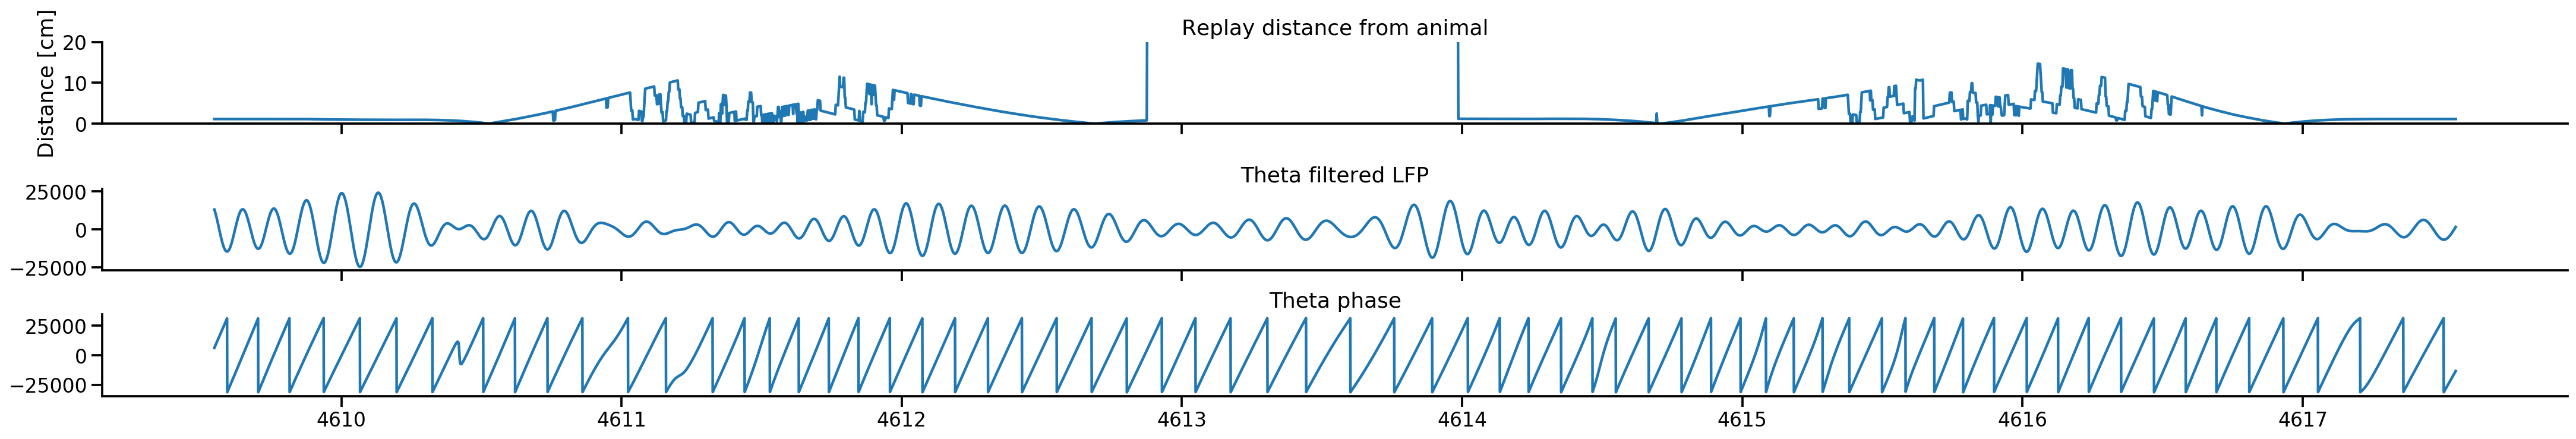

In [130]:
time_slice = slice(time[999500], time[1003500])

posterior = cv_classifier_clusterless_results.sel(time=time_slice).sum("state").acausal_posterior
track_segment_id = data['position_info'].set_index(t).loc[time_slice, ['track_segment_id']].values.squeeze().astype(int)
cur_position_2D = data['position_info'].set_index(t).loc[time_slice, ['x_position', 'y_position']].values.squeeze()

replay_distance_from_animal_position = calculate_replay_distance(
        posterior, track_graph, cv_classifier, cur_position_2D, track_segment_id)

theta = data['theta'].set_index(data['theta'].index / np.timedelta64(1, 's')).loc[time_slice]

fig, axes = plt.subplots(3, 1, figsize=(30, 5), sharex=True, constrained_layout=True)
axes[0].plot(posterior.time, replay_distance_from_animal_position)
axes[0].set_title("Replay distance from animal")
axes[0].set_ylabel("Distance [cm]")
axes[0].set_ylim((0, 20))

axes[1].plot(theta.index, theta.bandpassed_lfp)
axes[1].set_title("Theta filtered LFP")

axes[2].plot(theta.index, theta.instantaneous_phase)
axes[2].set_title("Theta phase")

sns.despine()